# GIOELE MIGNO 1795826 - Neural Network Project

# CREDITS TO ORIGINAL AUTHORS

THE FOLLOWING CODE AND DOCUMENTATION IS BASED ON THE LIBRARY AND EXAMPLES PROVIDED BY:

[GradMax: Growing Neural Networks using Gradient Information](https://arxiv.org/abs/2201.05125).

https://github.com/google-research/growneuron

Copyright 2021 Authors. SPDX-License-Identifier: Apache-2.0



LICENSE

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# PAPER SUMMARY
This section contains excerpts from the original paper 

## 1. Introduction


The architecture of deep learning models influences a model’s inductive biases and has been
shown to have a crucial effect on both the training speed and generalization. Searching for the best architecture for a given task is an active research area
with diverse approaches, including *neural architecture search* (NAS), *pruning*, and *evolutionary algorithms*. Most of these approaches are costly, as they require large search spaces or large architectures to start with. 


In the paper the authors consider an alternative approach: *Can we start with a small network and learn an efficient
architecture without ever needing a large network or exceeding the size of our final architecture?*

The idea of incrementally increasing the size of a model has been used in many settings, however the initialization of newly grown neurons is rarely studied. Existing work on growing neural networks either adds new neurons randomly or chooses
them with the aim of decreasing the training loss. 

In the paper they take a different approach. Instead of improving the training objective immediately through growing, they focus on improving the subsequent training dynamics. As they shown, this has a longer-lasting effect than the greedy approach of improving loss during growing.





The main authors' contribution is a new growing method that maximizes the gradient norm of newly added
neurons, which they call **GradMax**. 

## 2. Growing neural networks

Neural network learning is often formalized as the following optimization problem:


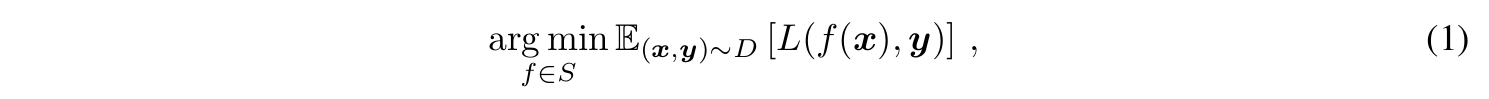

where:
- $S$ is a set of neural networks
- $L$ is a loss function
- $D$ is a dataset consisting of inputs $\mathbf{x}$ and outputs $\mathbf{y}$

Most often the set $S$ is constrained to a single architecture and only the parameters of the model are learned. However, hand-crafted
architectures are often suboptimal and various approaches aim to optimize the architecture itself together with its parameters, growing network is one of them.

### 2.1. When, where and how grow the network?

Algorithms for growing neural networks
start training with a smaller seed architecture. Then over the course of the training new neurons
are added to the seed architecture, either increasing the width of the existing layers or creating new
layers. 

Algorithms for growing neural networks should address the following questions:
1. **When** to add new neurons? 
2. **Where** to add new capacity? We can add new neurons to the existing layers or create new
layers among the existing ones. Here we focus only on the first approach.
3. **How** to initialize the new capacity?

In the paper the authors focused their attention only on the third point (**how**), and the first two points (**when**, **where**) are fixed, however their approach can be also used to guide **when** and **where**. In this notebook the **where** step is implemented following paper's authors suggestions.


## 3. GradMax

### 3.2. Basic idea

Suppose that during training we would like to grow $k$ new neurons
at layer $\ell$: (e.g. $k=1$)

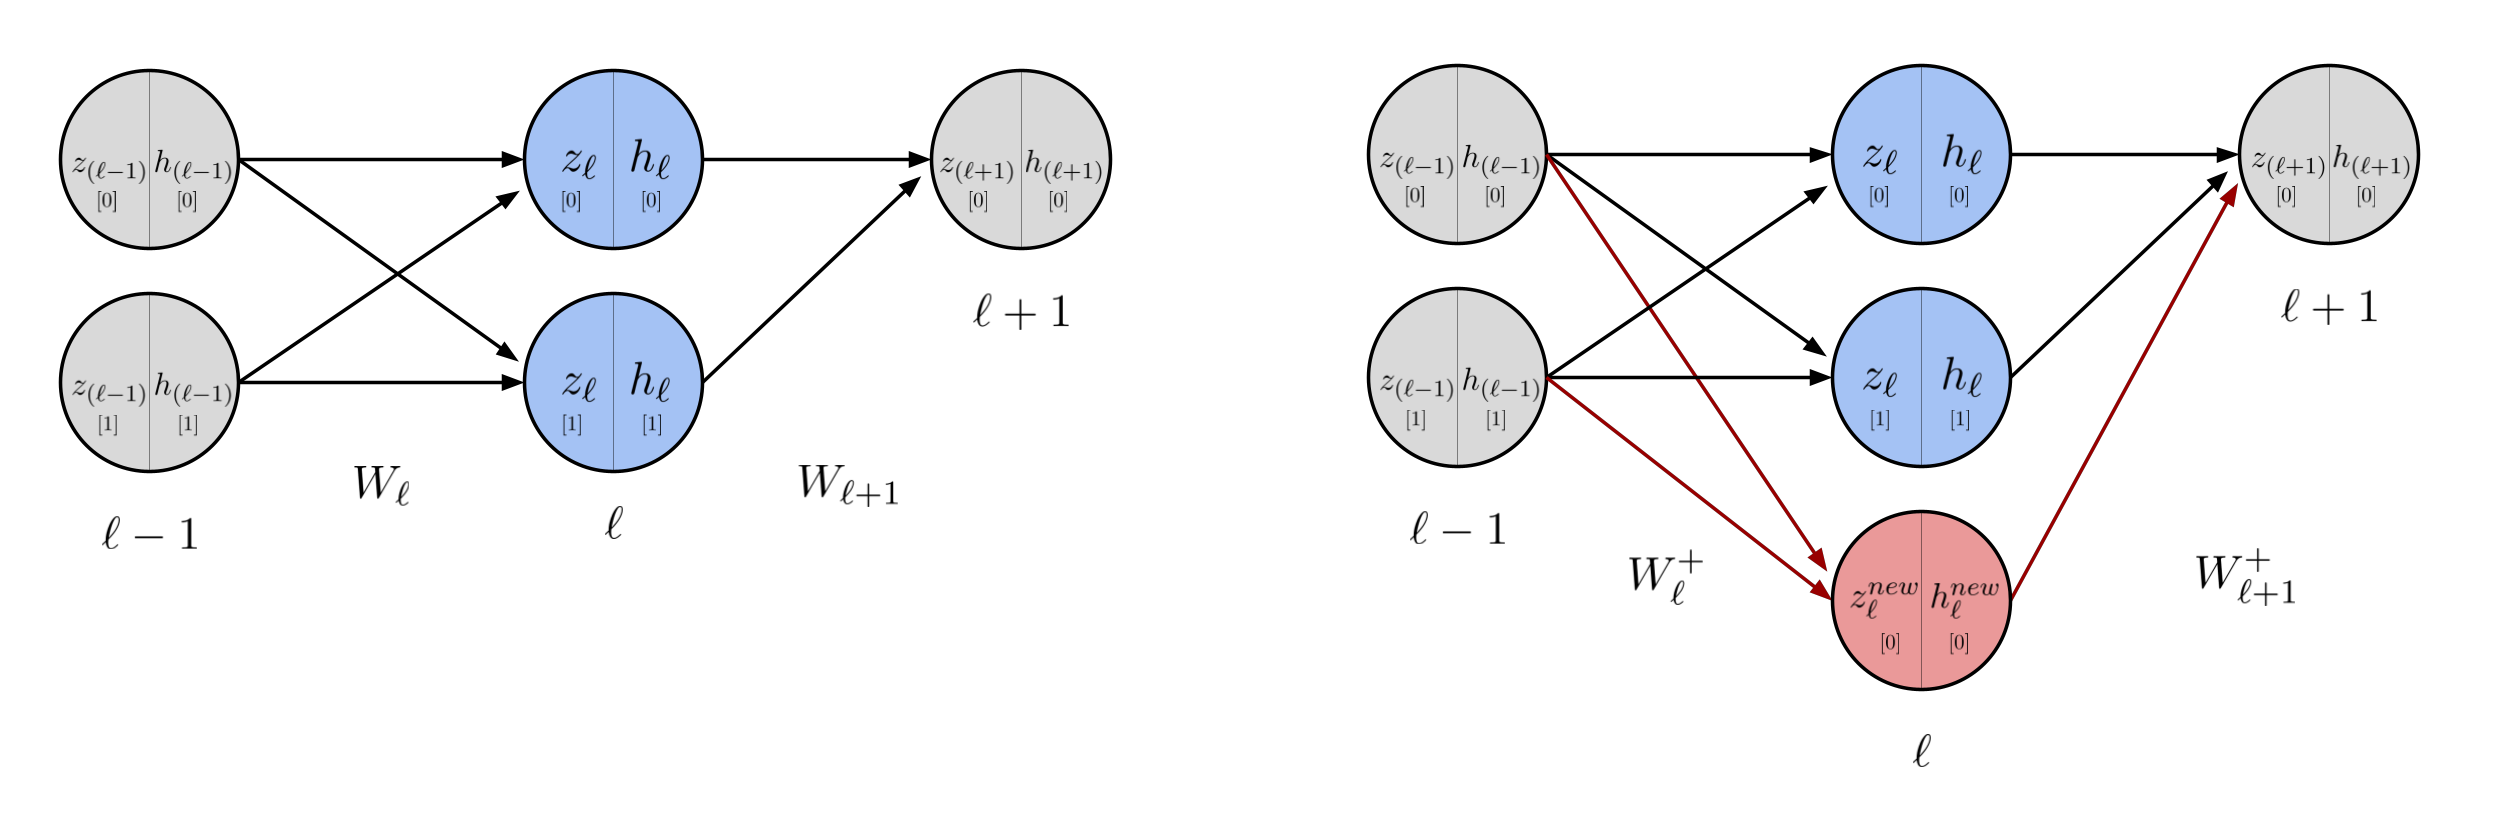

After the growth, new neurons (weights stored in $W_{\ell}^{new}$, $W_{\ell+1}^{new}$) are appended to the existing weight
matrices as follows:

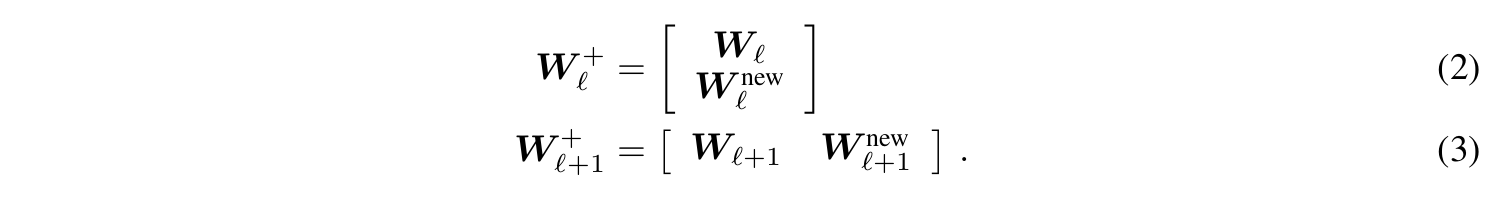

A desirable property of growing algorithms is to preserve the information that the network has
learned. Therefore the initialization of new neurons should ensure our neural network has the same
outputs before and after growth.

GradMax initializes the **incoming weights to zero** so that the network’s output
remains unchanged, and initializes the **outgoing ones** to improve the training dynamics by **maximizing the gradient norm**.
The hypothesis is that this accelerates training and leads to a better model in the long run.

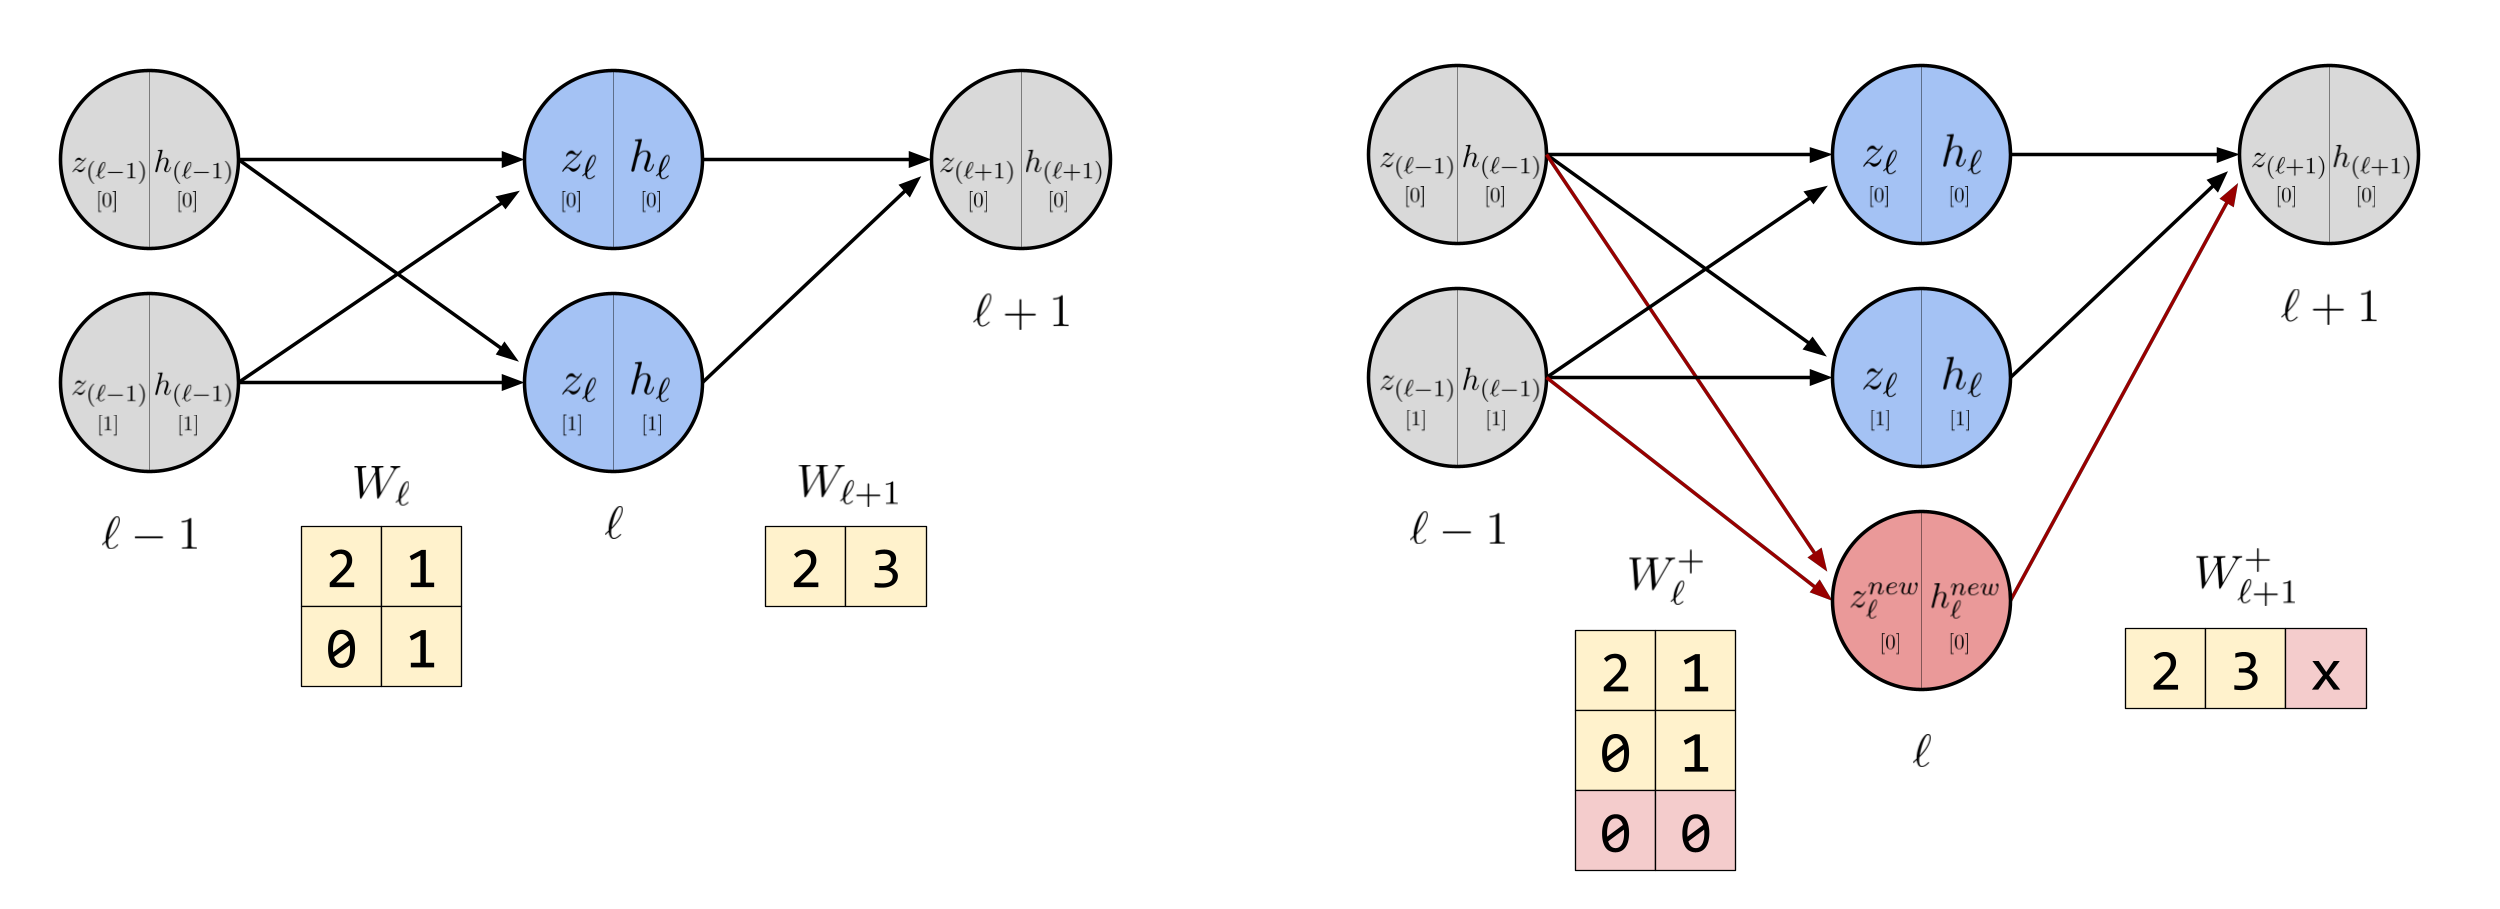

Let's see how to choose the new outgoing weights $W_{\ell+1}^{new}$ using GradMax

### 3.3. Algorithm

GradMax maximizes the gradient norm of the new weights. It constrains the norm of the new weights to avoid the trivial solution where the weight norm tends to infinity. 

It also guarantees that the network output is unchanged when the
neuron is added. Note that, due the latter, gradients of the existing weights are unchanged during
growth and therefore it maximizes the gradients only on the new weights introduced. 

Formally:

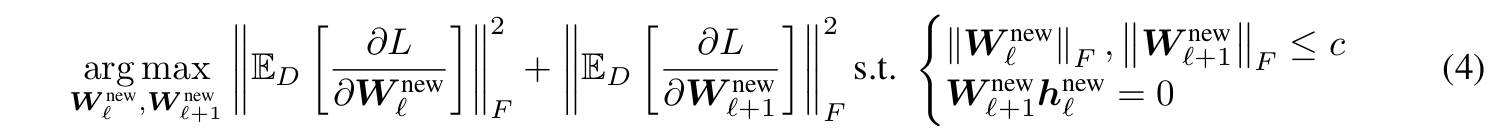

The general maximization problem in eq. (4) is non-trivial to solve. However, authors show that with some simplifying assumptions we can find an approximate solution using a singular value decomposition (SVD). Here we show this solution using only fully connected layers, authors also share derivation for convolutional layers in the paper's appendix.

3.3.1 Fully connected layers

Consider 3 fully connected layers denoted with indices $\ell - 1$, $\ell$ and $\ell + 1$ and the following recursive
definition where subscripts denote layer-indices:

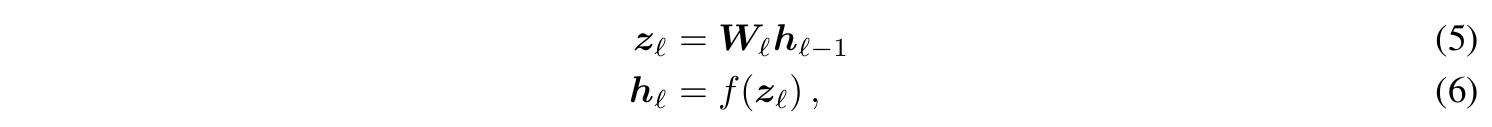


Let:
- $M_{\ell}$ denote the number of units in layer $\ell$ 
- $f$ the activation function
- $z_{\ell} \in \mathbb{R}^{M_{\ell}}$ is the pre-activations
- $h_{\ell} \in \mathbb{R}^{M_{\ell}}$ is the post-activations  ($h_0 = x$ being an input sampled from the dataset $D$)
- $W_{\ell} \in \mathbb{R}^{M_{\ell - 1} \times M_{\ell}}$ are the parameters of the layer

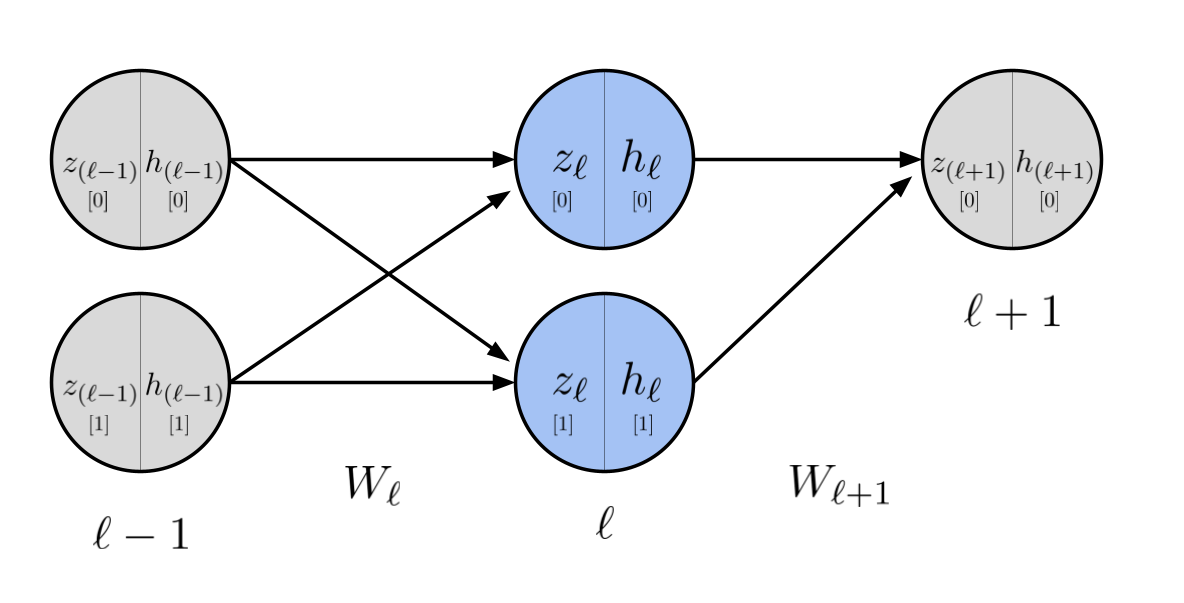

When growing $k$ neurons the weight matrices $W_{\ell}$ and $W_{\ell + 1}$ are replaced by $W_{\ell}^+$ and $W_{\ell + 1}^+$
as defined in eqs. (2) and (3). We denote the pre-activations and activations of the new neurons with $z_{\ell}^{new}$ and $h_{\ell}^{new}$

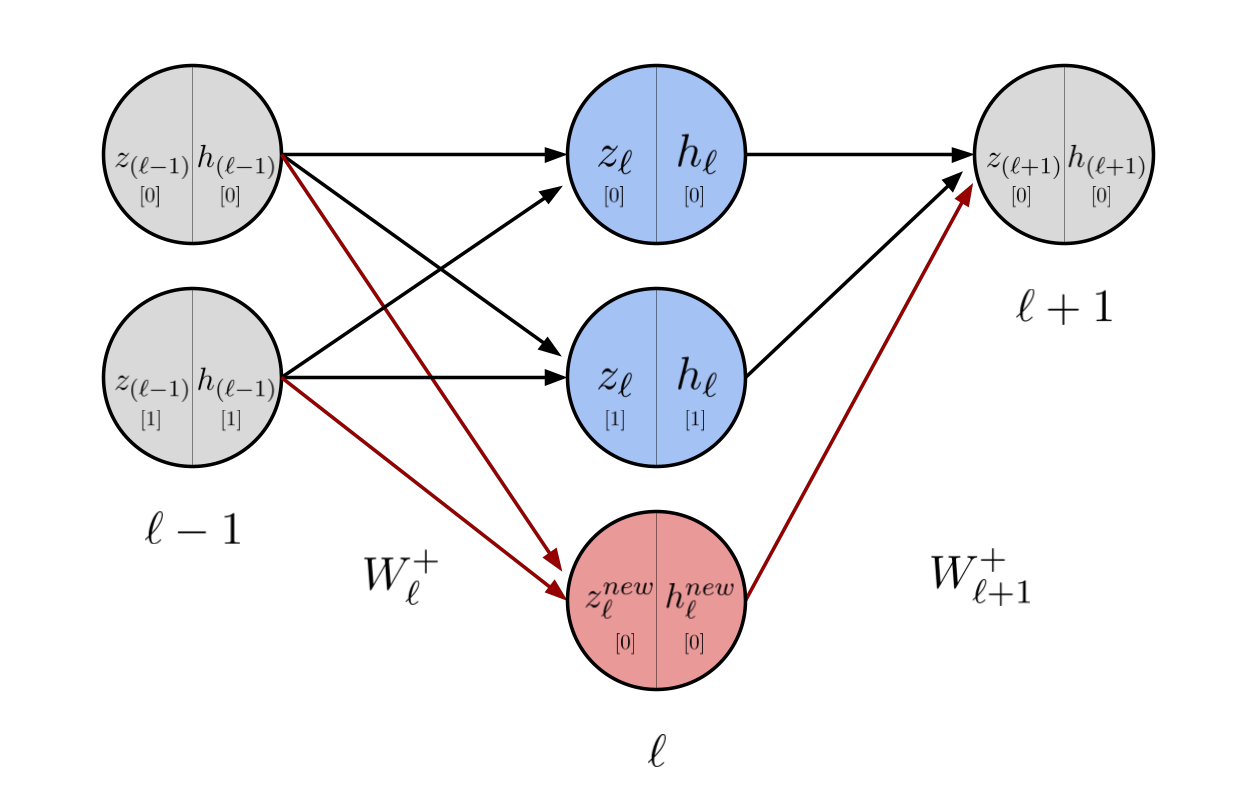

The gradients of the new weights can be derived using the chain rule:

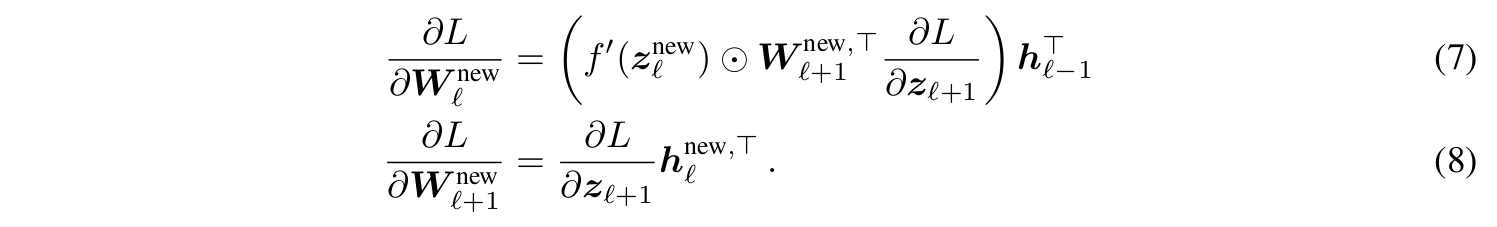

At this point we make three assumptions:
- $W_{\ell}^{new}$=0
- $f(0)=0$
- $f'(0)=1$

These assumptions guarantees that $W_{\ell+1}^{new}h_{\ell}^{new}=0$, independent of the training data, moreover it simplifies the gradients to:

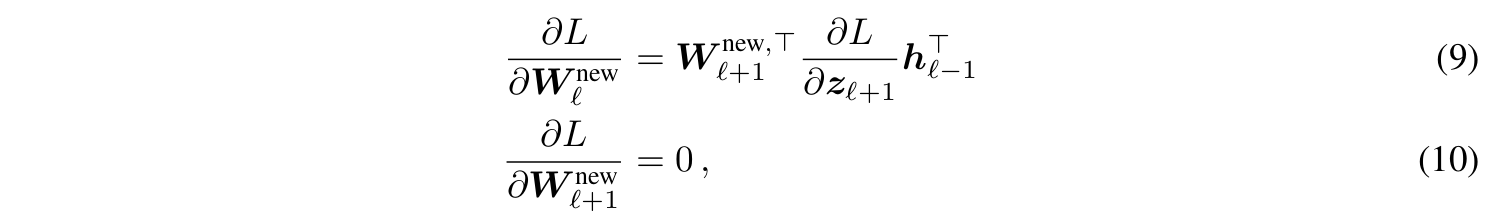

Therefore our problem (4) reduces to:

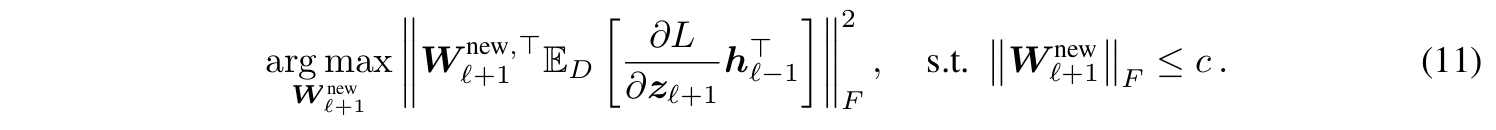

The solution to this maximization problem is found in a closed-form by setting the columns of $W_{\ell + 1}^{new}$
as the top $k$ left-singular vectors of the matrix $\mathbb{E}_D \left[ \frac{\partial L}{\partial z_{\ell + 1}} h_{\ell - 1}^T\right]$ and scaling them by $\frac{c}{||(\sigma_1, ..., \sigma_k)||}$
(where $\sigma_i$ is the i-th largest singular value).

As suggested by the authors, it is feasible to also use the singular values to guide **where** and **when** to grow, since the
singular values are equal to the value of the maximized optimization problem above. 

> In this notebook an additional updater called `AutoWhere` is implemented, it chooses the next layer to grow by taking the one with largest singular values. It also allows to set a maximum size for each layer, in this way the layers at maximum size are not considered as candidates.

## 4. Experiments

In the following the experiments performed are divided into two sections:
- **Student-teacher:** Several experiments are performed to solve a student-teacher task
- **Image classification:** GradMax algorithm is tested with Wide-Resnet-28-1 architecture on CIFAR-10 

> The code below has been partially modified in order to introduce the new network updater `AutoWhere` and to perform slightly different tests with respect to the original paper.

# LIBRARY

In this section there is `growneuron` library moved from files and adapted to be runned, and easlily editable, on a Jupyter notebook.
Each sub-section corresponds to a file.

> ORIGINAL REPOSITORY: https://github.com/google-research/growneuron

In [2]:
!pip install absl-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install ml-collections

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 1.9 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=d88ae4f4cc8d422a0ce3f8dbd02a386efc8fb56e3999295aebaabf3d1b9acbff
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections


In [4]:
!pip install "git+https://github.com/google/uncertainty-baselines.git#egg=uncertainty_baselines"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google/uncertainty-baselines.git to /tmp/pip-install-npyj4ey4/uncertainty-baselines_ec33e0b212bf491685601eb3ef99c49b
  Running command git clone -q https://github.com/google/uncertainty-baselines.git /tmp/pip-install-npyj4ey4/uncertainty-baselines_ec33e0b212bf491685601eb3ef99c49b
  Cloning https://github.com/google-research/robustness_metrics.git to /tmp/pip-install-npyj4ey4/robustness-metrics_fef603bb0cb54ddbab520e6069faf323
  Running command git clone -q https://github.com/google-research/robustness_metrics.git /tmp/pip-install-npyj4ey4/robustness-metrics_fef603bb0cb54ddbab520e6069faf323
     |████████████████████████████████| 4.0 MB 2.1 MB/s 
     |████████████████████████████████| 350 kB 53.8 MB/s 
  Created wheel for uncertainty-baselines: filename=uncertainty_baselines-0.0.7-py3-none-any.whl size=431146 sha256=982f454bce12f5651c0ce58d87fd71e0dd4f5a2bac3d

In [5]:
from functools import partial
from types import SimpleNamespace    
from termcolor import colored

In [6]:
!pip install icecream > /dev/null
from icecream import ic               # used to print

In [7]:
from pprint import pprint
def cpprint(to_print):
  pprint(to_print, width=100, compact=True)

## layer.py

In [8]:
# coding=utf-8
# Copyright 2022 GradMax Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""GrowLayer wrapper module."""
import numpy as np
import tensorflow as tf

SUPPORTED_LAYERS = (tf.keras.layers.Dense, tf.keras.layers.Conv2D)

def get_activation_fn(actv_fn):
  """Activation choices for the layer.

  Args:
    actv_fn: str.

  Returns:
    activation fn
  """
  if actv_fn == 'relu1':
    # This has grad(f(0))=1 instead of 0 (default implementation).
    return lambda x: tf.math.maximum(x, 0)
  elif actv_fn == 'relu2':
    # This has grad(f(0))=1.
    return lambda x: tf.math.maximum(x, -1)
  else:
    return tf.keras.activations.get(actv_fn)


class GrowLayer(tf.keras.layers.Wrapper):
  """This layer wraps keras.layers in order to support growing.

  This layer allows adding callbacks to the forward pass of a layer that will be
  called with the inputs and outputs of the underlying layer before the
  activations.

  Example Usage:
    ```
    first_layer = GrowLayer(tf.keras.layers.Dense(32))
    ```

  This layer can be used for growing neurons.
    `first_layer.add_neurons_incoming(1, new_weights='zeros')`
  """

  def __init__(self, *args, activation=None, **kwargs):
    if 'name' not in kwargs:
      # args[0] is the wrapped layer
      kwargs['name'] = f'glayer_{args[0].name}'
    super().__init__(*args, **kwargs)
    self.activation = get_activation_fn(activation)
    self.reset_callbacks()

  def add_callback(self, name, fn):
    self._callbacks[name] = fn

  def remove_callback(self, name):
    del self._callbacks[name]

  def reset_callbacks(self):
    self._callbacks = {}

  def __call__(self, inputs, *args, **kwargs):
    outputs = self.layer.__call__(inputs, *args, **kwargs)
    for _, callback_fn in self._callbacks.items():
      inputs, outputs = callback_fn(inputs, outputs)
    if self.activation:
      outputs = self.activation(outputs)
    return outputs

  def add_neurons(self, n_new, new_weights='zeros', scale=1.,
                  is_outgoing=False, scale_method='mean_norm',
                  new_bias='zeros'):
    """Adds new neurons and creates a new layer.

    New weights are scaled (if not zero) to have l2-norm equal to the mean
    l2-norm of the existing weights.
    TODO Unify splitting and adding neurons.
    Args:
      n_new: number of neurons to add.
      new_weights: 'zeros', 'random' or np.ndarray.
      scale: float, scales the new_weights multiplied with the mean norm of
        the existing weights.
      is_outgoing: bool, if true adds outgoing connections from the new neurons
        coming from previous layers. In other words number of neurons in current
        layer stays constant, but they aggregate information from n_new many
        new neurons.
      scale_method: str, Type of scaling to be used when initializing new
        neurons.
        - `mean_norm` means they are normalized using the mean norm of
        existing weights.
        - `fixed` means the weights are multiplied with scale directly.
      new_bias: str, 'zeros' or 'ones'.
    """
    old_module = self.layer
    assert old_module.built
    assert new_bias in ('zeros', 'ones')
    assert isinstance(old_module, SUPPORTED_LAYERS)
    self.layer = grow_new_layer(old_module, n_new, new_weights, scale,
                                is_outgoing=is_outgoing, new_bias=new_bias,
                                scale_method=scale_method)

  def add_neurons_identity(self, n_new):
    """Adds identity neurons for various layer types.

    Args:
      n_new: number of neurons to add.
    """
    old_module = self.layer
    assert old_module.built
    if isinstance(old_module, tf.keras.layers.BatchNormalization):
      self.layer = grow_new_bn_layer(old_module, n_new)
    elif isinstance(old_module, tf.keras.layers.LayerNormalization):
      self.layer = grow_new_ln_layer(old_module, n_new)
    elif isinstance(old_module, tf.keras.layers.DepthwiseConv2D):
      self.layer = grow_new_dw_layer(old_module, n_new)
    else:
      raise ValueError(f'layer: {old_module} of {type(old_module)} is not '
                       'supported.')


def grow_new_layer(old_module, n_new, new_weights, scale, is_outgoing=False,
                   scale_method='mean_norm', new_bias='zeros'):
  """Creates new layer after adding incoming our outgoing connections.

  Args:
    old_module: Old layer to grow from. One of layers.SUPPORTED_LAYERS.
    n_new: number of neurons to add.
    new_weights: 'zeros', 'random' or np.ndarray.
    scale: float, scales the new_weights multiplied with the mean norm of
      the existing weights.
    is_outgoing: bool, True if the outgoing connections of the new neurons are
      being added to the next layer. In this case, no new neurons are generated;
      instead existing neurons receive new incoming connections.
    scale_method: str, Type of scaling to be used when initializing new
      neurons.
      - `mean_norm` means they are normalized using the mean norm of
      existing weights.
      - `fixed` means the weights are multiplied with scale directly.
    new_bias: str, zeros or ones.
  Returns:
    layer of same type as the old_module.
  """
  old_weights = old_module.get_weights()[0]
  shape_axis = -2 if is_outgoing else -1

  if scale_method == 'mean_norm':
    magnitude_new = np.mean(norm_l2(old_weights, keep_dim=shape_axis).numpy())
    magnitude_new *= scale
  elif scale_method == 'fixed':
    # We don't use the scale of existing weights for initialization.
    magnitude_new = scale
  else:
    raise ValueError(f'Not supported scale_method, {scale_method}')

  shape_new = list(old_weights.shape)
  shape_new[shape_axis] = n_new

  if isinstance(new_weights, np.ndarray):
    assert new_weights.shape == tuple(shape_new)
    # Normalize to unit norm and then scale.
    normalized_w = normalize_l2(new_weights, axis=shape_axis).numpy()
    new_neurons = normalized_w * magnitude_new
  elif new_weights == 'random':
    normalized_w = normalize_l2(np.random.uniform(size=shape_new),
                                axis=shape_axis).numpy()
    # Normalize to unit norm and then scale.
    new_neurons = normalized_w * magnitude_new
  elif new_weights == 'zeros':
    new_neurons = np.zeros(shape_new)
  else:
    raise ValueError('new_weights: %s is not valid' % new_weights)
  new_layer_weights = [np.concatenate((old_weights, new_neurons),
                                      axis=shape_axis)]

  # Assuming bias is the second weight.
  if old_module.use_bias:
    new_bias_weights = old_module.get_weights()[1]
    if not is_outgoing:
      new_neuron_bias = (np.zeros([n_new]) if (new_bias == 'zeros') else
                         np.ones([n_new]))
      new_bias_weights = np.concatenate((new_bias_weights, new_neuron_bias),
                                        axis=0)
    new_layer_weights.append(new_bias_weights)

  common_kwargs = {
      'name': old_module.name,
      'activation': old_module.activation,
      'use_bias': old_module.use_bias
  }
  for r_name in ('kernel_regularizer', 'bias_regularizer',
                 'activity_regularizer'):
    regularizer = getattr(old_module, r_name)
    if regularizer is not None:
      common_kwargs[r_name] = regularizer
  n_out_new = new_layer_weights[0].shape[-1]
  if isinstance(old_module, tf.keras.layers.Dense):
    new_module = tf.keras.layers.Dense(
        n_out_new,
        weights=new_layer_weights,
        **common_kwargs)
  elif isinstance(old_module, tf.keras.layers.Conv2D):
    new_module = tf.keras.layers.Conv2D(
        n_out_new,
        kernel_size=old_module.kernel_size,
        strides=old_module.strides,
        padding=old_module.padding,
        weights=new_layer_weights,
        **common_kwargs)
  else:
    raise ValueError(f'Unexpected module: {old_module}')

  return new_module


def grow_new_ln_layer(old_module, n_new):
  """Grows a new identity LayerNormalization layer."""
  new_ln_weights = []
  # One for gamma, beta
  for i in range(2):
    old_w = old_module.get_weights()[i]
    if i == 0:  # gamma
      new_w = np.ones([n_new])
    else:  # beta
      new_w = np.zeros([n_new])
    w = np.concatenate((old_w, new_w), axis=0)
    new_ln_weights.append(w)
  common_kwargs = {
      'epsilon': old_module.epsilon
  }
  for r_name in ('gamma_regularizer', 'beta_regularizer'):
    regularizer = getattr(old_module, r_name)
    if regularizer is not None:
      common_kwargs[r_name] = regularizer
  return tf.keras.layers.LayerNormalization(weights=new_ln_weights,
                                            **common_kwargs)


def grow_new_bn_layer(old_module, n_new):
  """Grows a new identity BatchNormalization layer."""
  new_bn_weights = []
  # One for gamma, beta, moving_mean and moving_variance
  for i in range(4):
    old_w = old_module.get_weights()[i]
    if i in (1, 2):  # beta, moving_mean
      new_w = np.zeros([n_new])
    else:  # gamma, moving variance
      new_w = np.ones([n_new])
    w = np.concatenate((old_w, new_w), axis=0)
    new_bn_weights.append(w)
  common_kwargs = {
      'epsilon': old_module.epsilon
  }
  for r_name in ('gamma_regularizer', 'beta_regularizer'):
    regularizer = getattr(old_module, r_name)
    if regularizer is not None:
      common_kwargs[r_name] = regularizer
  return tf.keras.layers.BatchNormalization(weights=new_bn_weights,
                                            **common_kwargs)


def grow_new_dw_layer(old_module, n_new):
  """Adds identity neurosn to the depthwise convolutional layers."""
  old_weights = old_module.get_weights()[0]
  shape_new = list(old_weights.shape)
  shape_new[-2] = n_new
  new_weights = np.zeros(shape_new, dtype=old_weights.dtype)
  mid_index_x = new_weights.shape[0] // 2
  mid_index_y = new_weights.shape[1] // 2
  new_weights[mid_index_x, mid_index_y, Ellipsis] = 1.
  new_layer_weights = [np.concatenate((old_weights, new_weights),
                                      axis=-2)]

  # Assuming bias is the second weight.
  if old_module.use_bias:
    new_bias = old_module.get_weights()[1]
    new_neuron_bias = np.zeros([n_new])
    new_bias = np.concatenate((new_bias, new_neuron_bias), axis=0)
    new_layer_weights.append(new_bias)

  regularizer_kwargs = {}
  for r_name in ('kernel_regularizer', 'bias_regularizer',
                 'activity_regularizer'):
    regularizer = getattr(old_module, r_name)
    if regularizer is not None:
      regularizer_kwargs[r_name] = regularizer
  new_module = tf.keras.layers.DepthwiseConv2D(
      kernel_size=old_module.kernel_size,
      name=old_module.name,
      activation=old_module.activation,
      use_bias=old_module.use_bias,
      strides=old_module.strides,
      padding=old_module.padding,
      weights=new_layer_weights,
      **regularizer_kwargs)
  return new_module


def norm_l2(tensor, keep_dim):
  norm_axes = list(range(len(tensor.shape)))
  del norm_axes[keep_dim]
  return tf.sqrt(tf.reduce_sum(tf.pow(tensor, 2), axis=norm_axes))


def normalize_l2(tensor, axis):
  assert axis in (-2, -1)
  norm = norm_l2(tensor, axis)
  scale_recipe = '...ij,i->...ij' if (axis == -2) else '...ij,j->...ij'
  return tf.einsum(scale_recipe, tensor, 1 / norm)

## updaters.py

In [9]:
# coding=utf-8
# Copyright 2022 GradMax Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Implements controllers for updating networks.
"""
import itertools
#from growneuron import growers
#from growneuron import layers
import tensorflow as tf

def pad_zeros_to(tensor, new_shape):
  """Pads a tensor with zeros such that final shape is new_shape.

  It expects the new_shape to be larger than the tensor.shape.
  Zeros are added to the end of each dimension.
  Args:
    tensor: 1d, 2d, 3d tensor.
    new_shape: list of dimensions where len(new_shape) == len(tensor.shape)
  Returns:
    new tensor of shape `new_shape`.
  """
  old_shape = tensor.shape

  if len(old_shape) == 1:
    # Batchnorm or bias.
    diff_shape = [new_shape[-1] - old_shape[-1]]
    concat_axis = -1
  else:
    if old_shape[-2] == new_shape[-2]:
      # Input features are same, padding at axis=-1.
      concat_axis = -1
    else:
      concat_axis = -2
    diff_shape = list(old_shape)
    diff_shape[concat_axis] = new_shape[concat_axis] - old_shape[concat_axis]
  return tf.concat([tensor, tf.zeros(diff_shape)], axis=concat_axis)


class Updater():
  """Implements common methods.

  Updaters should be created under strategy scope or strategy should be passed
  directly.
  Attr:
    network_grower: growers.LayerGrower
    grow_layer_tuples: list of lists<glayers.GrowLayer>, candidates to be
      grown together with their outgoing weights.
    loss_fn: fn, Used to calculate loss. This function should get inputs
      as input and return loss.
    compile_fn: fn, Called to compile the model.
    update_frequency: int, Number of iterations before neurons are added.
    n_grow: int, number of neurons to grow at each growth step.
    n_grow_fraction: float, must be positive. Used together with initial width
      of candidate layers to decide n_neurons to grow at each growth step for
      each candidate separately. This approach is helpful when predicting the
      final architecture from the start as number of neurons added are fixed at
      the beginning for each layer.
    start_iteration: int, to start growing
    n_growth_steps: int, number of times the network is grown.
    scale: int, passed to the grower.grow_neurons
    carry_optimizer: bool, If true the running averages are carried to the new
      optimizer after the growth. Since variables are recreated after growth
      this is necessary.
  """

  def __init__(self, network_grower, grow_layer_tuples, loss_fn=lambda x: x,
               compile_fn=lambda: None, update_frequency=1, n_grow=1,
               n_grow_fraction=None, start_iteration=None, n_growth_steps=None,
               scale=1., carry_optimizer=True, limits_n_units=None):
    assert update_frequency > 0
    assert n_grow > 0
    self._update_frequency = update_frequency
    self._carry_optimizer = carry_optimizer
    self._n_grow = n_grow
    self._n_grow_fraction = n_grow_fraction
    self._scale = scale
    if start_iteration is None:
      start_iteration = update_frequency
    self._start_iteration = start_iteration
    self.loss_fn = loss_fn
    self.compile_fn = compile_fn
    self.strategy = tf.distribute.get_strategy()
    self.network_grower = self._prepare_grower(network_grower)
    self._n_growth_steps = n_growth_steps
    self._growth_counter = 0
    self._set_grow_layer_tuples(grow_layer_tuples)
    #
    # used in AutoWhere
    self._set_limits_n_units(grow_layer_tuples, limits_n_units)

  def _prepare_grower(self, grower):
    if grower:
      grower.loss_fn = self.loss_fn
      grower.compile_fn = self.compile_fn
      grower.strategy = self.strategy
    return grower

  def copy_optimizer_slots(self, optimizer, old_variables, new_variables):
    """Copy old slots and pad with zeros for new neurons."""
    for old_var, new_var in zip(old_variables, new_variables):
      for s_name in sorted(optimizer.get_slot_names()):
        old_slot_var = optimizer.get_slot(old_var, s_name)
        new_slot_var = optimizer.get_slot(new_var, s_name)
        # This is used to retrieve the part of the new slot used for the
        # old variables. This assumes new variables are appended to the end.
        new_slot_values = pad_zeros_to(old_slot_var, new_slot_var.shape)
        new_slot_var.assign(new_slot_values)

  def delete_optimizer_slots(self, optimizer, variables):
    """Deleted old variable slots from the optimizer."""
    for old_var in variables:
      key = (old_var._shared_name if old_var._in_graph_mode
             else old_var._unique_id)
      optimizer._slots.pop(key, None)


  def _set_limits_n_units(self, grow_layer_tuples, limits_n_units):
    """Sets the limits on number of units for each layers growable."""
    if not grow_layer_tuples:
      raise ValueError("grow_layer_tuples argument can't be empty.")
    self.limits_n_units = limits_n_units

    if self.limits_n_units:
      self._n_grow_units_limit = {
          tpl[0].name: limit
          for tpl, limit in zip(grow_layer_tuples, limits_n_units)
      }
    else:
      self._n_grow_units_limit = None


  def _set_grow_layer_tuples(self, grow_layer_tuples):
    """Sets the tuple of layers for growing."""
    if not grow_layer_tuples:
      raise ValueError("grow_layer_tuples argument can't be empty.")
    self.grow_layer_tuples = grow_layer_tuples

    def get_n_neuron(n_neuron_initial):
      if self._n_grow_fraction:
        return int(max(1, n_neuron_initial * self._n_grow_fraction))
      else:
        return self._n_grow
    # Used to calculate n_grow per layer using grow_fraction.
    # n_neurons are decided using the initial architecture.
    self._n_grow_dict = {
        tpl[0].name: get_n_neuron(tpl[0].weights[0].shape[-1])
        for tpl in grow_layer_tuples
    }



  def is_update_iteration(self, iteration):
    assert iteration >= 0
    return ((self.network_grower is not None) and
            (iteration % self._update_frequency == 0) and
            (self._start_iteration <= iteration) and
            ((self._n_growth_steps is None) or
             (self._growth_counter < self._n_growth_steps)))

  def get_variable_list(self, grow_layer_tuple):
    return list(itertools.chain.from_iterable(
        [layer.trainable_weights for layer in grow_layer_tuple]))

  def get_grow_layer_stats(self):
    all_stats = []
    for grow_layer_tuple in self.grow_layer_tuples:
      first_layer = grow_layer_tuple[0]
      n_neuron = first_layer.get_weights()[0].shape[-1]
      all_stats.append((first_layer.layer.name, n_neuron))
    return all_stats

  def update_network(self, batch_data, optimizer=None):
    raise NotImplementedError()


class DummyUpdater(Updater):
  """Implements common methods.

  Attr:
    network_grower: growers.LayerGrower
    grow_layer_tuples: list of lists<glayers.GrowLayer>, candidates to be
      grown together with their outgoing weights.
    update_frequency: int, Number of iterations before neurons are added.
  """

  def __init__(self, grow_layer_tuples):
    super().__init__(None, grow_layer_tuples, None, None)

  def update_network(self, **kwargs):
    pass

  def is_update_iteration(self, epoch):
    del epoch
    return False

  def get_grow_layer_stats(self):
    return []


class RoundRobin(Updater):
  """Updates provided candidate layers in a round robin fashion."""

  # pick the next layer to grow
  def _next_grow_layer_tuple(self, unused_batch_data):
    next_tuple_id = self._growth_counter % len(self.grow_layer_tuples)
    self._growth_counter += 1
    return self.grow_layer_tuples[next_tuple_id]

  def update_network(self, batch_data, optimizer=None):
    """Updates the network and optimizer slots."""
    grow_layer_tuple = self._next_grow_layer_tuple(batch_data)
    old_variables = self.get_variable_list(grow_layer_tuple)
    n_new = self._n_grow_dict[grow_layer_tuple[0].name]
    self.network_grower.grow_neurons(grow_layer_tuple, batch_data,
                                     n_new=n_new, scale=self._scale)
    # Run the loss function to create new variables.
    self.compile_fn()
    new_variables = self.get_variable_list(grow_layer_tuple)
    optimizer._create_slots(new_variables)
    if self._carry_optimizer and optimizer:
      self.copy_optimizer_slots(optimizer, old_variables, new_variables)
    self.delete_optimizer_slots(optimizer, old_variables)

class AutoWhere(Updater):
  # pick the next layer to grow
  def _next_grow_layer_tuple(self, batch_data):
    # for each candidate we provide the number of neurons that we would like
    # to add. On the paper #new_neurons = k
    if self.limits_n_units:
      current_n_units = [list(layer_tuple[1].weights[0].shape)[0] for layer_tuple in self.grow_layer_tuples]
      ic(current_n_units)

      limits_n_units = [self._n_grow_units_limit[layer_tuple[0].name] for layer_tuple in self.grow_layer_tuples]
      ic(limits_n_units)

      candidates = list()
      n_grows =list()
      for c_n_unit, limit, layer_tuple in zip(current_n_units, limits_n_units, self.grow_layer_tuples):
        if c_n_unit < limit:
          candidates.append(layer_tuple)
          n_grows.append(self._n_grow_dict[layer_tuple[0].name])

      if len(candidates) == 0:
        return None

    else:
      candidates = self.grow_layer_tuples
      n_grows = [self._n_grow_dict[layer_tuple[0].name] for layer_tuple in self.grow_layer_tuples]
      ic(n_grows)
    
    # for each candidate we compute SVD that returns eigenvalues and eigenvector
    list_of_eigenvals_eigenvecs_tuples = get_growth_directions(strategy=self.strategy, 
                                                                loss_fn=self.loss_fn, 
                                                                batch_data=batch_data, 
                                                                growth_candidates=candidates, 
                                                                n_grows=n_grows)
    singular_values_means = list()
    for (eigenvals, eigenvecs) in list_of_eigenvals_eigenvecs_tuples:
      singular_values_means.append(np.mean(eigenvals))

    '''
    ic(singular_values_means)

    text = "#"*100
    print(colored(text, 'magenta'), flush=True)
    ic(n_grows)
    ic(list_of_eigenvals_eigenvecs_tuples)
    text = "."*100
    print(colored(text, 'yellow'), flush=True)
    '''
#    next_tuple_id = self._growth_counter % len(self.grow_layer_tuples)
    next_tuple_id = singular_values_means.index(max(singular_values_means))
    self._growth_counter += 1
    return candidates[next_tuple_id]# self.grow_layer_tuples[next_tuple_id]

  def update_network(self, batch_data, optimizer=None):
    """Updates the network and optimizer slots."""
    grow_layer_tuple = self._next_grow_layer_tuple(batch_data)
    if grow_layer_tuple is None:
      print(colored("There are no more growable layers", 'red'))
      return

    old_variables = self.get_variable_list(grow_layer_tuple)
    n_new = self._n_grow_dict[grow_layer_tuple[0].name]

    self.network_grower.grow_neurons(grow_layer_tuple, batch_data,
                                     n_new=n_new, scale=self._scale)
    # Run the loss function to create new variables.
    self.compile_fn()
    new_variables = self.get_variable_list(grow_layer_tuple)
    optimizer._create_slots(new_variables)
    if self._carry_optimizer and optimizer:
      self.copy_optimizer_slots(optimizer, old_variables, new_variables)
    self.delete_optimizer_slots(optimizer, old_variables)


class AllAtOnce(Updater):
  """Grows all candidate layers at once."""

  def _get_all_grow_layer_tuples(self):
    self._growth_counter += 1
    return self.grow_layer_tuples[:]

  def update_network(self, batch_data, optimizer=None):
    """Updates the network and optimizer slots."""
    grow_layer_tuples = self._get_all_grow_layer_tuples()
    for grow_layer_tuple in grow_layer_tuples:
      old_variables = self.get_variable_list(grow_layer_tuple)
      n_new = self._n_grow_dict[grow_layer_tuple[0].name]
      self.network_grower.grow_neurons(grow_layer_tuple, batch_data,
                                       n_new=n_new, scale=self._scale)
      # Run the loss function to create new variables.
      self.compile_fn()
      new_variables = self.get_variable_list(grow_layer_tuple)
      optimizer._create_slots(new_variables)
      if self._carry_optimizer and optimizer:
        self.copy_optimizer_slots(optimizer, old_variables, new_variables)
      self.delete_optimizer_slots(optimizer, old_variables)




def adjust_epochs(train_epochs, width_scale, update_frequency,
                  start_iteration, n_growth_steps, steps_per_epoch):
  """Adjust the epochs such as the total FLOPs are same as big-baseline."""
  # Here we extend training according to the FLOP saved by starting with
  # a smaller width.
  saved_fraction = (1 - width_scale)
  # Saved before growth.
  saved_steps = saved_fraction * start_iteration
  growth_duration = (update_frequency * (n_growth_steps - 1))
  # Saved during growth (2 is because of the trianble area).
  saved_steps += saved_fraction/2 * growth_duration
  new_epochs = train_epochs + int(saved_steps / steps_per_epoch)
  return new_epochs

## growers.py 

In [10]:
# coding=utf-8
# Copyright 2022 GradMax Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""This module implements various growing algorithms.
"""
import functools
import logging

#import growneuron.layers as glayers
d = {
      'SUPPORTED_LAYERS': SUPPORTED_LAYERS, 
      'get_activation_fn': get_activation_fn,
      'GrowLayer': GrowLayer,
      'grow_new_layer': grow_new_layer,
      'grow_new_ln_layer': grow_new_ln_layer,
      'grow_new_bn_layer': grow_new_bn_layer,
      'grow_new_dw_layer': grow_new_dw_layer,
      'norm_l2': norm_l2,
      'normalize_l2': normalize_l2,
    }
glayers = SimpleNamespace(**d)


import numpy as np
from scipy.sparse.linalg.eigen import arpack
import tensorflow as tf

class LayerGrower():
  """Base class for growing layer algorithms.

  Subclasses should implement grow_neurons.
    grad_fn: Should return list of variables and return aggregated gradients.
    grow_layers: list of GrowLayers. There are often 2 layers. First is the
      one we are adding neurons and the second is the layer that consumes
      neurons from the first layer. However in some architectures there could
      be some layers in between that transforms channel-wise information
      independetly: like Batchnorm and depth-wise convolutions. In such cases,
      we grow identity neurons for the layers inbetween the first and last.
  """
  epsilon = 0.
  scale_method = 'mean_norm'
  strategy = None
  compile_fn = lambda: None
  loss_fn = lambda x: x

  def grow_neurons(self, grow_layers, batch_data, **kwargs):
    raise NotImplementedError()


class AddRandom(LayerGrower):
  """Implements random growing."""
  is_outgoing_zero = False
  is_all_zero = False

  def grow_neurons(self, grow_layers, batch_data, n_new=1, scale=1.):
    del batch_data
    scales = (self.epsilon, scale)
    new_bias = 'zeros'
    if self.is_all_zero:
      scales = (self.epsilon, self.epsilon)
      new_bias = 'ones'
    elif self.is_outgoing_zero:
      scales = (scale, self.epsilon)
    for i, layer in enumerate(grow_layers):
      if i == 0:
        # First layer
        layer.add_neurons(n_new, new_weights='random', is_outgoing=False,
                          scale=scales[0], scale_method=self.scale_method,
                          new_bias=new_bias)
      elif i == (len(grow_layers) - 1):
        # Last layer
        layer.add_neurons(n_new, new_weights='random', is_outgoing=True,
                          scale=scales[1], scale_method=self.scale_method)
      else:
        if isinstance(layer, glayers.GrowLayer):
          layer.add_neurons_identity(n_new)


class AddFirefly(AddRandom):
  """Implements Firefly style growing using direct optimization.

  Implements Eq:4 from the paper without extra candidates and splitting.
  https://arxiv.org/abs/2102.08574
  """
  optim_n_step = 100
  optim_fn = lambda self: tf.keras.optimizers.Adam()

  def grow_neurons(self, grow_layers, batch_data, n_new=1, scale=1.):
    n_old_neuron = grow_layers[0].weights[0].shape[-1]
    # First add neurons randomly
    super().grow_neurons(grow_layers, batch_data, n_new=n_new, scale=scale)
    self.compile_fn()
    # Now optimize the random initialization
    layer_tuple = grow_layers[0], grow_layers[-1]

    optimizer = self.optim_fn()
    target_magnitudes = []
    # Record the magnitude of the new_weights.
    for concat_axis, layer in zip([-1, -2], layer_tuple):
      _, new_weights = tf.split(layer.weights[0], [n_old_neuron, -1],
                                axis=concat_axis)
      target_magnitudes.append(
          np.mean(glayers.norm_l2(new_weights, keep_dim=concat_axis)))
    logging.info('Minimizing loss.')
    weights = [l.weights[0] for l in layer_tuple]

    @tf.function
    def update_fn(inputs):
      with tf.GradientTape() as tape:
        loss = self.loss_fn(inputs)
      grads = tape.gradient(loss, weights)
      masked_grads = []
      for concat_axis, grad in zip([-1, -2], grads):
        # Apply gradient only on new weights, zero out the rest.
        old_wgrad, new_wgrad = tf.split(grad, [n_old_neuron, -1],
                                        axis=concat_axis)
        masked_grad = tf.concat([tf.zeros_like(old_wgrad), new_wgrad],
                                axis=concat_axis)
        masked_grads.append(masked_grad)
      optimizer.apply_gradients(zip(masked_grads, weights))
      # Project new weights back to the target magnitude.
      return loss

    log_freq = self.optim_n_step // 10
    for i in range(self.optim_n_step):
      per_replica_losses = self.strategy.run(update_fn, args=(batch_data,))
      loss = self.strategy.reduce(
          tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
      if i % log_freq == 0:
        logging.info('Firefly iter: %d, loss: %s', i, loss)
      for concat_axis, weight, target_magnitude in zip(
          [-1, -2], weights, target_magnitudes):
        old_w, new_w = tf.split(weight, [n_old_neuron, -1],
                                axis=concat_axis)
        normalized_w = glayers.normalize_l2(new_w, axis=concat_axis)
        normalized_new_w = normalized_w * target_magnitude
        weight.assign(
            tf.concat([old_w, normalized_new_w], axis=concat_axis))
    logging.info('Firefly final loss: %s', loss.numpy())


class AddGradmaxOptim(AddRandom):
  """Implements Gradmax using direct optimization."""
  optim_n_step = 100
  optim_fn = lambda self: tf.keras.optimizers.Adam()

  def grow_neurons(self, grow_layers, batch_data, n_new=1, scale=1.):
    # For simplicity we do full backward and forward pass here, but note that
    # only thing we need here is inputs at l-1 and gradients at l+1. Those stay
    # same and don't need to be re-calculated each time.
    n_old_neuron = grow_layers[0].weights[0].shape[-1]
    # First add neurons randomly
    super().grow_neurons(grow_layers, batch_data, n_new=n_new, scale=scale)
    self.compile_fn()
    # Now optimize the random initialization
    if self.is_outgoing_zero:
      # We optimize incoming weights
      optim_layer, grad_layer = grow_layers[0], grow_layers[-1]
      concat_axis = -1
      grad_slic_fn = lambda a: a[Ellipsis, n_old_neuron:, :]
    else:
      # We optimize outgoing weights
      optim_layer, grad_layer = grow_layers[-1], grow_layers[0]
      concat_axis = -2
      grad_slic_fn = lambda a: a[Ellipsis, n_old_neuron:]

    optimizer = self.optim_fn()
    target_magnitude = None
    # Record the magnitude of the new_weights.
    _, new_weights = tf.split(optim_layer.weights[0], [n_old_neuron, -1],
                              axis=concat_axis)
    target_magnitude = np.mean(glayers.norm_l2(new_weights,
                                               keep_dim=concat_axis))
    logging.info('Target magnitude: %s', target_magnitude)
    optim_layer_weight = optim_layer.weights[0]
    logging.info('Minimizing loss.')

    @tf.function
    def update_fn(inputs):
      with tf.GradientTape(persistent=True) as tape:
        loss = self.loss_fn(inputs)
        grad_layer_weight = grad_layer.weights[0]
        inner_grad = tape.gradient(loss, grad_layer_weight)
        # Maximize gradient norm.
        final_loss = -tf.norm(grad_slic_fn(inner_grad))
      grad = tape.gradient(final_loss, optim_layer_weight)
      # Apply gradient only on new weights, zero out the rest.
      old_wgrad, new_wgrad = tf.split(grad, [n_old_neuron, -1],
                                      axis=concat_axis)
      masked_grad = tf.concat([tf.zeros_like(old_wgrad), new_wgrad],
                              axis=concat_axis)
      optimizer.apply_gradients([(masked_grad, optim_layer_weight)])
      return final_loss

    log_freq = self.optim_n_step // 10
    for i in range(self.optim_n_step):
      per_replica_losses = self.strategy.run(update_fn, args=(batch_data,))
      loss = self.strategy.reduce(
          tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
      if i % log_freq == 0:
        logging.info('Gradmax-opt: %d, loss: %s', i, loss)
      # Project new weights back to the target magnitude.
      # Record the magnitude of the new_weights.
      old_w, new_w = tf.split(optim_layer_weight, [n_old_neuron, -1],
                              axis=concat_axis)
      normalized_w = glayers.normalize_l2(new_w, axis=concat_axis)
      normalized_new_w = normalized_w * target_magnitude
      optim_layer_weight.assign(
          tf.concat([old_w, normalized_new_w], axis=concat_axis))
    logging.info('Grad-max-opt final loss: %s', loss.numpy())

  def _grow_neurons_legacy(self, grow_layers, batch_data, n_new=1, scale=1.):
    """Old function to calculate gradmax-opt initialization efficiently."""
    # Note that this version doesn't work currently.
    # The issue here is the inputs are shared, thus it is a challenge to
    # uptained them and reshard. This path is efficient but might be
    # unncessearily complicated, thus we do full pass like above.
    logging.warning('This function is not doing the right thing in multi-worker'
                    'setting.')
    n_old_neuron = grow_layers[0].weights[0].shape[-1]
    # First get the output gradient at l+1 and the input at l-1.
    aux_tensor = []
    # For simplicity we do full backward and forward pass here, but note that
    # only thing we need here is inputs at l-1 and gradients at l+1. Those stay
    # same and don't need to be re-calculated each time.
    def next_layer_callback(next_inputs, next_outputs):
      aux_tensor.append(tf.zeros_like(next_outputs))
      return next_inputs, (next_outputs + aux_tensor[-1])
    grow_layers[-1].add_callback('add_zeros', next_layer_callback)
    inp_tensor = []
    def first_layer_callback(next_inputs, next_outputs):
      inp_tensor.append(next_inputs)
      return next_inputs, next_outputs
    grow_layers[0].add_callback('collect_inp', first_layer_callback)

    def grad_fn(inputs):
      with tf.GradientTape() as tape:
        loss = self.loss_fn(inputs)
      return tape.gradient(loss, aux_tensor[0])
    per_replica_grads = self.strategy.run(grad_fn, args=(batch_data,))
    out_grads = self.strategy.reduce(
        tf.distribute.ReduceOp.SUM, per_replica_grads, axis=None)

    # Second add neurons randomly
    super().grow_neurons(grow_layers, batch_data, n_new=n_new,
                         scale=scale)
    self.compile_fn()
    # Now optimize the random initialization
    if self.is_outgoing_zero:
      # We optimize incoming weights
      optim_layer, grad_layer = grow_layers[0], grow_layers[-1]
      concat_axis = -1
      grad_slic_fn = lambda a: a[Ellipsis, n_old_neuron:, :]
    else:
      # We optimize outgoing weights
      optim_layer, grad_layer = grow_layers[-1], grow_layers[0]
      concat_axis = -2
      grad_slic_fn = lambda a: a[Ellipsis, n_old_neuron:]

    optimizer = self.optim_fn()
    target_magnitude = None
    # Record the magnitude of the new_weights.
    _, new_weights = tf.split(optim_layer.weights[0], [n_old_neuron, -1],
                              axis=concat_axis)
    target_magnitude = np.mean(glayers.norm_l2(new_weights,
                                               keep_dim=concat_axis))
    logging.info('Target magnitude: %s', target_magnitude)
    optim_layer_weight = optim_layer.weights[0]

    @tf.function
    def update_fn(inp_tensor, out_grads):
      with tf.GradientTape(persistent=True) as tape:
        x = inp_tensor
        for l in grow_layers:
          x = l(x, training=True)
        # This simulates having output grads at the end. But it is way more
        # efficient as we don't need to run the input again through the whole
        # network.
        # dL/dx = out_grads because grad_x(x * y) = y
        loss = tf.reduce_sum(x*out_grads)
        grad_layer_weight = grad_layer.weights[0]
        inner_grad = tape.gradient(loss, grad_layer_weight)
        # Maximize gradient norm.
        final_loss = -tf.norm(grad_slic_fn(inner_grad))
      grad = tape.gradient(final_loss, optim_layer_weight)
      # Apply gradient only on new weights, zero out the rest.
      old_wgrad, new_wgrad = tf.split(grad, [n_old_neuron, -1],
                                      axis=concat_axis)
      masked_grad = tf.concat([tf.zeros_like(old_wgrad), new_wgrad],
                              axis=concat_axis)
      optimizer.apply_gradients([(masked_grad, optim_layer_weight)])
      return final_loss
    logging.info('Maximizing gradients')
    log_freq = self.optim_n_step // 10
    for i in range(self.optim_n_step):
      per_replica_losses = self.strategy.run(update_fn,
                                             args=(inp_tensor[0], out_grads))
      loss = self.strategy.reduce(
          tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
      if i % log_freq == 0:
        logging.info('GradmaxOptim iter: %d, loss: %s', i, loss.numpy())
      # Project new weights back to the target magnitude.
      # Record the magnitude of the new_weights.
      old_w, new_w = tf.split(optim_layer_weight, [n_old_neuron, -1],
                              axis=concat_axis)
      normalized_w = glayers.normalize_l2(new_w, axis=concat_axis)
      normalized_new_w = normalized_w * target_magnitude
      optim_layer_weight.assign(
          tf.concat([old_w, normalized_new_w], axis=concat_axis))
    logging.info('Final Grad-Norm: %f', -loss.numpy())

class back_AddGradmax(LayerGrower):
  """Implements Gradmax using auxiliary layer formulation."""

  def grow_neurons(self, grow_layers, batch_data, n_new=1, scale=1.):
    if len(grow_layers) == 2:
      current_layer, next_layer = grow_layers
      identity_layers = []
    else:
      assert len(grow_layers) > 2
      current_layer, next_layer = grow_layers[0], grow_layers[-1]
      identity_layers = grow_layers[1:-1]
    # There is only one candidate
    growth_candidates = [(current_layer, next_layer)]
    if not isinstance(current_layer.layer, type(next_layer.layer)):
      # This is a temporary fix for dealing with heteregonous layers.
      # When two consecutive layers are different we grow randomly.
      # For example when a convolutional layer is followed by a fully connected
      # layer.
      logging.info('Growing randomly layers: %s %s, %s %s',
                   current_layer.layer.name, type(current_layer.layer),
                   next_layer.layer.name, type(next_layer.layer))
      tmp_grower = AddRandom()
      tmp_grower.epsilon = self.epsilon
      tmp_grower.scale_method = self.scale_method
      tmp_grower.is_outgoing_zero = False
      tmp_grower.grow_neurons(grow_layers, batch_data, n_new=n_new, scale=scale)
      return
    unused_eigenvals, eigenvecs = self.get_growth_directions(batch_data, 
                                                             growth_candidates, 
                                                             [n_new]
                                                             )[0]
    # Grow incoming connections
    current_layer.add_neurons(n_new, new_weights='random', is_outgoing=False,
                              scale=self.epsilon,
                              scale_method=self.scale_method)
    # Initialize intermediate layers as identity.
    for layer in identity_layers:
      if isinstance(layer, glayers.GrowLayer):
        layer.add_neurons_identity(n_new)
    # Top-k Eigenvectors
    new_weights = eigenvecs[:, :n_new]
    c_shape = next_layer.weights[0].shape
    if len(c_shape) == 4:
      # First reshape each neuron and then transpose last 2 dimensions.
      new_filter_shape = c_shape[:2] + [c_shape[-1], n_new]
      new_weights = np.reshape(new_weights, new_filter_shape)
      new_weights = np.transpose(new_weights, axes=(0, 1, 3, 2))
    elif len(c_shape) == 2:
      new_weights = new_weights.T

    next_layer.add_neurons(n_new, new_weights=new_weights, scale=scale,
                           is_outgoing=True,
                           scale_method=self.scale_method)

  def get_growth_directions(self, batch_data, growth_candidates, n_grows):
    """Efficiently retrieves eigen-decomposition for a set of candidates."""
    # Adding all callbacks.
    aux_layers = []
    post_process_fns = []
    for current_layer, next_layer in growth_candidates:
      aux_layer, post_process_fn = self.get_aux_layer(current_layer.layer,
                                                      next_layer.layer)
      post_process_fns.append(post_process_fn)
      def grow_layer_callback(inputs, outputs, aux_layer=aux_layer,
                              next_layer=next_layer):
        add_h = aux_layer(inputs)
        def next_layer_callback(next_inputs, next_outputs):
          return next_inputs, (next_outputs + add_h)
        next_layer.add_callback('add_aux', next_layer_callback)
        return inputs, outputs
      current_layer.add_callback('pass_aux', grow_layer_callback)
      aux_layers.append(aux_layer)

    def grad_fn(inputs):
      with tf.GradientTape() as tape:
        loss = self.loss_fn(inputs)
      grad_vars = [aux_layer.weights[0] for aux_layer in aux_layers]
      return tape.gradient(loss, grad_vars)
    per_replica_grads = self.strategy.run(grad_fn,
                                          args=(batch_data,))
    aux_grads = self.strategy.reduce(
        tf.distribute.ReduceOp.SUM, per_replica_grads, axis=None)
    grow_matrices = [
        post_process_fn(g)
        for g, post_process_fn in zip(aux_grads, post_process_fns)]
    # Reset Callbacks
    for current_layer, next_layer in growth_candidates:
      current_layer.reset_callbacks()
      next_layer.reset_callbacks()
    results = []
    # Calculate eigenvalues
    for grow_matrix, n_grow in zip(grow_matrices, n_grows):
      # M^{l+1} by M^{l+1}
      if n_grow > 0:
        # svds is equivalent to calling eigsh on M.T @ M (without materialiazing
        # this matrix) which is faster or slower (depending on the shape of M)
        _, s, vh = arpack.svds(grow_matrix, k=n_grow,
                               return_singular_vectors='vh')
        eigenvals, eigenvecs = (s**2)[::-1], vh[::-1].T
      else:
        s, _, v = tf.linalg.svd(grow_matrix)
        eigenvals, eigenvecs = s**2, v
      results.append((eigenvals, eigenvecs))
    return results

  def get_aux_layer(self, first_layer, second_layer):
    """Creates auxilarly layers for growing new neurons between layers."""
    l = tf.keras.layers
    if isinstance(first_layer, l.Dense) and isinstance(second_layer, l.Dense):
      aux_layer = l.Dense(second_layer.units, activation=None, use_bias=False,
                          kernel_initializer='zeros')
      post_process_fn = lambda a: a
    elif (isinstance(first_layer, l.Conv2D) and
          isinstance(second_layer, l.Conv2D)):
      # Combined auxiliary kernel would be the size of k1+k2-1.
      kernel_size = [k1+k2-1 for k1, k2 in
                     zip(first_layer.kernel_size, second_layer.kernel_size)]
      # The auxiliary layer should have the combined stride.
      # Current implementation assumes tuple strides.
      strides = [(s1 + s2) if ((s1 > 1) and (s2 > 1)) else (s1 + s2 -1)
                 for s1, s2 in zip(first_layer.strides, second_layer.strides)]
      # Current implementation assumes paddings are same for the 2 layers.
      aux_layer = l.Conv2D(second_layer.filters, kernel_size, activation=None,
                           use_bias=False, padding=first_layer.padding,
                           kernel_initializer='zeros', strides=strides)
      post_process_fn = functools.partial(
          process_conv_aux_gradient,
          second_kernel_size=second_layer.kernel_size)
    else:
      raise ValueError('Not Supported')

    return aux_layer, post_process_fn



def get_aux_layer(first_layer, second_layer):
  """Creates auxilarly layers for growing new neurons between layers."""
  l = tf.keras.layers
  if isinstance(first_layer, l.Dense) and isinstance(second_layer, l.Dense):
    aux_layer = l.Dense(second_layer.units, activation=None, use_bias=False,
                        kernel_initializer='zeros')
    post_process_fn = lambda a: a
  elif (isinstance(first_layer, l.Conv2D) and
        isinstance(second_layer, l.Conv2D)):
    # Combined auxiliary kernel would be the size of k1+k2-1.
    kernel_size = [k1+k2-1 for k1, k2 in
                    zip(first_layer.kernel_size, second_layer.kernel_size)]
    # The auxiliary layer should have the combined stride.
    # Current implementation assumes tuple strides.
    strides = [(s1 + s2) if ((s1 > 1) and (s2 > 1)) else (s1 + s2 -1)
                for s1, s2 in zip(first_layer.strides, second_layer.strides)]
    # Current implementation assumes paddings are same for the 2 layers.
    aux_layer = l.Conv2D(second_layer.filters, kernel_size, activation=None,
                          use_bias=False, padding=first_layer.padding,
                          kernel_initializer='zeros', strides=strides)
    post_process_fn = functools.partial(
        process_conv_aux_gradient,
        second_kernel_size=second_layer.kernel_size)
  else:
    raise ValueError('Not Supported')

  return aux_layer, post_process_fn





def get_growth_directions(strategy, loss_fn, batch_data, growth_candidates, n_grows):
  """Efficiently retrieves eigen-decomposition for a set of candidates."""
  # Adding all callbacks.
  aux_layers = []
  post_process_fns = []

  ic(growth_candidates)
  
  for grow_layers in growth_candidates:
    if len(grow_layers) == 2:
      current_layer, next_layer = grow_layers
    else:
      assert len(grow_layers) > 2
      current_layer, next_layer = grow_layers[0], grow_layers[-1]
  #for current_layer, next_layer in growth_candidates:
    aux_layer, post_process_fn = get_aux_layer(current_layer.layer,
                                                    next_layer.layer)
    post_process_fns.append(post_process_fn)
    def grow_layer_callback(inputs, outputs, aux_layer=aux_layer,
                            next_layer=next_layer):
      add_h = aux_layer(inputs)
      def next_layer_callback(next_inputs, next_outputs):
        return next_inputs, (next_outputs + add_h)
      next_layer.add_callback('add_aux', next_layer_callback)
      return inputs, outputs
    current_layer.add_callback('pass_aux', grow_layer_callback)
    aux_layers.append(aux_layer)

  def grad_fn(inputs):
    with tf.GradientTape() as tape:
      loss = loss_fn(inputs)
    grad_vars = [aux_layer.weights[0] for aux_layer in aux_layers]
    return tape.gradient(loss, grad_vars)
  per_replica_grads = strategy.run(grad_fn,
                                        args=(batch_data,))
  aux_grads = strategy.reduce(
      tf.distribute.ReduceOp.SUM, per_replica_grads, axis=None)
  grow_matrices = [
      post_process_fn(g)
      for g, post_process_fn in zip(aux_grads, post_process_fns)]
  # Reset Callbacks
  for grow_layers in growth_candidates:
    if len(grow_layers) == 2:
      current_layer, next_layer = grow_layers
    else:
      assert len(grow_layers) > 2
      current_layer, next_layer = grow_layers[0], grow_layers[-1]  
  #for current_layer, next_layer in growth_candidates:
    current_layer.reset_callbacks()
    next_layer.reset_callbacks()
  results = []
  # Calculate eigenvalues
  for grow_matrix, n_grow in zip(grow_matrices, n_grows):
    # M^{l+1} by M^{l+1}
    if n_grow > 0:
      # svds is equivalent to calling eigsh on M.T @ M (without materialiazing
      # this matrix) which is faster or slower (depending on the shape of M)
      _, s, vh = arpack.svds(grow_matrix, k=n_grow,
                              return_singular_vectors='vh')
      eigenvals, eigenvecs = (s**2)[::-1], vh[::-1].T
    else:
      s, _, v = tf.linalg.svd(grow_matrix)
      eigenvals, eigenvecs = s**2, v
    results.append((eigenvals, eigenvecs))
  return results


class AddGradmax(LayerGrower):
  """Implements Gradmax using auxiliary layer formulation."""

  def grow_neurons(self, grow_layers, batch_data, n_new=1, scale=1., eigenvals_eigenvecs_tuple=None):
    if len(grow_layers) == 2:
      current_layer, next_layer = grow_layers
      identity_layers = []
    else:
      assert len(grow_layers) > 2
      current_layer, next_layer = grow_layers[0], grow_layers[-1]
      identity_layers = grow_layers[1:-1]
    # There is only one candidate
    growth_candidates = [(current_layer, next_layer)]
    if not isinstance(current_layer.layer, type(next_layer.layer)):
      # This is a temporary fix for dealing with heteregonous layers.
      # When two consecutive layers are different we grow randomly.
      # For example when a convolutional layer is followed by a fully connected
      # layer.
      logging.info('Growing randomly layers: %s %s, %s %s',
                   current_layer.layer.name, type(current_layer.layer),
                   next_layer.layer.name, type(next_layer.layer))
      tmp_grower = AddRandom()
      tmp_grower.epsilon = self.epsilon
      tmp_grower.scale_method = self.scale_method
      tmp_grower.is_outgoing_zero = False
      tmp_grower.grow_neurons(grow_layers, batch_data, n_new=n_new, scale=scale)
      return
    
    # do not compute again SVD
    if eigenvals_eigenvecs_tuple:
      unused_eigenvals, eigenvecs = eigenvals_eigenvecs_tuple
    else:
      unused_eigenvals, eigenvecs = get_growth_directions(strategy=self.strategy,
                                                          loss_fn=self.loss_fn,
                                                          batch_data=batch_data, 
                                                          growth_candidates=growth_candidates, 
                                                          n_grows=[n_new])[0]
    # Grow incoming connections
    current_layer.add_neurons(n_new, new_weights='random', is_outgoing=False,
                              scale=self.epsilon,
                              scale_method=self.scale_method)
    # Initialize intermediate layers as identity.
    for layer in identity_layers:
      if isinstance(layer, glayers.GrowLayer):
        layer.add_neurons_identity(n_new)
    # Top-k Eigenvectors
    new_weights = eigenvecs[:, :n_new]
    c_shape = next_layer.weights[0].shape
    if len(c_shape) == 4:
      # First reshape each neuron and then transpose last 2 dimensions.
      new_filter_shape = c_shape[:2] + [c_shape[-1], n_new]
      new_weights = np.reshape(new_weights, new_filter_shape)
      new_weights = np.transpose(new_weights, axes=(0, 1, 3, 2))
    elif len(c_shape) == 2:
      new_weights = new_weights.T

    next_layer.add_neurons(n_new, new_weights=new_weights, scale=scale,
                           is_outgoing=True,
                           scale_method=self.scale_method)



def process_conv_aux_gradient(grad, second_kernel_size):
  """Process the gradients of convolutional layer to generate grow matrix."""
  # shape(grad): ksize X ksize X m0 X m2 ; ksize=k1+k2-1
  # second_kernel_size == k2
  grad = tf.transpose(grad, perm=(2, 0, 1, 3))
  # shape(grad): m0 X ksize X ksize X m2
  patched_grow_matrix = extract_image_patches(grad, second_kernel_size)
  # shape(patched_grow_matrix): m0 X k1 X k1 X (m2 * k2 * k2)
  grow_matrix = tf.reshape(patched_grow_matrix,
                           [-1, patched_grow_matrix.shape[-1]])
  # shape(patched_grow_matrix): (m0 * k1 * k1) X (m2 * k2 * k2)
  return grow_matrix


def extract_image_patches(x, kernel_size, stride=(1, 1)):
  """Extract convolutional patches from the layer.

  Manual replacement of tf.extract_image_patches, since its gradient cannot
  be evaluated on TPU.

  Args:
    x: batched input data. Size: [batch, in_height, in_width, in_channels]
    kernel_size: Tuple of two integers. Size of kernel.
    stride: Tuple of two integers. Stride size.

  Returns:
    4D Tensor (batch, in_rows, in_cols, patch_size) of extracted patches.
  """
  in_channels = x.get_shape()[3]
  kh, kw = kernel_size
  tile_filter = np.zeros(shape=[kh, kw, in_channels, kh * kw], dtype=np.float32)
  for i in range(kh):
    for j in range(kw):
      tile_filter[i, j, :, i * kw + j] = 1.0

  tile_filter_op = tf.constant(tile_filter, dtype=tf.float32)
  output = tf.nn.depthwise_conv2d(
      x, tile_filter_op, strides=[1, *stride, 1], padding='VALID')
  # reshaping below is needed so that 4th dimension of the output can be
  # reshaped into kernel[0] * kernel[1] * in_channels.
  batch, in_rows, in_cols, _ = output.get_shape()
  output = tf.reshape(
      output, shape=[batch, in_rows, in_cols, in_channels, kh * kw])
  output = tf.transpose(output, perm=[0, 1, 2, 4, 3])
  output = tf.reshape(output, [batch, in_rows, in_cols, -1])

  return output

# Imports

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from collections import Counter
from collections import defaultdict

from tqdm import tqdm
from copy import deepcopy
from absl import logging

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import shutil
import time
import math
import os
import sys

tf.enable_v2_behavior()

#import growneuron.layers as glayers
d = {
      'SUPPORTED_LAYERS': SUPPORTED_LAYERS, 
      'get_activation_fn': get_activation_fn,
      'GrowLayer': GrowLayer,
      'grow_new_layer': grow_new_layer,
      'grow_new_ln_layer': grow_new_ln_layer,
      'grow_new_bn_layer': grow_new_bn_layer,
      'grow_new_dw_layer': grow_new_dw_layer,
      'norm_l2': norm_l2,
      'normalize_l2': normalize_l2,
    }
glayers = SimpleNamespace(**d)


#from growneuron import growers
d = {
      'LayerGrower': LayerGrower,
      'AddRandom': AddRandom,
      'AddFirefly': AddFirefly,
      'AddGradmaxOptim': AddGradmaxOptim,
      'AddGradmax': AddGradmax,
      'process_conv_aux_gradient': process_conv_aux_gradient,
      'extract_image_patches': extract_image_patches,
    }
growers = SimpleNamespace(**d)


#from growneuron import updaters
d = {
      'pad_zeros_to': pad_zeros_to,
      'Updater': Updater,
      'DummyUpdater': DummyUpdater,
      'RoundRobin': RoundRobin,
      'AutoWhere': AutoWhere,
      'AllAtOnce': AllAtOnce,
      'adjust_epochs': adjust_epochs,
    }
updaters = SimpleNamespace(**d)

In [12]:
import pickle

def load_object(path):
  """
    Loal a pickle object
  """
  with open(path, 'rb') as f:
    return pickle.load(f)

def save_object(path, obj):
  """
    Save an object as pickle file
  """
  with open(path, 'wb') as f:
    pickle.dump(obj, f)

Plotting functions

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import style
style.use('default')

def plot_data(stats, methods, data_key='loss_curves', f_name='mlp_loss', 
              x_fn=dict.get, n_boot=100, ci=80, label_dict=None, figsize=(10, 8), plot_as_log=True, **kwargs):
  plt.figure(figsize=figsize)
  for key in methods:
    x = []
    y = []
    for loss_curve in x_fn(stats[key], data_key):
      yy = loss_curve
      xx = list(range(len(yy)))
      x.extend(xx)
      y.extend(yy)
    x, y = np.array(x), np.array(y)
    label_key = key
    if label_dict:
      label_key = label_dict[key]
    sns.lineplot(x, y, lw=3, label=label_key, ci=ci, n_boot=n_boot)
  if kwargs:
    plt.setp(plt.gca(), **kwargs)
  
  if plot_as_log:
    plt.yscale('log')

  plt.legend()
  plt.grid()
  plt.axis('tight')
  f_path = '/tmp/%s.pdf' % f_name
  plt.savefig(f_path, dpi=300, bbox_inches = 'tight')
  plt.show()

# STUDENT-TEACHER
In this setting a student network must learn the function of a given teacher network. Our teacher network $f_t$ consists of $m_i$ input nodes, $m_h$ hidden nodes and $m _o$ output nodes
(denoted with $m_i$ : $m_h$ : $m_o$ ). 


We initialize weights of $f_t$ randomly from the range [−1, 1] and then
sample N = 1000 training points $D_x$ from a Gaussian distribution with zero mean and unit variance
and pass it through $f_t$ to obtain target values $D_y$. With this training data we train various student
networks ($f_s$) minimizing the squared loss between $f_s(D_x)$ and $D_y$.

## Functions used in the experiments

Dense model class

In [14]:
class DenseModel(tf.keras.Model):
  """Example of model with a pressured fully connected layers."""

  def __init__(self, n_neurons, activation='relu1', use_bn=False, use_bias=False):
    super(DenseModel, self).__init__()
    self.n_neurons = n_neurons
    self.use_bn = use_bn
    self.layers_seq = []
    for i, n_neuron in enumerate(n_neurons):
      if i == (len(n_neurons) - 1):
        layer = tf.keras.layers.Dense(n_neuron, use_bias=use_bias, name=f'last_layer')
        self.layers_seq.append(glayers.GrowLayer(layer))
      else:
        layer = tf.keras.layers.Dense(n_neuron, use_bias=use_bias, name=f'dense_{i}')
        self.layers_seq.append(glayers.GrowLayer(layer, activation=activation))
        if use_bn:
          self.layers_seq.append(glayers.GrowLayer(tf.keras.layers.BatchNormalization()))

  def call(self, x, is_debug=False):
    """Regular forward pass on the layer."""
    for layer in self.layers_seq:
      if is_debug: print(x[0])
      x = layer(x)
    return x

Utils

In [15]:
def get_units(model):
  """
    Args:
      `model`: `tf.keras.Model`
    Returns:
      It returns the list of neurons for each layer
  """
  list_units = list()
  for i, layer in enumerate(model.layers_seq):
    layer_shape = list(layer.weights[0].shape)
    list_units.append(layer_shape[0])
    if i == len(model.layers_seq)-1:
      list_units.append(layer_shape[1])
  return list_units

# Example
in_dim = 50
width = 100
out_dim = 200

units_teacher = [width, width, width, out_dim]

model = DenseModel(units_teacher)
model(tf.random.normal(shape=[1, in_dim]))

list_units = get_units(model)
ic(list_units);

ic| list_units: [50, 100, 100, 100, 200]


In [16]:
def flatten_list_of_vars(var_list):
  """
    Flat list of variables of the model
  """
  flat_vars = [tf.reshape(v, -1) for v in var_list]
  return tf.concat(flat_vars, axis=-1)

Training function with network growing

In [17]:
def train_w_growth(growth_type=None, 
                   n_neurons=(5, 5), 
                   n_growth_steps=5, 
                   growth_interval=200,
                   data=None, 
                   actv_fn='relu1', 
                   layer_id=0, 
                   lr=1e-2, 
                   ckpt_prefix='tf_ckpts', 
                   is_print=False,
                   num_to_add=1, 
                   total_steps=1200, 
                   scale=1.0, 
                   optim_type='sgd', 
                   use_bias=False,
                   start_iter=None,
                   layers_list_tuple_ids=[(0, 1)],
                   updater_constructor=None,
                   limits_n_units=None,
                   ):
  
  print('Training with growth type: ', growth_type)
  save_step = 100  # save the model every 100 steps

  start_iter = growth_interval if start_iter is None else start_iter
  total_steps += start_iter
  print(f"Total_steps to perform = {total_steps}")
  
  stats = defaultdict(list)
  # perform len(data) times the experiment
  for i, (x_train, y_train) in enumerate(data):
    text = colored(f"#{i} Repetition"+'-'*50, 'yellow')
    print(text)
    #
    start = time.time()

    # setup optimzer
    if optim_type == 'sgd':
      optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
      carry_optimizer = False
    elif optim_type == 'momentum_true':
      optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
      carry_optimizer = True
    elif optim_type == 'momentum_false':
      optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
      carry_optimizer = False
    elif optim_type == 'adam_true':
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
      carry_optimizer = True
    elif optim_type == 'adam_false':
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
      carry_optimizer = False

    # setup student model
    student_model = DenseModel(n_neurons, activation=actv_fn, use_bn=False, use_bias=use_bias)

    def get_loss(unused_arg=None):
      del unused_arg
      pred = student_model(x_train)
      loss_fn = tf.keras.losses.MeanSquaredError()
      return loss_fn(y_train, pred)

    # init growers
    get_loss()
    if growth_type == 'gradmax':
      grower = growers.AddGradmax()
    elif growth_type == 'random':
      grower = growers.AddRandom()
    elif growth_type == 'random_zeros':
      grower = growers.AddRandom()
      grower.is_all_zero = True
    elif growth_type == 'random_inverse':
      grower = growers.AddRandom()
      grower.is_outgoing_zero = True
    elif growth_type == 'gradmax_opt_inverse':
      grower = growers.AddGradmaxOptimInverse()
    elif growth_type == 'gradmax_opt':
      grower = growers.AddGradmaxOptim()
      grower.optim_fn = lambda: tf.keras.optimizers.Adam()
    else:
      print('No growing')
      grower = None    
    
    layers_to_grow = list()
    for (id_0, id_1) in layers_list_tuple_ids:
      if id_1 != id_0 + 1:
        raise ValueError(f"Passed invalid tuple of layer ({id_0}, {id_1}), it must contain consecutive ids layer")
      to_append = (student_model.layers_seq[id_0], student_model.layers_seq[id_1])
      layers_to_grow.append(to_append)


    # build updater    
    updater_params = {
        'network_grower': grower, # how to initialize new neurons
        'grow_layer_tuples': layers_to_grow, # where possibly to grow the network (candidates)
        'limits_n_units': limits_n_units,
        'loss_fn': get_loss,
        'compile_fn': get_loss,
        'update_frequency': growth_interval, # when grow the network 
        #
        'start_iteration': start_iter,
        #
        # how many times grow the network
        'n_growth_steps': n_growth_steps,
        #
        # how much grow (how many neurons to add)
        'n_grow': num_to_add,
        #
        'carry_optimizer': carry_optimizer,
        'scale': scale
    }
    updater = updater_constructor(**updater_params)


    ckpt = tf.train.Checkpoint(net=student_model)
    ckpt_path = f'./{ckpt_prefix}_{i}'
    manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=None)
    if os.path.exists(ckpt_path) and os.path.isdir(ckpt_path):
      shutil.rmtree(ckpt_path)

    stats['loss_curves'].append([])
    stats['gnorm_curves'].append([])
    stats['gnorm_l1_curves'].append([])
    stats['gnorm_l2_curves'].append([])

    n_units = get_units(student_model)[1:]
    stats['units_growths'] = [n_units]

    if is_print: 
      text = colored(f'student units = {get_units(student_model)}', 'cyan')
      print(text)
      
    
    # training for `total_steps` epochs
    for j in range(total_steps):
      with tf.GradientTape() as tape:
        loss = get_loss()

      variables = student_model.trainable_variables
      all_grads = tape.gradient(loss, variables)
      optimizer.apply_gradients(zip(all_grads, variables))

      stats['gnorm_curves'][-1].append(tf.norm(flatten_list_of_vars(all_grads)).numpy())
      stats['gnorm_l1_curves'][-1].append(tf.norm(all_grads[0]).numpy())
      stats['gnorm_l2_curves'][-1].append(tf.norm(all_grads[1]).numpy())
      stats['loss_curves'][-1].append(loss.numpy())

      if updater.is_update_iteration(j):
        save_path = manager.save()
        stats['ckpt_path'].append(save_path)

        # Data is fixed, therefore None
        updater.update_network(None, optimizer=optimizer)

        n_units = get_units(student_model)[1:]
        stats['units_growths'].append(n_units)

        if is_print: 
          text = colored(f'student units = {get_units(student_model)}', 'cyan')
          print(text)

    end = time.time()
    stats['runtime'].append(end - start)

  return student_model, stats

Function used to perform experiments, it has been modified wrt to paper's implemtation to allow to perform easily different experiments

In [18]:
def run_MY_experiments(values, key, 
                        width=10, actv_fn = 'relu1', 
                        n_data=1000, num_to_add=1, final_steps=500, 
                        scale=1.0, use_bias=False, n_growth=None,
                        start_iter = None, n_growth_multiplier = 1, 
                        student_width=None, lr=0.01, n_repeat=1, 
                        growth_interval=200, growth_type='baseline_small', 
                        weights_range=1., optim_type='momentum_true',
                        is_print=False, total_steps=None,
                        in_dim=None,
                        out_dim=None,
                        units_teacher=None,
                        units_student_small=None,
                        units_student_big=None,
                        updater_constructor=None,
                        layers_list_tuple_ids=None,
                        limits_n_units=None,
                        **kwargs):
  all_data = []
  if (width % 2) != 0:
    raise ValueError(f'width: {width} needs to divide by 2.')

  tf.random.set_seed(RANDOM_SEED)
  tf.keras.utils.set_random_seed(RANDOM_SEED)  
  tf.config.experimental.enable_op_determinism()


  teacher_model = DenseModel(units_teacher, activation=actv_fn, use_bias=use_bias)
  # Init variables
  teacher_model(tf.random.normal(shape=[1, in_dim]))
  for layer in teacher_model.layers_seq:
    if layer.weights:
      layer.weights[0].assign(
          tf.random.uniform(layer.weights[0].shape,
                            minval=-weights_range, maxval=weights_range))
      
  x_train = tf.random.normal(shape=[n_data, in_dim])
  y_train = teacher_model(x_train)

  ic(get_units(teacher_model))

  for i in range(n_repeat):
    all_data.append((x_train, y_train))

  print(total_steps)


  baseline_kwargs = {
      'n_neurons': units_student_small, 
      'n_growth_steps': n_growth,
      'growth_type': growth_type,
      'total_steps': total_steps,
      'num_to_add': num_to_add,
      'use_bias': use_bias,
      'start_iter': start_iter,
      'actv_fn': actv_fn,
      'data': all_data,
      'optim_type': optim_type,
      'growth_interval': growth_interval,
      'lr': lr,
      'scale': scale
      } 
  stats = {}
  for val in values:
    text = f'{key}: {val} ' + '*'*80
    text = colored(text, 'green') 
    print(text)
    #
    new_kwargs = baseline_kwargs.copy()
    new_kwargs[key] = val
    if new_kwargs['growth_type'] == 'baseline_big':  
      new_kwargs['n_neurons'] = units_student_big#(width, out_dim)

    new_kwargs.update({
                       'layers_list_tuple_ids': layers_list_tuple_ids,#[(0, 1)],# (1, 2)],
                       'updater_constructor': updater_constructor,#updaters.AutoWhere,
                       'limits_n_units': limits_n_units,
                      })

    print_kwargs = new_kwargs.copy()
    print_kwargs['data'] = None
    cpprint(print_kwargs)

    _, stats[val] = train_w_growth(ckpt_prefix=f'{width}_{key}_{val}', is_print=is_print,  **new_kwargs)
    #
    text = '-'*100
    text = colored(text, 'green') 
    print(text)
  return stats, all_data


In [19]:
RANDOM_SEED = 0#20220827
N_REPEAT = 10 # how many times repeats each experiments (each training)

## Experiment 1
> **Teacher:** 20:10:10

> **Student:** 20:5:10
>
> We perform 5 growths of 1 neuron every 200 epochs. We then continue the training for 500 epochs

### Parameters

In [ ]:
teacher_width       = 10
student_width       = teacher_width // 2
num_to_add          = 1
n_growth_multiplier = 1
growth_interval     = 200
final_steps         = 500

in_dim              = teacher_width * 2
out_dim             = 10

lr                  = 0.1

units_teacher       = [teacher_width, out_dim]
units_student_small = (student_width, out_dim)
units_student_big   = (teacher_width, out_dim)

updater_constructor = updaters.RoundRobin     #AutoWhere

layers_list_tuple_ids = [(0, 1)]

### Check parameters and run experiments

In [ ]:
if ((teacher_width - student_width) % num_to_add) != 0:
  raise ValueError('teacher width: {} needs to devide by {}'.format(teacher_width, num_to_add))
  
tmp_n_growth =  (teacher_width - student_width) // num_to_add
n_growth = int(tmp_n_growth * n_growth_multiplier)

total_steps = (n_growth-1) * growth_interval + final_steps

PARAMS = {
  'width':                 teacher_width,
  'num_to_add':            num_to_add,
  'final_steps':           final_steps,
  'growth_interval':       growth_interval,
  'optim_type':            'sgd',
  'lr':                    lr,
  'n_repeat':              N_REPEAT,#10,#3,
  'is_print':              True,
  'n_growth_multiplier':   n_growth_multiplier,
  'student_width':         student_width,
  'total_steps':           total_steps,
  'in_dim':                in_dim,
  'out_dim':               out_dim,
  'units_teacher':         units_teacher,
  'units_student_small':   units_student_small,
  'units_student_big':     units_student_big,
  'n_growth':              n_growth,
  'updater_constructor':   updater_constructor,
  'layers_list_tuple_ids': layers_list_tuple_ids,
}


In [ ]:
exp_1_methods = ['random', 'gradmax', 'baseline_small', 'baseline_big', 'gradmax_opt']
exp_1_stats, exp_1_all_data = run_MY_experiments(values=exp_1_methods, key='growth_type', **PARAMS)

ic| get_units(teacher_model): [20, 10, 10]


1300
growth_type: random ********************************************************************************
{'actv_fn': 'relu1',
 'data': None,
 'growth_interval': 200,
 'growth_type': 'random',
 'layers_list_tuple_ids': [(0, 1)],
 'limits_n_units': None,
 'lr': 0.1,
 'n_growth_steps': 5,
 'n_neurons': (5, 10),
 'num_to_add': 1,
 'optim_type': 'sgd',
 'scale': 1.0,
 'start_iter': None,
 'total_steps': 1300,
 'updater_constructor': <class '__main__.RoundRobin'>,
 'use_bias': False}
Training with growth type:  random
Total_steps to perform = 1500
#0 Repetition--------------------------------------------------
student units = [20, 5, 10]
student units = [20, 6, 10]
student units = [20, 7, 10]
student units = [20, 8, 10]
student units = [20, 9, 10]
student units = [20, 10, 10]
#1 Repetition--------------------------------------------------
student units = [20, 5, 10]
student units = [20, 6, 10]
student units = [20, 7, 10]
student units = [20, 8, 10]
student units = [20, 9, 10]
student units 

I0920 09:30:22.536201 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.3466144
I0920 09:30:22.538086 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
W0920 09:30:22.760409 139971569735552 backprop.py:1044] Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives.
I0920 09:30:23.188327 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.34700385, shape=(), dtype=float32)
I0920 09:30:23.216910 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.35071188, shape=(), dtype=float32)
I0920 09:30:23.241524 139971569735552 <ipython-input-104-bf0590791004>:213] 

student units = [20, 6, 10]


I0920 09:30:24.765802 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4253674
I0920 09:30:24.767388 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:25.016788 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.23567297, shape=(), dtype=float32)
I0920 09:30:25.042013 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.23722279, shape=(), dtype=float32)
I0920 09:30:25.066642 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.23879203, shape=(), dtype=float32)
I0920 09:30:25.090618 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.2403853, shape=(), dtype=float32)
I0920 09:30:25.115193 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.24200572, shape=(), dtype=float32)
I0920 09:30:25.139878 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 7, 10]


I0920 09:30:26.559282 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.447332
I0920 09:30:26.560806 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:26.826396 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.1727651, shape=(), dtype=float32)
I0920 09:30:26.853419 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.17509072, shape=(), dtype=float32)
I0920 09:30:26.877644 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.17747894, shape=(), dtype=float32)
I0920 09:30:26.907804 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.17994234, shape=(), dtype=float32)
I0920 09:30:26.933100 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.18248507, shape=(), dtype=float32)
I0920 09:30:26.957574 139971569735552 <ipython-input-104-bf0590791004>:

student units = [20, 8, 10]


I0920 09:30:28.392087 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4704034
I0920 09:30:28.393592 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:28.655769 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.123830654, shape=(), dtype=float32)
I0920 09:30:28.682282 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.12540711, shape=(), dtype=float32)
I0920 09:30:28.707603 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.12700799, shape=(), dtype=float32)
I0920 09:30:28.731952 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.12864341, shape=(), dtype=float32)
I0920 09:30:28.758733 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.13032073, shape=(), dtype=float32)
I0920 09:30:28.783943 139971569735552 <ipython-input-104-bf059079100

student units = [20, 9, 10]


I0920 09:30:30.223633 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4933035
I0920 09:30:30.227383 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:30.469091 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.07030317, shape=(), dtype=float32)
I0920 09:30:30.495256 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.07271059, shape=(), dtype=float32)
I0920 09:30:30.520328 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.07522876, shape=(), dtype=float32)
I0920 09:30:30.544593 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.07786099, shape=(), dtype=float32)
I0920 09:30:30.568562 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.08060442, shape=(), dtype=float32)
I0920 09:30:30.596690 139971569735552 <ipython-input-104-bf0590791004

student units = [20, 10, 10]
#1 Repetition--------------------------------------------------
student units = [20, 5, 10]


I0920 09:30:35.255466 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.3420014
I0920 09:30:35.256948 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:35.515598 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.30285507, shape=(), dtype=float32)
I0920 09:30:35.541220 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.30710414, shape=(), dtype=float32)
I0920 09:30:35.565952 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.31138557, shape=(), dtype=float32)
I0920 09:30:35.589970 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.31571534, shape=(), dtype=float32)
I0920 09:30:35.614551 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.32009614, shape=(), dtype=float32)
I0920 09:30:35.638589 139971569735552 <ipython-input-104-bf0590791004

student units = [20, 6, 10]


I0920 09:30:37.089703 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4202237
I0920 09:30:37.092208 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:37.341211 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.1823715, shape=(), dtype=float32)
I0920 09:30:37.367532 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.1858489, shape=(), dtype=float32)
I0920 09:30:37.392363 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.18932466, shape=(), dtype=float32)
I0920 09:30:37.420427 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.19279686, shape=(), dtype=float32)
I0920 09:30:37.444671 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.19626085, shape=(), dtype=float32)
I0920 09:30:37.468976 139971569735552 <ipython-input-104-bf0590791004>:

student units = [20, 7, 10]


I0920 09:30:38.914555 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4625719
I0920 09:30:38.916033 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:39.169693 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.1412144, shape=(), dtype=float32)
I0920 09:30:39.195554 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.14382395, shape=(), dtype=float32)
I0920 09:30:39.220613 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.14644964, shape=(), dtype=float32)
I0920 09:30:39.245344 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.14909695, shape=(), dtype=float32)
I0920 09:30:39.284255 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.15176746, shape=(), dtype=float32)
I0920 09:30:39.308625 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 8, 10]


I0920 09:30:40.750585 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4840546
I0920 09:30:40.752079 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:41.011224 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.087767586, shape=(), dtype=float32)
I0920 09:30:41.039495 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.08852086, shape=(), dtype=float32)
I0920 09:30:41.064227 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.089333504, shape=(), dtype=float32)
I0920 09:30:41.088589 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.09031978, shape=(), dtype=float32)
I0920 09:30:41.113967 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.09160826, shape=(), dtype=float32)
I0920 09:30:41.137633 139971569735552 <ipython-input-104-bf05907910

student units = [20, 9, 10]


I0920 09:30:42.594547 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5021389
I0920 09:30:42.596178 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:42.851220 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.13336813, shape=(), dtype=float32)
I0920 09:30:42.877620 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.13639368, shape=(), dtype=float32)
I0920 09:30:42.904109 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.13941917, shape=(), dtype=float32)
I0920 09:30:42.929634 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.14244549, shape=(), dtype=float32)
I0920 09:30:42.954358 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.14547217, shape=(), dtype=float32)
I0920 09:30:42.979505 139971569735552 <ipython-input-104-bf0590791004

student units = [20, 10, 10]
#2 Repetition--------------------------------------------------
student units = [20, 5, 10]


I0920 09:30:47.688581 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.3560903
I0920 09:30:47.689738 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:47.942838 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.27298358, shape=(), dtype=float32)
I0920 09:30:47.968284 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.2737001, shape=(), dtype=float32)
I0920 09:30:47.992869 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.27440935, shape=(), dtype=float32)
I0920 09:30:48.020185 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.2751137, shape=(), dtype=float32)
I0920 09:30:48.044598 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.27581468, shape=(), dtype=float32)
I0920 09:30:48.068567 139971569735552 <ipython-input-104-bf0590791004>:

student units = [20, 6, 10]


I0920 09:30:49.509584 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.3844783
I0920 09:30:49.511087 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:49.778776 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.19494255, shape=(), dtype=float32)
I0920 09:30:49.805694 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.19981779, shape=(), dtype=float32)
I0920 09:30:49.831037 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.20471054, shape=(), dtype=float32)
I0920 09:30:49.855865 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.20962372, shape=(), dtype=float32)
I0920 09:30:49.881570 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.2145567, shape=(), dtype=float32)
I0920 09:30:49.909347 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 7, 10]


I0920 09:30:51.366543 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4234939
I0920 09:30:51.368005 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:51.622689 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.19328083, shape=(), dtype=float32)
I0920 09:30:51.649166 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.19634287, shape=(), dtype=float32)
I0920 09:30:51.674571 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.19939415, shape=(), dtype=float32)
I0920 09:30:51.699446 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.2024385, shape=(), dtype=float32)
I0920 09:30:51.723380 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.20547616, shape=(), dtype=float32)
I0920 09:30:51.747820 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 8, 10]


I0920 09:30:53.261392 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4408767
I0920 09:30:53.263255 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:53.532956 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.102896705, shape=(), dtype=float32)
I0920 09:30:53.567615 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.10409953, shape=(), dtype=float32)
I0920 09:30:53.593290 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.10540812, shape=(), dtype=float32)
I0920 09:30:53.618710 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.10683959, shape=(), dtype=float32)
I0920 09:30:53.643882 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.10840171, shape=(), dtype=float32)
I0920 09:30:53.669863 139971569735552 <ipython-input-104-bf059079100

student units = [20, 9, 10]


I0920 09:30:55.143971 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4408338
I0920 09:30:55.149298 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:30:55.398017 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.12573852, shape=(), dtype=float32)
I0920 09:30:55.423733 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.12770352, shape=(), dtype=float32)
I0920 09:30:55.448195 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.12970877, shape=(), dtype=float32)
I0920 09:30:55.473794 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.1317595, shape=(), dtype=float32)
I0920 09:30:55.498679 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.1338588, shape=(), dtype=float32)
I0920 09:30:55.526160 139971569735552 <ipython-input-104-bf0590791004>:

student units = [20, 10, 10]
#3 Repetition--------------------------------------------------
student units = [20, 5, 10]


I0920 09:31:00.139086 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.3807344
I0920 09:31:00.143260 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:00.392415 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.37498194, shape=(), dtype=float32)
I0920 09:31:00.419435 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.3761723, shape=(), dtype=float32)
I0920 09:31:00.444511 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.37736738, shape=(), dtype=float32)
I0920 09:31:00.469636 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.37857398, shape=(), dtype=float32)
I0920 09:31:00.497398 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.37980023, shape=(), dtype=float32)
I0920 09:31:00.526553 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 6, 10]


I0920 09:31:01.968801 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4567199
I0920 09:31:01.969967 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:02.216547 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.26381344, shape=(), dtype=float32)
I0920 09:31:02.249428 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.2677723, shape=(), dtype=float32)
I0920 09:31:02.274924 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.271768, shape=(), dtype=float32)
I0920 09:31:02.300324 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.2758747, shape=(), dtype=float32)
I0920 09:31:02.325616 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.28020954, shape=(), dtype=float32)
I0920 09:31:02.354309 139971569735552 <ipython-input-104-bf0590791004>:21

student units = [20, 7, 10]


I0920 09:31:03.806587 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5148728
I0920 09:31:03.808180 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:04.068672 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.16966069, shape=(), dtype=float32)
I0920 09:31:04.097690 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.17197788, shape=(), dtype=float32)
I0920 09:31:04.122582 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.17435521, shape=(), dtype=float32)
I0920 09:31:04.147923 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.17680052, shape=(), dtype=float32)
I0920 09:31:04.172396 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.17931895, shape=(), dtype=float32)
I0920 09:31:04.197601 139971569735552 <ipython-input-104-bf0590791004

student units = [20, 8, 10]


I0920 09:31:05.658943 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5536218
I0920 09:31:05.662739 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:05.913010 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.20630391, shape=(), dtype=float32)
I0920 09:31:05.939584 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.20871331, shape=(), dtype=float32)
I0920 09:31:05.965558 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.21110328, shape=(), dtype=float32)
I0920 09:31:05.990129 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.2134756, shape=(), dtype=float32)
I0920 09:31:06.014234 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.21583137, shape=(), dtype=float32)
I0920 09:31:06.039801 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 9, 10]


I0920 09:31:07.502470 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5600479
I0920 09:31:07.503635 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:07.752701 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.154977, shape=(), dtype=float32)
I0920 09:31:07.779505 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.15661469, shape=(), dtype=float32)
I0920 09:31:07.805276 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.15825489, shape=(), dtype=float32)
I0920 09:31:07.830378 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.1599021, shape=(), dtype=float32)
I0920 09:31:07.855253 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.16155681, shape=(), dtype=float32)
I0920 09:31:07.880463 139971569735552 <ipython-input-104-bf0590791004>:2

student units = [20, 10, 10]
#4 Repetition--------------------------------------------------
student units = [20, 5, 10]


I0920 09:31:12.622576 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.3790452
I0920 09:31:12.627642 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:12.976983 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.34181333, shape=(), dtype=float32)
I0920 09:31:13.009660 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.34462702, shape=(), dtype=float32)
I0920 09:31:13.038218 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.3474405, shape=(), dtype=float32)
I0920 09:31:13.069083 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.35026106, shape=(), dtype=float32)
I0920 09:31:13.098128 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.35309374, shape=(), dtype=float32)
I0920 09:31:13.128553 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 6, 10]


I0920 09:31:15.148035 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.437084
I0920 09:31:15.151070 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:15.437769 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.2631174, shape=(), dtype=float32)
I0920 09:31:15.464114 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.26684606, shape=(), dtype=float32)
I0920 09:31:15.489884 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.27056146, shape=(), dtype=float32)
I0920 09:31:15.513590 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.2742698, shape=(), dtype=float32)
I0920 09:31:15.538579 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.2779752, shape=(), dtype=float32)
I0920 09:31:15.567954 139971569735552 <ipython-input-104-bf0590791004>:21

student units = [20, 7, 10]


I0920 09:31:17.066027 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4790828
I0920 09:31:17.067640 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:17.337241 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.3249842, shape=(), dtype=float32)
I0920 09:31:17.365607 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.32811233, shape=(), dtype=float32)
I0920 09:31:17.391729 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.33121967, shape=(), dtype=float32)
I0920 09:31:17.418029 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.33431205, shape=(), dtype=float32)
I0920 09:31:17.444564 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.33739197, shape=(), dtype=float32)
I0920 09:31:17.470240 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 8, 10]


I0920 09:31:18.949494 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4940531
I0920 09:31:18.951067 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:19.195554 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.20517488, shape=(), dtype=float32)
I0920 09:31:19.223639 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.20650367, shape=(), dtype=float32)
I0920 09:31:19.248821 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.20779298, shape=(), dtype=float32)
I0920 09:31:19.275039 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.20903715, shape=(), dtype=float32)
I0920 09:31:19.300218 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.21023746, shape=(), dtype=float32)
I0920 09:31:19.325447 139971569735552 <ipython-input-104-bf0590791004

student units = [20, 9, 10]


I0920 09:31:20.760388 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5161645
I0920 09:31:20.761968 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:21.012516 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.116556786, shape=(), dtype=float32)
I0920 09:31:21.038805 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.11826289, shape=(), dtype=float32)
I0920 09:31:21.066817 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.12003444, shape=(), dtype=float32)
I0920 09:31:21.091590 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.12187885, shape=(), dtype=float32)
I0920 09:31:21.116473 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.12379897, shape=(), dtype=float32)
I0920 09:31:21.141726 139971569735552 <ipython-input-104-bf059079100

student units = [20, 10, 10]
#5 Repetition--------------------------------------------------
student units = [20, 5, 10]


I0920 09:31:25.802565 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.3245718
I0920 09:31:25.804077 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:26.053574 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.45958328, shape=(), dtype=float32)
I0920 09:31:26.080158 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.4606974, shape=(), dtype=float32)
I0920 09:31:26.104589 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.4617968, shape=(), dtype=float32)
I0920 09:31:26.130693 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.46288854, shape=(), dtype=float32)
I0920 09:31:26.155761 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.4639761, shape=(), dtype=float32)
I0920 09:31:26.180640 139971569735552 <ipython-input-104-bf0590791004>:2

student units = [20, 6, 10]


I0920 09:31:27.637624 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4180005
I0920 09:31:27.639094 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:27.891437 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.15028043, shape=(), dtype=float32)
I0920 09:31:27.920812 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.15193145, shape=(), dtype=float32)
I0920 09:31:27.944991 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.1535818, shape=(), dtype=float32)
I0920 09:31:27.969670 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.15523757, shape=(), dtype=float32)
I0920 09:31:27.995285 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.15690811, shape=(), dtype=float32)
I0920 09:31:28.020625 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 7, 10]


I0920 09:31:29.467302 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4359424
I0920 09:31:29.468653 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:29.714678 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.16397245, shape=(), dtype=float32)
I0920 09:31:29.741231 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.16643226, shape=(), dtype=float32)
I0920 09:31:29.765619 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.16893518, shape=(), dtype=float32)
I0920 09:31:29.793707 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.17148675, shape=(), dtype=float32)
I0920 09:31:29.821592 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.17408888, shape=(), dtype=float32)
I0920 09:31:29.851673 139971569735552 <ipython-input-104-bf0590791004

student units = [20, 8, 10]


I0920 09:31:31.307330 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4639966
I0920 09:31:31.309472 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:31.557833 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.092911065, shape=(), dtype=float32)
I0920 09:31:31.584570 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.09413022, shape=(), dtype=float32)
I0920 09:31:31.609611 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.09536048, shape=(), dtype=float32)
I0920 09:31:31.634598 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.09660098, shape=(), dtype=float32)
I0920 09:31:31.659883 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.09785055, shape=(), dtype=float32)
I0920 09:31:31.684545 139971569735552 <ipython-input-104-bf059079100

student units = [20, 9, 10]


I0920 09:31:33.154635 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4788961
I0920 09:31:33.156121 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:33.403946 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.17606297, shape=(), dtype=float32)
I0920 09:31:33.430111 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.17940763, shape=(), dtype=float32)
I0920 09:31:33.457570 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.1827365, shape=(), dtype=float32)
I0920 09:31:33.482600 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.18604925, shape=(), dtype=float32)
I0920 09:31:33.506641 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.18934523, shape=(), dtype=float32)
I0920 09:31:33.530565 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 10, 10]
#6 Repetition--------------------------------------------------
student units = [20, 5, 10]


I0920 09:31:38.198198 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.3697937
I0920 09:31:38.199740 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:38.448077 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.27360657, shape=(), dtype=float32)
I0920 09:31:38.478069 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.27538872, shape=(), dtype=float32)
I0920 09:31:38.502407 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.2771493, shape=(), dtype=float32)
I0920 09:31:38.527948 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.27889022, shape=(), dtype=float32)
I0920 09:31:38.553295 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.28061286, shape=(), dtype=float32)
I0920 09:31:38.578429 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 6, 10]


I0920 09:31:40.036544 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4461012
I0920 09:31:40.037811 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:40.286649 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.2668263, shape=(), dtype=float32)
I0920 09:31:40.312857 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.26979443, shape=(), dtype=float32)
I0920 09:31:40.337120 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.27273092, shape=(), dtype=float32)
I0920 09:31:40.361744 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.2756373, shape=(), dtype=float32)
I0920 09:31:40.386348 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.27851415, shape=(), dtype=float32)
I0920 09:31:40.410856 139971569735552 <ipython-input-104-bf0590791004>:

student units = [20, 7, 10]


I0920 09:31:41.856467 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4833064
I0920 09:31:41.857957 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:42.118581 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.19505619, shape=(), dtype=float32)
I0920 09:31:42.145378 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.19743873, shape=(), dtype=float32)
I0920 09:31:42.170713 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.19980536, shape=(), dtype=float32)
I0920 09:31:42.195467 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.20216163, shape=(), dtype=float32)
I0920 09:31:42.220170 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.20451245, shape=(), dtype=float32)
I0920 09:31:42.245569 139971569735552 <ipython-input-104-bf0590791004

student units = [20, 8, 10]


I0920 09:31:43.699615 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4952564
I0920 09:31:43.703871 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:43.951303 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.16839814, shape=(), dtype=float32)
I0920 09:31:43.980045 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.17206125, shape=(), dtype=float32)
I0920 09:31:44.007608 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.17571177, shape=(), dtype=float32)
I0920 09:31:44.032924 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.1793495, shape=(), dtype=float32)
I0920 09:31:44.057469 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.18297346, shape=(), dtype=float32)
I0920 09:31:44.087178 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 9, 10]


I0920 09:31:45.539250 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5249119
I0920 09:31:45.540720 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:45.788213 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.124741204, shape=(), dtype=float32)
I0920 09:31:45.814925 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.12627, shape=(), dtype=float32)
I0920 09:31:45.840095 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.12778847, shape=(), dtype=float32)
I0920 09:31:45.868629 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.1292973, shape=(), dtype=float32)
I0920 09:31:45.895676 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.13079688, shape=(), dtype=float32)
I0920 09:31:45.921902 139971569735552 <ipython-input-104-bf0590791004>:2

student units = [20, 10, 10]
#7 Repetition--------------------------------------------------
student units = [20, 5, 10]


I0920 09:31:50.633172 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.3303072
I0920 09:31:50.638253 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:50.891429 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.30281365, shape=(), dtype=float32)
I0920 09:31:50.921106 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.3073969, shape=(), dtype=float32)
I0920 09:31:50.951784 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.31198734, shape=(), dtype=float32)
I0920 09:31:50.976824 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.3165923, shape=(), dtype=float32)
I0920 09:31:51.003191 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.32121426, shape=(), dtype=float32)
I0920 09:31:51.031640 139971569735552 <ipython-input-104-bf0590791004>:

student units = [20, 6, 10]


I0920 09:31:52.487624 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4292004
I0920 09:31:52.489215 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:52.745868 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.2219883, shape=(), dtype=float32)
I0920 09:31:52.777603 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.22419134, shape=(), dtype=float32)
I0920 09:31:52.803576 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.22637592, shape=(), dtype=float32)
I0920 09:31:52.829738 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.2285428, shape=(), dtype=float32)
I0920 09:31:52.854600 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.23069242, shape=(), dtype=float32)
I0920 09:31:52.879409 139971569735552 <ipython-input-104-bf0590791004>:

student units = [20, 7, 10]


I0920 09:31:54.330762 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4813893
I0920 09:31:54.332639 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:54.587065 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.13567188, shape=(), dtype=float32)
I0920 09:31:54.615060 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.13736849, shape=(), dtype=float32)
I0920 09:31:54.641625 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.1391535, shape=(), dtype=float32)
I0920 09:31:54.667402 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.14107488, shape=(), dtype=float32)
I0920 09:31:54.692583 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.14323956, shape=(), dtype=float32)
I0920 09:31:54.719789 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 8, 10]


I0920 09:31:56.163819 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5079894
I0920 09:31:56.165334 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:56.417929 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.26834974, shape=(), dtype=float32)
I0920 09:31:56.444696 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.2740925, shape=(), dtype=float32)
I0920 09:31:56.470410 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.27981696, shape=(), dtype=float32)
I0920 09:31:56.495525 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.2855255, shape=(), dtype=float32)
I0920 09:31:56.521708 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.29121834, shape=(), dtype=float32)
I0920 09:31:56.546594 139971569735552 <ipython-input-104-bf0590791004>:

student units = [20, 9, 10]


I0920 09:31:57.997993 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5360026
I0920 09:31:57.999471 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:31:58.249127 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.10613149, shape=(), dtype=float32)
I0920 09:31:58.289100 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.10936287, shape=(), dtype=float32)
I0920 09:31:58.319789 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.11265922, shape=(), dtype=float32)
I0920 09:31:58.351044 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.116025165, shape=(), dtype=float32)
I0920 09:31:58.376750 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.11946068, shape=(), dtype=float32)
I0920 09:31:58.401637 139971569735552 <ipython-input-104-bf059079100

student units = [20, 10, 10]
#8 Repetition--------------------------------------------------
student units = [20, 5, 10]


I0920 09:32:03.062616 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.404232
I0920 09:32:03.064245 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:32:03.314746 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.27874574, shape=(), dtype=float32)
I0920 09:32:03.343288 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.28169686, shape=(), dtype=float32)
I0920 09:32:03.371129 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.284622, shape=(), dtype=float32)
I0920 09:32:03.397603 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.28752497, shape=(), dtype=float32)
I0920 09:32:03.428326 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.2904074, shape=(), dtype=float32)
I0920 09:32:03.453985 139971569735552 <ipython-input-104-bf0590791004>:21

student units = [20, 6, 10]


I0920 09:32:04.897926 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4548683
I0920 09:32:04.899504 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:32:05.166237 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.21655034, shape=(), dtype=float32)
I0920 09:32:05.193384 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.21776435, shape=(), dtype=float32)
I0920 09:32:05.218925 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.21897745, shape=(), dtype=float32)
I0920 09:32:05.244968 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.22019814, shape=(), dtype=float32)
I0920 09:32:05.271095 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.2214301, shape=(), dtype=float32)
I0920 09:32:05.296898 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 7, 10]


I0920 09:32:06.758108 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4886572
I0920 09:32:06.759309 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:32:07.005280 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.1814585, shape=(), dtype=float32)
I0920 09:32:07.031791 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.18344802, shape=(), dtype=float32)
I0920 09:32:07.057719 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.18543829, shape=(), dtype=float32)
I0920 09:32:07.084163 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.1874316, shape=(), dtype=float32)
I0920 09:32:07.108822 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.18942894, shape=(), dtype=float32)
I0920 09:32:07.134163 139971569735552 <ipython-input-104-bf0590791004>:

student units = [20, 8, 10]


I0920 09:32:08.571956 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5099015
I0920 09:32:08.573476 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:32:08.834548 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.1700693, shape=(), dtype=float32)
I0920 09:32:08.865139 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.1721658, shape=(), dtype=float32)
I0920 09:32:08.891300 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.17424932, shape=(), dtype=float32)
I0920 09:32:08.920760 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.1763193, shape=(), dtype=float32)
I0920 09:32:08.946681 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.17837563, shape=(), dtype=float32)
I0920 09:32:08.971503 139971569735552 <ipython-input-104-bf0590791004>:2

student units = [20, 9, 10]


I0920 09:32:10.406365 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5137317
I0920 09:32:10.407983 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:32:10.665986 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.1701502, shape=(), dtype=float32)
I0920 09:32:10.694598 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.17207596, shape=(), dtype=float32)
I0920 09:32:10.720754 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.1739924, shape=(), dtype=float32)
I0920 09:32:10.746236 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.17590274, shape=(), dtype=float32)
I0920 09:32:10.771858 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.17780921, shape=(), dtype=float32)
I0920 09:32:10.797002 139971569735552 <ipython-input-104-bf0590791004>:

student units = [20, 10, 10]
#9 Repetition--------------------------------------------------
student units = [20, 5, 10]


I0920 09:32:15.542699 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.3987603
I0920 09:32:15.544686 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:32:15.808967 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.34442204, shape=(), dtype=float32)
I0920 09:32:15.837698 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.34939155, shape=(), dtype=float32)
I0920 09:32:15.869168 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.35432935, shape=(), dtype=float32)
I0920 09:32:15.897585 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.3592167, shape=(), dtype=float32)
I0920 09:32:15.923431 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.3640199, shape=(), dtype=float32)
I0920 09:32:15.949314 139971569735552 <ipython-input-104-bf0590791004>:

student units = [20, 6, 10]


I0920 09:32:17.425863 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4628098
I0920 09:32:17.427440 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:32:17.694450 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.15256076, shape=(), dtype=float32)
I0920 09:32:17.721943 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.15489529, shape=(), dtype=float32)
I0920 09:32:17.747922 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.15732767, shape=(), dtype=float32)
I0920 09:32:17.773113 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.15991627, shape=(), dtype=float32)
I0920 09:32:17.797562 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.16275229, shape=(), dtype=float32)
I0920 09:32:17.824451 139971569735552 <ipython-input-104-bf0590791004

student units = [20, 7, 10]


I0920 09:32:19.380148 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4958177
I0920 09:32:19.381779 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:32:19.657764 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.17642474, shape=(), dtype=float32)
I0920 09:32:19.688735 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.17841497, shape=(), dtype=float32)
I0920 09:32:19.720638 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.18039303, shape=(), dtype=float32)
I0920 09:32:19.748780 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.18236136, shape=(), dtype=float32)
I0920 09:32:19.776595 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.18432125, shape=(), dtype=float32)
I0920 09:32:19.804411 139971569735552 <ipython-input-104-bf0590791004

student units = [20, 8, 10]


I0920 09:32:21.276687 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5141988
I0920 09:32:21.279749 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:32:21.522356 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.13971503, shape=(), dtype=float32)
I0920 09:32:21.556936 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.14270733, shape=(), dtype=float32)
I0920 09:32:21.585362 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.145723, shape=(), dtype=float32)
I0920 09:32:21.610094 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.14876513, shape=(), dtype=float32)
I0920 09:32:21.635902 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.15183578, shape=(), dtype=float32)
I0920 09:32:21.662554 139971569735552 <ipython-input-104-bf0590791004>:

student units = [20, 9, 10]


I0920 09:32:23.151468 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5385766
I0920 09:32:23.152744 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.
I0920 09:32:23.408659 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.0952936, shape=(), dtype=float32)
I0920 09:32:23.437287 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.09780507, shape=(), dtype=float32)
I0920 09:32:23.462861 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.10036236, shape=(), dtype=float32)
I0920 09:32:23.489008 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.10296822, shape=(), dtype=float32)
I0920 09:32:23.517926 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.10562343, shape=(), dtype=float32)
I0920 09:32:23.542421 139971569735552 <ipython-input-104-bf0590791004>

student units = [20, 10, 10]
----------------------------------------------------------------------------------------------------


### Plots

In [ ]:
label_tranform_dict = {
    'random': 'Random',
    'gradmax': 'GradMax',
    'gradmax_opt': 'GradMaxOpt',
    'baseline_small': 'Baseline (Small)',
    'baseline_big': 'Baseline (Big)'
}

#### Trainig loss

Here we compare the training loss between three methods used to add neurons to the unique hidden layer of the network:
- **Random**: New weights are initialized randomly
- **GradMax**: New weights are initialized by solving (11) with SVD
- **GradMaxOpt**: New weights are initialized by solving (11) using an iterative method (no SVD)

In addition to them, are also shown the training loss of two non-growth student network:
- **Baseline Small:** Student network fixed at 20:5:10
- **Baseline Big:** Student network fixed at 20:10:10

I0920 09:32:44.203474 139971569735552 font_manager.py:1246] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
I0920 09:32:44.205405 139971569735552 font_manager.py:1258] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
I0920 09:32:44.208835 139971569735552 font_manager.py:1258] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
I0920 09:32:44.212352 139971569735552 font_manager.py:1258] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
I0920 09:32:44.213905 139971569735552 font_manager.py:1258] findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
I0920 09:32:44.215862 139971569735552 font_manager.py:1258] findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
I0920 09:32:44.217241 139971569735552 font_manager.py:1258] findfont

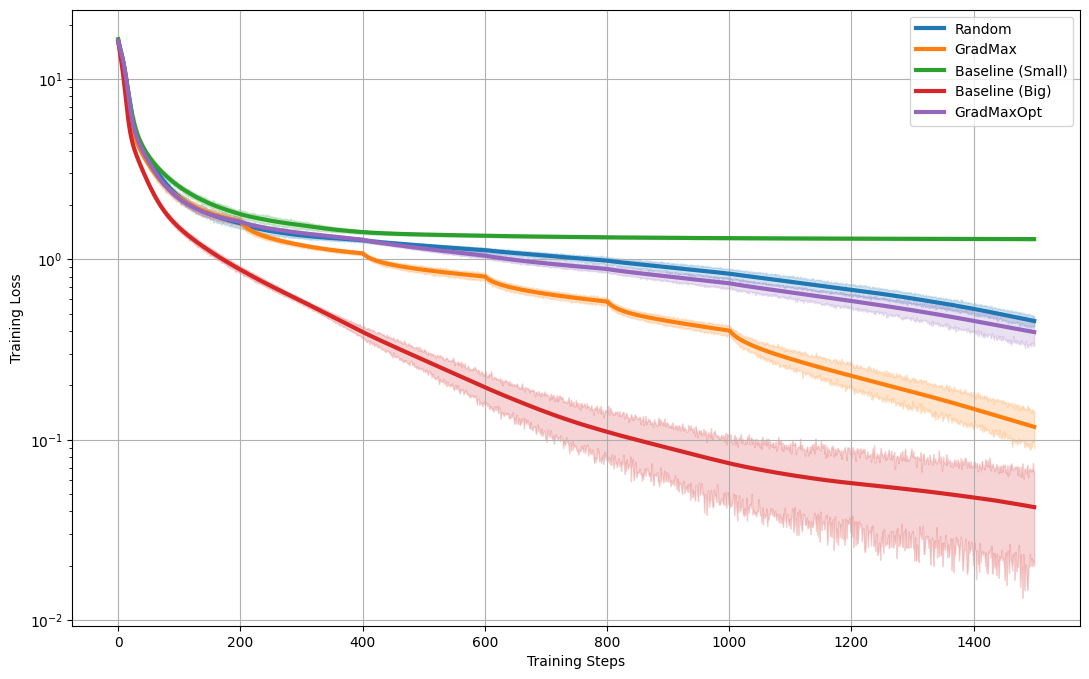

In [ ]:
plot_data(stats=exp_1_stats, 
          methods=exp_1_methods,
          data_key='loss_curves', f_name='mlp_loss',
          ylabel='Training Loss', label_dict=label_tranform_dict,
          xlabel='Training Steps',figsize=(13,8)
          )

As we can see form the figure, the best performance between Random, GradMaxOpt and Gradmax are obtained with this last

#### Adjusted Gradient Norm

Here we compare the gradient norm
of the flattened parameters (both layers) throughout training.

I0920 09:33:00.925318 139971569735552 ticker.py:2422] vmin 0.04153826406124079 vmax 0.9802069110337831
I0920 09:33:00.930695 139971569735552 ticker.py:2473] ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])
I0920 09:33:00.933987 139971569735552 ticker.py:2422] vmin 0.04153826406124079 vmax 0.9802069110337831
I0920 09:33:00.936074 139971569735552 ticker.py:2473] ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])
I0920 09:33:00.939973 139971569735552 ticker.py:2422] vmin 0.04153826406124079 vmax 0.9802069110337831
I0920 09:33:00.943639 139971569735552 ticker.py:2473] ticklocs array([2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01])
I0920 09:33:00.989512 139971569735552 ticker.py:24

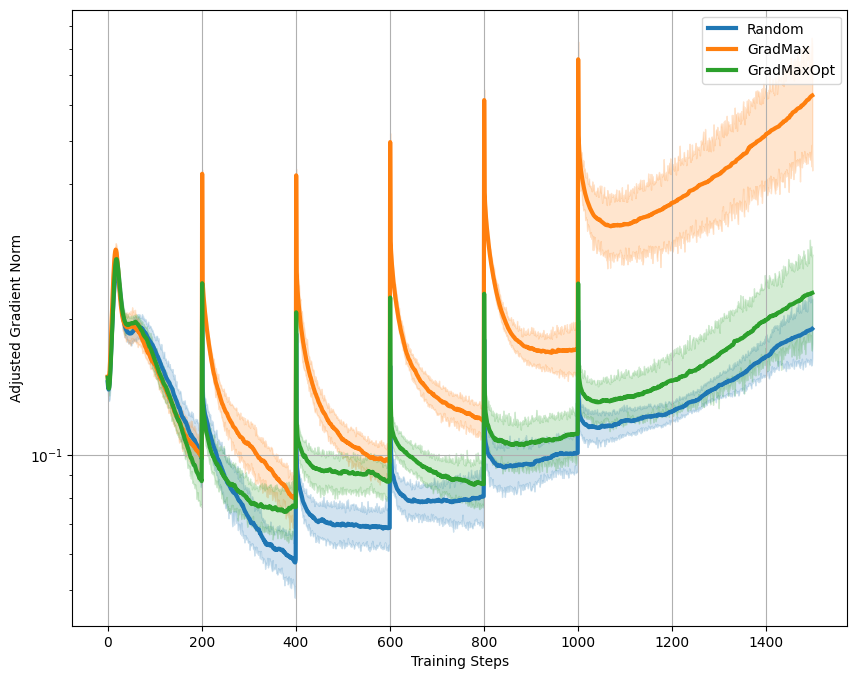

In [ ]:
def normalize_byloss_fn(d, k):
  new_curves = []
  for gns, losses in zip(d[k], d['loss_curves']):
    new_curves.append([gn/loss for gn, loss in zip(gns, losses)])
  return new_curves
  
methods = ['random', 'gradmax', 'gradmax_opt']
plot_data(stats=exp_1_stats, 
          methods=methods, 
          data_key='gnorm_curves', f_name='mlp_gnorm_normalized',
          x_fn=normalize_byloss_fn, ylabel='Adjusted Gradient Norm', xlabel='Training Steps',
          label_dict=label_tranform_dict)

As we can see, the highest gradient norm of the new weights is obtained using GradMax.

#### $||\nabla W_{l}^{new}||$

Here we measure and compare the norm of the gradients with respect to $W_{\ell}^{new}$ after growing a single neuron starting from checkpoints generated during the Random (Random) growth experiments.

In [ ]:
width = PARAMS['width']

growth_ids = range(PARAMS['n_growth'])
growth_types = ['gradmax', 'random', 'gradmax_opt']
#teacher_model = DenseModel([width, width], activation='relu1')
actv_fn='relu1'
n_repeat = PARAMS['n_repeat']
layer_id=0
n_iter=500

stats = exp_1_stats
all_data = exp_1_all_data

is_print=True
all_stats = defaultdict(lambda : defaultdict(list))

x_train, y_train = all_data[0]

def loss_fn(model, *args):
  loss_fn = tf.keras.losses.MeanSquaredError()
  pred = model(x_train)
  return loss_fn(y_train, pred)

def compute_grads(model):
  with tf.GradientTape() as tape:
    loss = loss_fn(model)
  variables = model.trainable_variables
  all_grads = tape.gradient(loss, variables)  
  return all_grads

for j in growth_ids:
  ckpt_name = stats['random']['ckpt_path'][j]

  n_neurons = stats['random']['units_growths'][j]
  #n_neurons=[5+j, 10]

  #ic(n_neurons)
  print(f'Grow {j}', n_neurons)
  for growth_type in growth_types:
    if growth_type == 'gradmax':
      grower = growers.AddGradmax()
    elif growth_type == 'random':
      grower = growers.AddRandom()
    elif growth_type == 'gradmax_opt':
      grower = growers.AddGradmaxOptim()
      grower.optim_fn = lambda: tf.keras.optimizers.Adam(100)
    else:
      print('No growing')
      grower = None
    grower.strategy = tf.distribute.get_strategy()
    dict_key = f'{growth_type}_{j}'
    init_grad_diffs = []
    loss_curves = []
    repeat = n_repeat if growth_type != 'gradmax' else 1
    for i in range(repeat):
      optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
      model = DenseModel(n_neurons, activation=actv_fn)
      ckpt = tf.train.Checkpoint(net=model)
      ckpt.restore(ckpt_name)
      model(x_train[:2])

      grow_layer_tuple = (model.layers_seq[layer_id], model.layers_seq[layer_id+1])
      grad_norm_before = tf.norm(compute_grads(model)[layer_id]).numpy()
      
      c_loss_fn = partial(loss_fn, model)
      grower.loss_fn = c_loss_fn
      grower.compile_fn = c_loss_fn
      grower.grow_neurons(grow_layer_tuple, None, n_new=1)
      c_loss_fn()
      grad_norm_after = tf.norm(compute_grads(model)[layer_id]).numpy()
      
      init_grad_diffs.append(grad_norm_after-grad_norm_before)
      losses = [[], []]
      for epoch in range(n_iter - 1):
        with tf.GradientTape() as tape:
          loss = c_loss_fn()
        variables = model.trainable_variables
        all_grads = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(all_grads, variables))
        losses[0].append(epoch)
        losses[1].append(loss.numpy())
      loss_curves.append(losses)
    if is_print:
      print(growth_type, np.mean(loss_curves[-1][1]), np.max(init_grad_diffs))
    all_stats[dict_key]['grad_diff'] = init_grad_diffs
    all_stats[dict_key]['loss_curves'] = loss_curves

Grow 0 [5, 10]
gradmax 1.4100509 0.4483971


I0920 09:33:30.480503 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.3377175
I0920 09:33:30.481917 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.


random 1.403481 0.35413152


I0920 09:33:30.780125 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.45569828, shape=(), dtype=float32)
I0920 09:33:30.806794 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.44930756, shape=(), dtype=float32)
I0920 09:33:30.833783 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.4501947, shape=(), dtype=float32)
I0920 09:33:30.860534 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.450505, shape=(), dtype=float32)
I0920 09:33:30.887175 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.44996598, shape=(), dtype=float32)
I0920 09:33:30.915439 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 50, loss: tf.Tensor(-0.44776, shape=(), dtype=float32)
I0920 09:33:30.941004 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 60, loss: tf.Tensor(-0.44230643, sha

gradmax_opt 1.4558306 0.35678774
Grow 1 [6, 10]
gradmax 1.1093394 0.39237458


I0920 09:34:30.787697 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.40644
I0920 09:34:30.789135 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.


random 1.1314211 0.27279362


I0920 09:34:31.063365 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.23566422, shape=(), dtype=float32)
I0920 09:34:31.091580 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.39292246, shape=(), dtype=float32)
I0920 09:34:31.118812 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.39652002, shape=(), dtype=float32)
I0920 09:34:31.146835 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.39896962, shape=(), dtype=float32)
I0920 09:34:31.174778 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.4055995, shape=(), dtype=float32)
I0920 09:34:31.201822 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 50, loss: tf.Tensor(-0.41610557, shape=(), dtype=float32)
I0920 09:34:31.229219 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 60, loss: tf.Tensor(-0.42987308

gradmax_opt 1.0647905 0.3661079
Grow 2 [7, 10]
gradmax 0.74301535 0.34619612


I0920 09:35:30.673907 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4590876
I0920 09:35:30.675240 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.


random 0.9060084 0.18125047


I0920 09:35:30.930511 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.20163044, shape=(), dtype=float32)
I0920 09:35:30.957748 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.38479584, shape=(), dtype=float32)
I0920 09:35:30.983452 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.3852181, shape=(), dtype=float32)
I0920 09:35:31.011280 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.3851558, shape=(), dtype=float32)
I0920 09:35:31.037583 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.38496915, shape=(), dtype=float32)
I0920 09:35:31.063963 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 50, loss: tf.Tensor(-0.38476864, shape=(), dtype=float32)
I0920 09:35:31.089131 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 60, loss: tf.Tensor(-0.3846224, 

gradmax_opt 0.7896659 0.33090603
Grow 3 [8, 10]
gradmax 0.6788244 0.39429736


I0920 09:36:30.601790 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.4809766
I0920 09:36:30.602944 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.


random 0.77657264 0.14290577


I0920 09:36:30.880811 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.16088937, shape=(), dtype=float32)
I0920 09:36:30.912585 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.39660972, shape=(), dtype=float32)
I0920 09:36:30.939865 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.39536017, shape=(), dtype=float32)
I0920 09:36:30.967612 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.39576116, shape=(), dtype=float32)
I0920 09:36:30.994673 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.3967886, shape=(), dtype=float32)
I0920 09:36:31.020867 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 50, loss: tf.Tensor(-0.39770138, shape=(), dtype=float32)
I0920 09:36:31.047848 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 60, loss: tf.Tensor(-0.39815745

gradmax_opt 0.69654423 0.36568925
Grow 4 [9, 10]
gradmax 0.5170316 0.44076484


I0920 09:37:30.963678 139971569735552 <ipython-input-104-bf0590791004>:186] Target magnitude: 2.5092716
I0920 09:37:30.965046 139971569735552 <ipython-input-104-bf0590791004>:188] Minimizing loss.


random 0.68995106 0.14237913


I0920 09:37:31.220199 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 0, loss: tf.Tensor(-0.19692743, shape=(), dtype=float32)
I0920 09:37:31.247418 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 10, loss: tf.Tensor(-0.4206131, shape=(), dtype=float32)
I0920 09:37:31.274802 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 20, loss: tf.Tensor(-0.41513655, shape=(), dtype=float32)
I0920 09:37:31.301275 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 30, loss: tf.Tensor(-0.4113581, shape=(), dtype=float32)
I0920 09:37:31.328220 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 40, loss: tf.Tensor(-0.41049927, shape=(), dtype=float32)
I0920 09:37:31.363667 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 50, loss: tf.Tensor(-0.41070914, shape=(), dtype=float32)
I0920 09:37:31.391078 139971569735552 <ipython-input-104-bf0590791004>:213] Gradmax-opt: 60, loss: tf.Tensor(-0.41130263,

gradmax_opt 0.61328954 0.384656


I0920 09:38:02.802662 139971569735552 ticker.py:2422] vmin 0.03032036244757382 vmax 0.5097692933712468
I0920 09:38:02.803894 139971569735552 ticker.py:2473] ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])
I0920 09:38:02.811916 139971569735552 ticker.py:2422] vmin 0.03032036244757382 vmax 0.5097692933712468
I0920 09:38:02.813034 139971569735552 ticker.py:2473] ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])
I0920 09:38:02.817281 139971569735552 ticker.py:2422] vmin 0.03032036244757382 vmax 0.5097692933712468
I0920 09:38:02.819322 139971569735552 ticker.py:2473] ticklocs array([2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01])
I0920 09:38:02.871733 139971569735552 ticker.py:24

[0.06355508, 0.034470316, 0.14237913, 0.10187696, 0.049355675]
[0.4483971, 0.39237458, 0.34619612, 0.39429736, 0.44076484]
[0.38456413, 0.38090792, 0.38158146, 0.38182038, 0.3810342]


I0920 09:38:02.951528 139971569735552 ticker.py:2473] ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])
I0920 09:38:02.960221 139971569735552 ticker.py:2422] vmin 0.03032036244757382 vmax 0.5097692933712468
I0920 09:38:02.961577 139971569735552 ticker.py:2473] ticklocs array([2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01])
I0920 09:38:02.968585 139971569735552 ticker.py:2422] vmin 0.03032036244757382 vmax 0.5097692933712468
I0920 09:38:02.969521 139971569735552 ticker.py:2473] ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])
I0920 09:38:02.973793 139971569735552 ticker.py:2422] vmin 0.03032036244757382 vmax 0.5097692933712468
I0920 09:38:02.976765 139971569735552 ticker.py:24

<Figure size 1600x1000 with 0 Axes>

I0920 09:38:03.531108 139971569735552 ticker.py:2422] vmin 0.03032036244757382 vmax 0.5097692933712468
I0920 09:38:03.532264 139971569735552 ticker.py:2473] ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])
I0920 09:38:03.537263 139971569735552 ticker.py:2422] vmin 0.03032036244757382 vmax 0.5097692933712468
I0920 09:38:03.538675 139971569735552 ticker.py:2473] ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])
I0920 09:38:03.543168 139971569735552 ticker.py:2422] vmin 0.03032036244757382 vmax 0.5097692933712468
I0920 09:38:03.545455 139971569735552 ticker.py:2473] ticklocs array([2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01])
I0920 09:38:03.568653 139971569735552 ticker.py:24

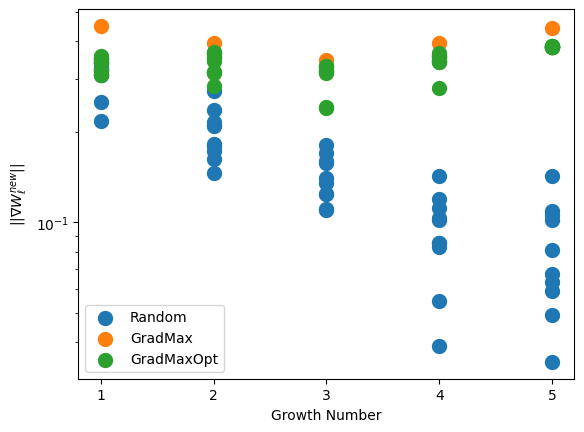

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(16,10))
ax = plt.figure().gca()
for key in ['random', 'gradmax', 'gradmax_opt']:
  y = []
  x = []
  for j in growth_ids:
    dict_key = f'{key}_{j}'
    yy = all_stats[dict_key]['grad_diff']
    x.extend([j+1] * len(yy))
    y.extend(yy) 
  print(y[-5:])
  plt.scatter(x, y, label=label_tranform_dict[key], linewidths=5)
# plt.title('Gradient Gain after Growth')
plt.legend()
plt.xlabel('Growth Number')
plt.ylabel('$||\\nabla W_{\\ell}^{new}||$')
plt.yscale('log')
# plt.ylim(5e-3, 5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
f_path = '/tmp/mlp_graddiff.pdf'
plt.savefig(f_path, dpi=300, bbox_inches = 'tight')
plt.show()


As we can see, GradMax and GradMaxOpt always allow to obtain an higher norm with respect to random new weights initialization

#### $\Delta$ Loss (GradMax vs Random)

Similar to the previous case, we load checkpoints
from each growth step (Growth 1-5) and grow a new neuron using GradMax ($f_g$) and Random ($f_r$).
Then we continue training for 500 steps and plot the difference in training loss (i.e., $L(f_r) − L(f_g)$).

I0920 09:38:48.263901 139971569735552 backend_pdf.py:677] Assigning font /b'F1' = '/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
I0920 09:38:48.296590 139971569735552 backend_pdf.py:719] Embedding font /usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
I0920 09:38:48.297811 139971569735552 backend_pdf.py:726] Writing TrueType font.


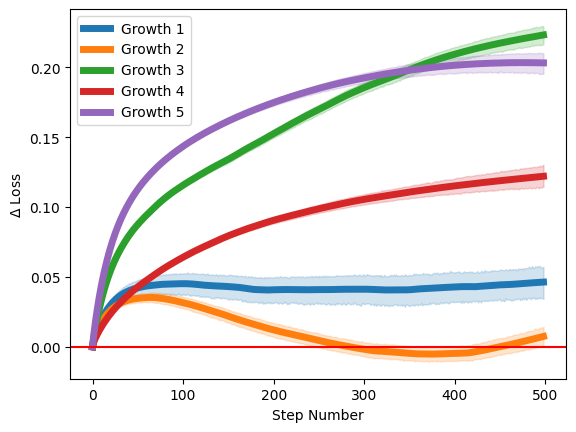

In [ ]:
plt.figure()
for j in growth_ids:
  grad_maxyy = np.array(all_stats[f'gradmax_{j}']['loss_curves'][0][1])
  x = []
  y = []
  for loss_curve in all_stats[f'random_{j}']['loss_curves']:
    xx, yy = loss_curve
    yy = np.array(yy) - grad_maxyy 
    x.extend(xx)
    y.extend(yy) 
  sns.lineplot(x, y, lw=5, label=f'Growth {j+1}', ci=80)
# plt.title('$\Delta$ Loss between GradMax and Random')
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.xlabel('Step Number')
plt.ylabel('$\Delta$ Loss')
f_path = '/tmp/mlp_lossdiff.pdf'
plt.savefig(f_path, dpi=300, bbox_inches = 'tight')
plt.show()


As we can see, most of the time we have a positive difference, namely $L(f_r) > L(f_g)$

## Experiment 2
> **Teacher:** 100:50:10

> **Student:** 100:25:10
>
> We perform 5 growths of 5 neuron every 500 epochs. We then continue the training for 1000 epochs

> **NOTE:** This experiment is almost identical to `Experiment 1`, the only difference is the network dimension

### Parameters

In [ ]:
teacher_width       = 50
student_width       = teacher_width // 2
num_to_add          = 5
n_growth_multiplier = 1
growth_interval     = 500
final_steps         = 1000

in_dim              = teacher_width * 2
out_dim             = 10

lr                  = 0.01

units_teacher       = [teacher_width, out_dim]
units_student_small = (student_width, out_dim)
units_student_big   = (teacher_width, out_dim)

updater_constructor = updaters.RoundRobin   
layers_list_tuple_ids = [(0, 1)]

### Check parameters and run experiments

In [ ]:
if ((teacher_width - student_width) % num_to_add) != 0:
  raise ValueError('teacher width: {} needs to devide by {}'.format(teacher_width, num_to_add))
  
tmp_n_growth =  (teacher_width - student_width) // num_to_add
n_growth = int(tmp_n_growth * n_growth_multiplier)

total_steps = (n_growth-1) * growth_interval + final_steps

PARAMS = {
  'width':                 teacher_width,
  'num_to_add':            num_to_add,
  'final_steps':           final_steps,
  'growth_interval':       growth_interval,
  'optim_type':            'sgd',
  'lr':                    lr,
  'n_repeat':              N_REPEAT,#10,#3,
  'is_print':              True,
  'n_growth_multiplier':   n_growth_multiplier,
  'student_width':         student_width,
  'total_steps':           total_steps,
  'in_dim':                in_dim,
  'out_dim':               out_dim,
  'units_teacher':         units_teacher,
  'units_student_small':   units_student_small,
  'units_student_big':     units_student_big,
  'n_growth':              n_growth,
  'updater_constructor':   updater_constructor,
  'layers_list_tuple_ids': layers_list_tuple_ids,
}


In [ ]:
exp_2_methods = ['random', 'gradmax', 'baseline_small', 'baseline_big', 'gradmax_opt']
exp_2_stats, exp_2_all_data = run_MY_experiments(values=exp_2_methods, key='growth_type', **PARAMS)

ic| get_units(teacher_model): [100, 50, 10]


3000
growth_type: random ********************************************************************************
{'actv_fn': 'relu1',
 'data': None,
 'growth_interval': 500,
 'growth_type': 'random',
 'layers_list_tuple_ids': [(0, 1)],
 'lr': 0.01,
 'n_growth_steps': 5,
 'n_neurons': (25, 10),
 'num_to_add': 5,
 'optim_type': 'sgd',
 'scale': 1.0,
 'start_iter': None,
 'total_steps': 3000,
 'updater_constructor': <class '__main__.RoundRobin'>,
 'use_bias': False}
Training with growth type:  random
Total_steps to perform = 3500
#0 Repetition--------------------------------------------------
student units [100, 25, 10]
student units [100, 30, 10]
student units [100, 35, 10]
student units [100, 40, 10]
student units [100, 45, 10]
student units [100, 50, 10]
#1 Repetition--------------------------------------------------
student units [100, 25, 10]
student units [100, 30, 10]
student units [100, 35, 10]
student units [100, 40, 10]
student units [100, 45, 10]
student units [100, 50, 10]
#2 Repetit

### Plots

In [ ]:
label_tranform_dict = {
    'random': 'Random',
    'gradmax': 'GradMax',
    'gradmax_opt': 'GradMaxOpt',
    'baseline_small': 'Baseline (Small)',
    'baseline_big': 'Baseline (Big)'
}

#### Trainig loss

Here we compare the training loss between three methods used to add neurons to the unique hidden layer of the network:
- **Random**: New weights are initialized randomly
- **GradMax**: New weights are initialized by solving (11) with SVD
- **GradMaxOpt**: New weights are initialized by solving (11) using an iterative method (no SVD)

In addition to them, are also shown the training loss of two non-growth student network:
- **Baseline Small:** Student network fixed at 100:50:10
- **Baseline Big:** Student network fixed at 100:25:10

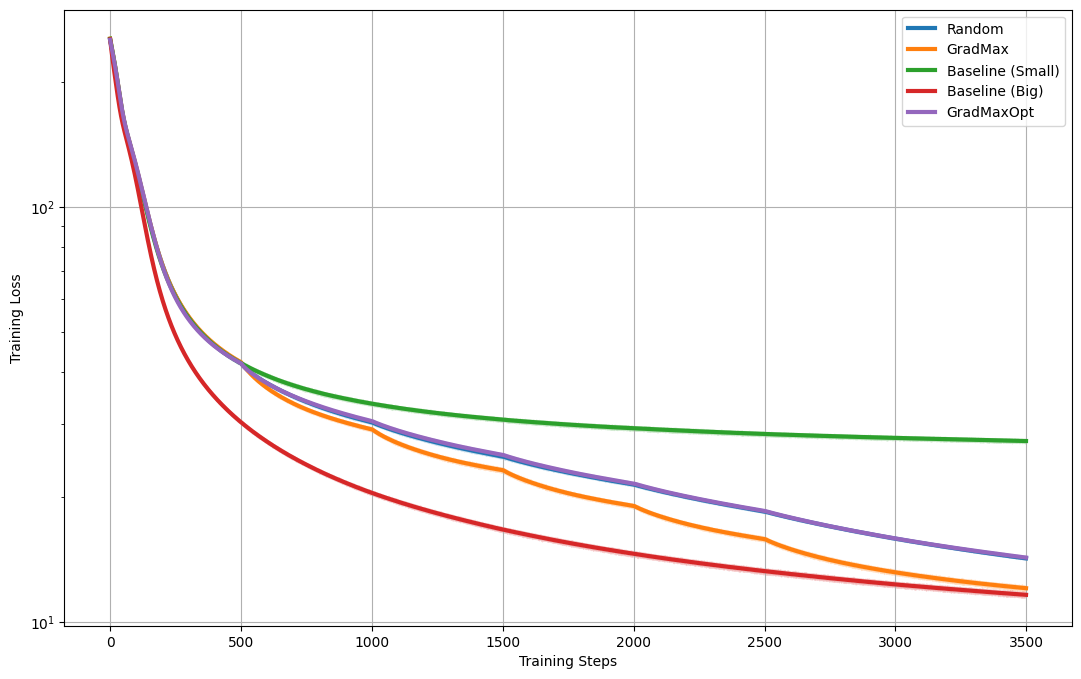

In [ ]:
plot_data(stats=exp_2_stats, 
          methods=exp_2_methods,
          data_key='loss_curves', f_name='mlp_loss',
          ylabel='Training Loss', label_dict=label_tranform_dict,
          xlabel='Training Steps',figsize=(13,8)
          )

## Experiment 3
> **Teacher:** 20:10:10:10:10

> **Student:** 20: 5: 5: 5:10
>
> We perform 15 growths of 1 neuron every 200 epochs. We then continue the training for 500 epochs

> **NOTE:** Unlike the prevoius cases, here the student network has more than one hidden layer, therefore we can test `AutoWhere` updater to choose what layer grow. 
>
> We will compare this new updater with the one implemented by the authors (`RoundRobin`)

In [ ]:
exp_3_methods = ['random', 'gradmax', 'gradmax_opt']

In [ ]:
teacher_width       = 10
student_width       = teacher_width // 2
num_to_add          = 1
n_growth_multiplier = 3
growth_interval     = 200
final_steps         = 500

in_dim              = teacher_width * 2
out_dim             = 10

lr                  = 0.01

units_teacher       = [teacher_width, teacher_width, teacher_width, out_dim]
units_student_small = (student_width, student_width, student_width, out_dim)
units_student_big   = units_teacher

updater_constructor = None

# maximum size of layers that can be growthed
limits_n_units = [10, 10, 10]
layers_list_tuple_ids = [(0, 1), (1, 2), (2, 3)]

assert(len(limits_n_units) == len(layers_list_tuple_ids))

In [ ]:
if ((teacher_width - student_width) % num_to_add) != 0:
  raise ValueError('teacher width: {} needs to devide by {}'.format(teacher_width, num_to_add))

  
tmp_n_growth =  (teacher_width - student_width) // num_to_add
n_growth = int(tmp_n_growth * n_growth_multiplier)

total_steps = (n_growth-1) * growth_interval + final_steps

PARAMS = {
  'width':                 teacher_width,
  'num_to_add':            num_to_add,
  'final_steps':           final_steps,
  'growth_interval':       growth_interval,
  'optim_type':            'sgd',
  'lr':                    lr,
  'n_repeat':              10,#N_REPEAT,#10,#3,
  'is_print':              True,
  'n_growth_multiplier':   n_growth_multiplier,
  'student_width':         student_width,
  'total_steps':           total_steps,
  'in_dim':                in_dim,
  'out_dim':               out_dim,
  'units_teacher':         units_teacher,
  'units_student_small':   units_student_small,
  'units_student_big':     units_student_big,
  'n_growth':              n_growth,
  'updater_constructor':   updater_constructor,
  'layers_list_tuple_ids': layers_list_tuple_ids,
  'limits_n_units':        limits_n_units,
}

### Exp_3_AutoWhere

Here we use `AutoWhere` updater

In [ ]:
PARAMS.update({
    'updater_constructor': updaters.AutoWhere
})

In [ ]:
exp_3_AutoWhere_stats, exp_3_AutoWhere_all_data = run_MY_experiments(values=exp_3_methods, key='growth_type', **PARAMS)

ic| get_units(teacher_model): [20, 10, 10, 10, 10]


3300
growth_type: random ********************************************************************************
{'actv_fn': 'relu1',
 'data': None,
 'growth_interval': 200,
 'growth_type': 'random',
 'layers_list_tuple_ids': [(0, 1), (1, 2), (2, 3)],
 'limits_n_units': [10, 10, 10],
 'lr': 0.01,
 'n_growth_steps': 15,
 'n_neurons': (5, 5, 5, 10),
 'num_to_add': 1,
 'optim_type': 'sgd',
 'scale': 1.0,
 'start_iter': None,
 'total_steps': 3300,
 'updater_constructor': <class '__main__.AutoWhere'>,
 'use_bias': False}
Training with growth type:  random
Total_steps to perform = 3500
#0 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 5, 10]


ic| current_n_units: [9, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 5, 10]


ic| current_n_units: [10, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 6, 10]


ic| current_n_units: [10, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 7, 10]


ic| current_n_units: [10, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 7, 10]


ic| current_n_units: [10, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 8, 10]


ic| current_n_units: [10, 6, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 9, 10]


ic| current_n_units: [10, 6, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 10, 10]


ic| current_n_units: [10, 6, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 10, 10]


ic| current_n_units: [10, 7, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 10, 10]


ic| current_n_units: [10, 8, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 10, 10]


ic| current_n_units: [10, 9, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#1 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 6, 10]


ic| current_n_units: [8, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 6, 10]


ic| current_n_units: [9, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 6, 10]


ic| current_n_units: [10, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 6, 10]


ic| current_n_units: [10, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 6, 10]


ic| current_n_units: [10, 7, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 6, 10]


ic| current_n_units: [10, 8, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 6, 10]


ic| current_n_units: [10, 9, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 7, 10]


ic| current_n_units: [10, 9, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 8, 10]


ic| current_n_units: [10, 9, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 9, 10]


ic| current_n_units: [10, 9, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#2 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 5, 6, 10]


ic| current_n_units: [5, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 5, 7, 10]


ic| current_n_units: [5, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 5, 8, 10]


ic| current_n_units: [5, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 5, 9, 10]


ic| current_n_units: [5, 5, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 5, 10, 10]


ic| current_n_units: [5, 5, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 6, 10, 10]


ic| current_n_units: [5, 6, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 7, 10, 10]


ic| current_n_units: [5, 7, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 8, 10, 10]


ic| current_n_units: [5, 8, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 9, 10, 10]


ic| current_n_units: [5, 9, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 10, 10, 10]


ic| current_n_units: [5, 10, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 10, 10, 10]


ic| current_n_units: [6, 10, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 10, 10, 10]


ic| current_n_units: [7, 10, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 10, 10, 10]


ic| current_n_units: [8, 10, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 10, 10, 10]


ic| current_n_units: [9, 10, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#3 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 5, 6, 10]


ic| current_n_units: [5, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 5, 7, 10]


ic| current_n_units: [5, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 7, 10]


ic| current_n_units: [6, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 8, 10]


ic| current_n_units: [6, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 8, 10]


ic| current_n_units: [7, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 8, 10]


ic| current_n_units: [8, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 8, 10]


ic| current_n_units: [9, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 8, 10]


ic| current_n_units: [10, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 8, 10]


ic| current_n_units: [10, 6, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 8, 10]


ic| current_n_units: [10, 7, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 8, 10]


ic| current_n_units: [10, 8, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 8, 10]


ic| current_n_units: [10, 9, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 9, 10]


ic| current_n_units: [10, 9, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#4 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 6, 10]


ic| current_n_units: [6, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 7, 10]


ic| current_n_units: [6, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 8, 10]


ic| current_n_units: [6, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 8, 10]


ic| current_n_units: [7, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 8, 10]


ic| current_n_units: [8, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 8, 10]


ic| current_n_units: [9, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 8, 10]


ic| current_n_units: [10, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 8, 10]


ic| current_n_units: [10, 6, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 9, 10]


ic| current_n_units: [10, 6, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 10, 10]


ic| current_n_units: [10, 6, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 10, 10]


ic| current_n_units: [10, 7, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 10, 10]


ic| current_n_units: [10, 8, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 10, 10]


ic| current_n_units: [10, 9, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#5 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 5, 10]


ic| current_n_units: [9, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 5, 10]


ic| current_n_units: [10, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 5, 10]


ic| current_n_units: [10, 6, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 6, 10]


ic| current_n_units: [10, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 7, 10]


ic| current_n_units: [10, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 7, 10]


ic| current_n_units: [10, 8, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 7, 10]


ic| current_n_units: [10, 9, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#6 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 6, 10]


ic| current_n_units: [6, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 6, 10]


ic| current_n_units: [7, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 6, 10]


ic| current_n_units: [8, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 6, 10]


ic| current_n_units: [9, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 6, 10]


ic| current_n_units: [10, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 7, 10]


ic| current_n_units: [10, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 7, 10]


ic| current_n_units: [10, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 7, 10]


ic| current_n_units: [10, 8, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 7, 10]


ic| current_n_units: [10, 9, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#7 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 5, 10]


ic| current_n_units: [9, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 5, 10]


ic| current_n_units: [10, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 6, 10]


ic| current_n_units: [10, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 7, 10]


ic| current_n_units: [10, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 7, 10]


ic| current_n_units: [10, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 7, 10]


ic| current_n_units: [10, 8, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 7, 10]


ic| current_n_units: [10, 9, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#8 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 6, 10]


ic| current_n_units: [6, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 7, 10]


ic| current_n_units: [6, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 8, 10]


ic| current_n_units: [6, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 8, 10]


ic| current_n_units: [7, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 8, 10]


ic| current_n_units: [8, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 8, 10]


ic| current_n_units: [9, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 8, 10]


ic| current_n_units: [10, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 8, 10]


ic| current_n_units: [10, 6, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 8, 10]


ic| current_n_units: [10, 7, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 8, 10]


ic| current_n_units: [10, 8, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 8, 10]


ic| current_n_units: [10, 9, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#9 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 5, 10]


ic| current_n_units: [9, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 5, 10]


ic| current_n_units: [10, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 5, 10]


ic| current_n_units: [10, 6, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 5, 10]


ic| current_n_units: [10, 7, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 6, 10]


ic| current_n_units: [10, 7, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 6, 10]


ic| current_n_units: [10, 8, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 6, 10]


ic| current_n_units: [10, 9, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 6, 10]


ic| current_n_units: [10, 10, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
----------------------------------------------------------------------------------------------------
growth_type: gradmax ********************************************************************************
{'actv_fn': 'relu1',
 'data': None,
 'growth_interval': 200,
 'growth_type': 'gradmax',
 'layers_list_tuple_ids': [(0, 1), (1, 2), (2, 3)],
 'limits_n_units': [10, 10, 10],
 'lr': 0.01,
 'n_growth_steps': 15,
 'n_neurons': (5, 5, 5, 10),
 'num_to_add': 1,
 'optim_type': 'sgd',
 'scale': 1.0,
 'start_iter': None,
 'total_steps': 3300,
 'updater_constructor': <class '__main__.AutoWhere'>,
 'use_bias': False}
Training with growth type:  gradmax
Total_steps to perform = 3500
#0 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 6, 5, 10]


ic| current_n_units: [8, 6, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 6, 5, 10]


ic| current_n_units: [9, 6, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 5, 10]


ic| current_n_units: [10, 6, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 6, 10]


ic| current_n_units: [10, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 6, 10]


ic| current_n_units: [10, 7, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 6, 10]


ic| current_n_units: [10, 8, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 7, 10]


ic| current_n_units: [10, 8, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 7, 10]


ic| current_n_units: [10, 9, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#1 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 5, 10]


ic| current_n_units: [9, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 5, 10]


ic| current_n_units: [10, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 6, 10]


ic| current_n_units: [10, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 6, 10]


ic| current_n_units: [10, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 6, 10]


ic| current_n_units: [10, 7, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 7, 10]


ic| current_n_units: [10, 8, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 7, 10]


ic| current_n_units: [10, 9, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#2 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 6, 10]


ic| current_n_units: [8, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 6, 10]


ic| current_n_units: [9, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 6, 10]


ic| current_n_units: [10, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 6, 10]


ic| current_n_units: [10, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 7, 10]


ic| current_n_units: [10, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 8, 10]


ic| current_n_units: [10, 7, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 8, 10]


ic| current_n_units: [10, 8, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 8, 10]


ic| current_n_units: [10, 9, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#3 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 6, 10]


ic| current_n_units: [7, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 6, 6, 10]


ic| current_n_units: [7, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 6, 6, 10]


ic| current_n_units: [8, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 6, 6, 10]


ic| current_n_units: [9, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 6, 10]


ic| current_n_units: [10, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 6, 10]


ic| current_n_units: [10, 7, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 6, 10]


ic| current_n_units: [10, 8, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 7, 10]


ic| current_n_units: [10, 8, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 7, 10]


ic| current_n_units: [10, 9, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 8, 10]


ic| current_n_units: [10, 9, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#4 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 5, 10]


ic| current_n_units: [9, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 5, 10]


ic| current_n_units: [10, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 6, 10]


ic| current_n_units: [10, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 6, 10]


ic| current_n_units: [10, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 6, 10]


ic| current_n_units: [10, 7, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 6, 10]


ic| current_n_units: [10, 8, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 6, 10]


ic| current_n_units: [10, 9, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 6, 10]


ic| current_n_units: [10, 10, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#5 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 6, 10]


ic| current_n_units: [7, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 6, 10]


ic| current_n_units: [8, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 6, 10]


ic| current_n_units: [9, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 6, 10]


ic| current_n_units: [10, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 6, 10]


ic| current_n_units: [10, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 6, 10]


ic| current_n_units: [10, 7, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 7, 10]


ic| current_n_units: [10, 8, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 7, 10]


ic| current_n_units: [10, 9, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#6 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 6, 10]


ic| current_n_units: [6, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 6, 6, 10]


ic| current_n_units: [6, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 6, 6, 10]


ic| current_n_units: [7, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 6, 6, 10]


ic| current_n_units: [8, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 6, 6, 10]


ic| current_n_units: [9, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 6, 7, 10]


ic| current_n_units: [9, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 7, 7, 10]


ic| current_n_units: [9, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 8, 10]


ic| current_n_units: [10, 7, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 8, 10]


ic| current_n_units: [10, 8, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 8, 10]


ic| current_n_units: [10, 9, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#7 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 5, 10]


ic| current_n_units: [9, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 6, 5, 10]


ic| current_n_units: [9, 6, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 5, 10]


ic| current_n_units: [10, 6, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 6, 10]


ic| current_n_units: [10, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 6, 10]


ic| current_n_units: [10, 7, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 6, 10]


ic| current_n_units: [10, 8, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 6, 10]


ic| current_n_units: [10, 9, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 6, 10]


ic| current_n_units: [10, 10, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#8 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 5, 10]


ic| current_n_units: [9, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 5, 10]


ic| current_n_units: [10, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 6, 10]


ic| current_n_units: [10, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 6, 10]


ic| current_n_units: [10, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 6, 10]


ic| current_n_units: [10, 7, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 6, 10]


ic| current_n_units: [10, 8, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 6, 10]


ic| current_n_units: [10, 9, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 6, 10]


ic| current_n_units: [10, 10, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#9 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 5, 6, 10]


ic| current_n_units: [5, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 6, 10]


ic| current_n_units: [6, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 6, 10]


ic| current_n_units: [7, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 6, 10]


ic| current_n_units: [8, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 6, 10]


ic| current_n_units: [9, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 7, 10]


ic| current_n_units: [9, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 6, 7, 10]


ic| current_n_units: [9, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 7, 10]


ic| current_n_units: [10, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 8, 10]


ic| current_n_units: [10, 7, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 8, 10]


ic| current_n_units: [10, 8, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 8, 10]


ic| current_n_units: [10, 9, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
----------------------------------------------------------------------------------------------------
growth_type: gradmax_opt ********************************************************************************
{'actv_fn': 'relu1',
 'data': None,
 'growth_interval': 200,
 'growth_type': 'gradmax_opt',
 'layers_list_tuple_ids': [(0, 1), (1, 2), (2, 3)],
 'limits_n_units': [10, 10, 10],
 'lr': 0.01,
 'n_growth_steps': 15,
 'n_neurons': (5, 5, 5, 10),
 'num_to_add': 1,
 'optim_type': 'sgd',
 'scale': 1.0,
 'start_iter': None,
 'total_steps': 3300,
 'updater_constructor': <class '__main__.AutoWhere'>,
 'use_bias': False}
Training with growth type:  gradmax_opt
Total_steps to perform = 3500
#0 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 6, 10]


ic| current_n_units: [7, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 7, 10]


ic| current_n_units: [7, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 7, 10]


ic| current_n_units: [8, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 7, 10]


ic| current_n_units: [9, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 7, 10]


ic| current_n_units: [10, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 7, 10]


ic| current_n_units: [10, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 7, 10]


ic| current_n_units: [10, 8, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 8, 10]


ic| current_n_units: [10, 8, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 8, 10]


ic| current_n_units: [10, 9, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#1 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 6, 10]


ic| current_n_units: [6, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 7, 10]


ic| current_n_units: [6, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 8, 10]


ic| current_n_units: [6, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 8, 10]


ic| current_n_units: [7, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 8, 10]


ic| current_n_units: [8, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 8, 10]


ic| current_n_units: [9, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 8, 10]


ic| current_n_units: [10, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 9, 10]


ic| current_n_units: [10, 5, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 10, 10]


ic| current_n_units: [10, 5, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 10, 10]


ic| current_n_units: [10, 6, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 10, 10]


ic| current_n_units: [10, 7, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 10, 10]


ic| current_n_units: [10, 8, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 10, 10]


ic| current_n_units: [10, 9, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#2 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 6, 10]


ic| current_n_units: [8, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 7, 10]


ic| current_n_units: [8, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 7, 10]


ic| current_n_units: [9, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 7, 10]


ic| current_n_units: [10, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 7, 10]


ic| current_n_units: [10, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 7, 10]


ic| current_n_units: [10, 8, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 7, 10]


ic| current_n_units: [10, 9, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#3 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 5, 5, 6, 10]


ic| current_n_units: [5, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 6, 10]


ic| current_n_units: [6, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 6, 6, 10]


ic| current_n_units: [6, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 6, 6, 10]


ic| current_n_units: [7, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 6, 6, 10]


ic| current_n_units: [8, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 7, 6, 10]


ic| current_n_units: [8, 7, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 7, 6, 10]


ic| current_n_units: [9, 7, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 6, 10]


ic| current_n_units: [10, 7, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 8, 10]


ic| current_n_units: [10, 7, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 8, 10]


ic| current_n_units: [10, 8, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 9, 10]


ic| current_n_units: [10, 8, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 10, 10]


ic| current_n_units: [10, 8, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 10, 10]


ic| current_n_units: [10, 9, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#4 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 5, 10]


ic| current_n_units: [9, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 5, 10]


ic| current_n_units: [10, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 5, 10]


ic| current_n_units: [10, 6, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 5, 10]


ic| current_n_units: [10, 7, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 5, 10]


ic| current_n_units: [10, 8, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 5, 10]


ic| current_n_units: [10, 9, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 6, 10]


ic| current_n_units: [10, 9, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 6, 10]


ic| current_n_units: [10, 10, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#5 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 6, 10]


ic| current_n_units: [6, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 7, 10]


ic| current_n_units: [6, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 8, 10]


ic| current_n_units: [6, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 9, 10]


ic| current_n_units: [6, 5, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 9, 10]


ic| current_n_units: [7, 5, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 6, 9, 10]


ic| current_n_units: [7, 6, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 7, 9, 10]


ic| current_n_units: [7, 7, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 8, 9, 10]


ic| current_n_units: [7, 8, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 9, 9, 10]


ic| current_n_units: [7, 9, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 9, 9, 10]


ic| current_n_units: [8, 9, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 9, 9, 10]


ic| current_n_units: [9, 9, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 9, 10]


ic| current_n_units: [10, 9, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 10, 10]


ic| current_n_units: [10, 9, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#6 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 5, 10]


ic| current_n_units: [9, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 5, 10]


ic| current_n_units: [10, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 6, 10]


ic| current_n_units: [10, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 7, 10]


ic| current_n_units: [10, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 8, 10]


ic| current_n_units: [10, 5, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 9, 10]


ic| current_n_units: [10, 5, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 10, 10]


ic| current_n_units: [10, 5, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 10, 10]


ic| current_n_units: [10, 6, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 10, 10]


ic| current_n_units: [10, 7, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 10, 10]


ic| current_n_units: [10, 8, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 10, 10]


ic| current_n_units: [10, 9, 10]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#7 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 5, 10]


ic| current_n_units: [8, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 5, 10]


ic| current_n_units: [9, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 5, 10]


ic| current_n_units: [10, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 6, 10]


ic| current_n_units: [10, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 7, 10]


ic| current_n_units: [10, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 7, 10]


ic| current_n_units: [10, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 7, 10]


ic| current_n_units: [10, 8, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 7, 10]


ic| current_n_units: [10, 9, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#8 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 6, 10]


ic| current_n_units: [6, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 6, 10]


ic| current_n_units: [7, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 5, 6, 10]


ic| current_n_units: [8, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 6, 10]


ic| current_n_units: [9, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 5, 7, 10]


ic| current_n_units: [9, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 5, 7, 10]


ic| current_n_units: [10, 5, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 7, 10]


ic| current_n_units: [10, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 7, 10]


ic| current_n_units: [10, 7, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 7, 10]


ic| current_n_units: [10, 8, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 7, 10]


ic| current_n_units: [10, 9, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 7, 10]


ic| current_n_units: [10, 10, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 8, 10]


ic| current_n_units: [10, 10, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
#9 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]


ic| current_n_units: [5, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 6, 5, 5, 10]


ic| current_n_units: [6, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 5, 10]


ic| current_n_units: [7, 5, 5]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 5, 6, 10]


ic| current_n_units: [7, 5, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 7, 6, 6, 10]


ic| current_n_units: [7, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 8, 6, 6, 10]


ic| current_n_units: [8, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 9, 6, 6, 10]


ic| current_n_units: [9, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 6, 10]


ic| current_n_units: [10, 6, 6]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 7, 10]


ic| current_n_units: [10, 6, 7]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 8, 10]


ic| current_n_units: [10, 6, 8]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 6, 9, 10]


ic| current_n_units: [10, 6, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 7, 9, 10]


ic| current_n_units: [10, 7, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 8, 9, 10]


ic| current_n_units: [10, 8, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 9, 9, 10]


ic| current_n_units: [10, 9, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 9, 10]


ic| current_n_units: [10, 10, 9]
ic| limits_n_units: [10, 10, 10]


student units = [20, 10, 10, 10, 10]
----------------------------------------------------------------------------------------------------


#### Plots

In [ ]:
label_tranform_dict = {
    'random': 'Random',
    'gradmax': 'GradMax',
    'gradmax_opt': 'GradMaxOpt',
    'baseline_small': 'Baseline (Small)',
    'baseline_big': 'Baseline (Big)'
}

##### Trainig loss

Here we compare the training loss between three methods used to add neurons to the network:
- **Random**: New weights are initialized randomly
- **GradMax**: New weights are initialized by solving (11) with SVD
- **GradMaxOpt**: New weights are initialized by solving (11) using an iterative method (no SVD)


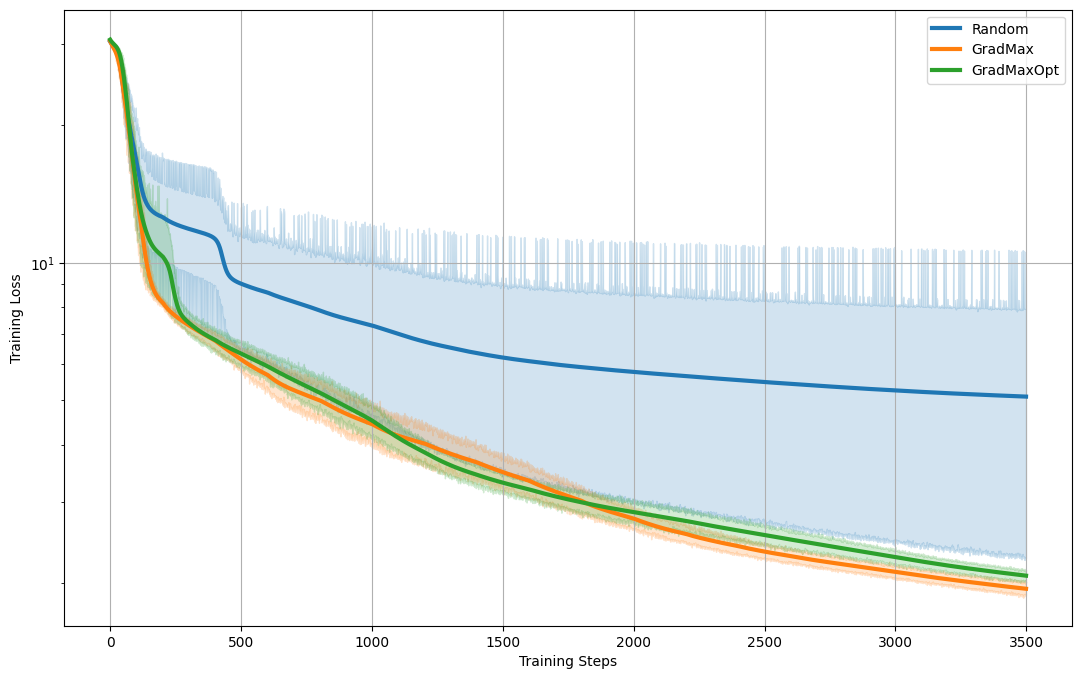

In [ ]:
plot_data(stats=exp_3_AutoWhere_stats, 
          methods=exp_3_methods,
          data_key='loss_curves', f_name='mlp_loss',
          ylabel='Training Loss', label_dict=label_tranform_dict,
          xlabel='Training Steps',figsize=(13,8)
          )

### Exp_3_RoundRobin

Her we use `RoundRobin` updater

In [ ]:
PARAMS.update({
    'updater_constructor': updaters.RoundRobin
})

In [ ]:
exp_3_RoundRobin_stats, exp_3_RoundRobin_all_data = run_MY_experiments(values=exp_3_methods, key='growth_type', **PARAMS)

ic| get_units(teacher_model): [20, 10, 10, 10, 10]


3300
growth_type: random ********************************************************************************
{'actv_fn': 'relu1',
 'data': None,
 'growth_interval': 200,
 'growth_type': 'random',
 'layers_list_tuple_ids': [(0, 1), (1, 2), (2, 3)],
 'limits_n_units': [10, 10, 10],
 'lr': 0.01,
 'n_growth_steps': 15,
 'n_neurons': (5, 5, 5, 10),
 'num_to_add': 1,
 'optim_type': 'sgd',
 'scale': 1.0,
 'start_iter': None,
 'total_steps': 3300,
 'updater_constructor': <class '__main__.RoundRobin'>,
 'use_bias': False}
Training with growth type:  random
Total_steps to perform = 3500
#0 Repetition--------------------------------------------------
student units = [20, 5, 5, 5, 10]
student units = [20, 6, 5, 5, 10]
student units = [20, 6, 6, 5, 10]
student units = [20, 6, 6, 6, 10]
student units = [20, 7, 6, 6, 10]
student units = [20, 7, 7, 6, 10]
student units = [20, 7, 7, 7, 10]
student units = [20, 8, 7, 7, 10]
student units = [20, 8, 8, 7, 10]
student units = [20, 8, 8, 8, 10]
student units =

#### Plots

In [ ]:
label_tranform_dict = {
    'random': 'Random',
    'gradmax': 'GradMax',
    'gradmax_opt': 'GradMaxOpt',
    'baseline_small': 'Baseline (Small)',
    'baseline_big': 'Baseline (Big)'
}

##### Trainig loss

Here we compare the training loss between three methods used to add neurons to the network:
- **Random**: New weights are initialized randomly
- **GradMax**: New weights are initialized by solving (11) with SVD
- **GradMaxOpt**: New weights are initialized by solving (11) using an iterative method (no SVD)


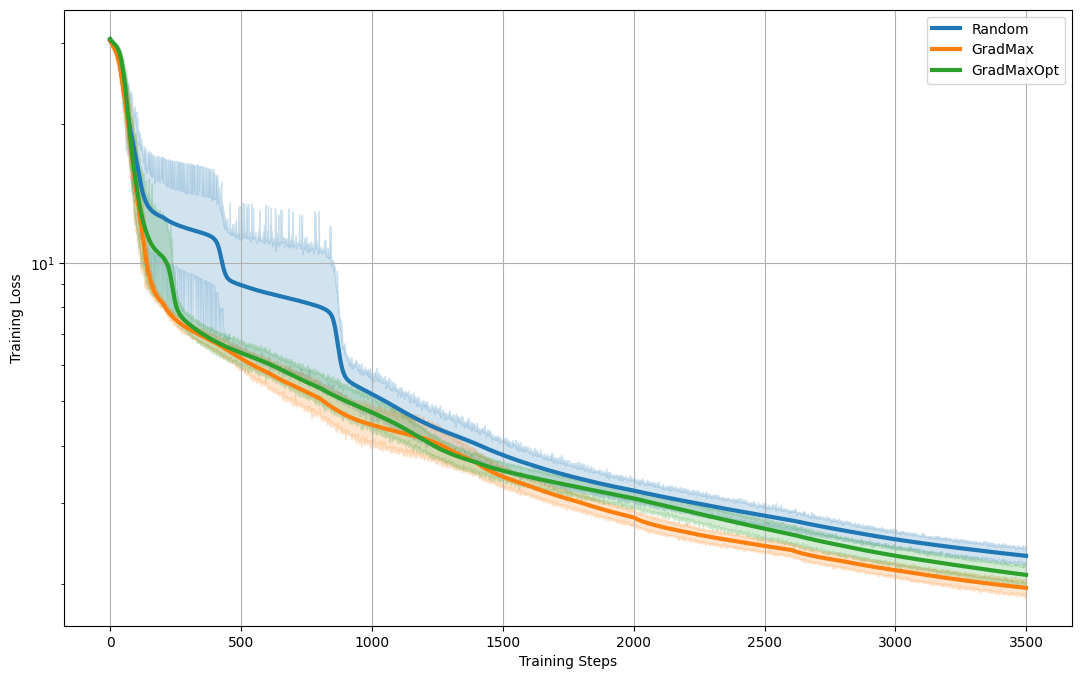

In [ ]:
plot_data(stats=exp_3_RoundRobin_stats, 
          methods=exp_3_methods,
          data_key='loss_curves', f_name='mlp_loss',
          ylabel='Training Loss', label_dict=label_tranform_dict,
          xlabel='Training Steps',figsize=(13,8)
          )

### Loss difference (RoundRobin - AutoWhere)

Here we compute the difference between the training loss when `AutoWhere` and `RoundRobin` updaters are used

In [ ]:
exp_3_stats = dict()
for method in exp_3_AutoWhere_stats:
  exp_3_stats[method] = dict()
  #
  autowhere = np.array(exp_3_AutoWhere_stats[method]['loss_curves'])
  roundrobin = np.array(exp_3_RoundRobin_stats[method]['loss_curves'])
  #
  differences = roundrobin - autowhere
  exp_3_stats[method]['differences_loss_curves'] = differences
  ic(differences.shape)

ic| differences.shape: (10, 3500)
ic| differences.shape: (10, 3500)
ic| differences.shape: (10, 3500)


In [ ]:
np.mean(exp_3_stats['gradmax']['differences_loss_curves'])

0.029934783

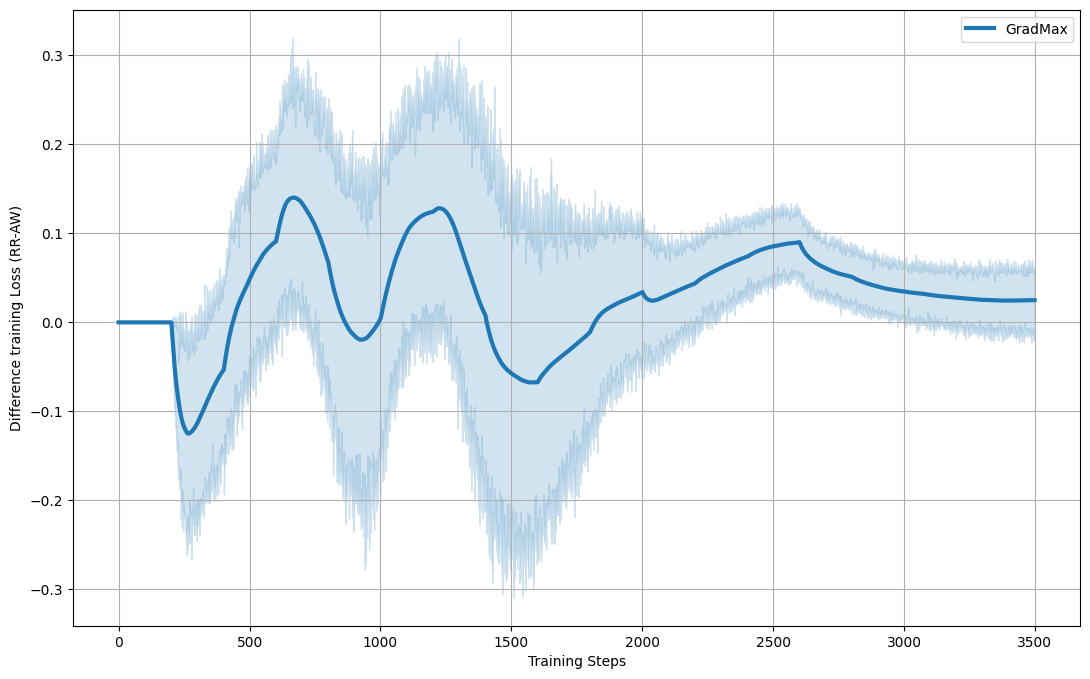

In [ ]:
plot_data(stats=exp_3_stats, 
          methods=['gradmax'],#exp_3_methods,
          data_key='differences_loss_curves', f_name='mlp_loss',
          ylabel='Difference training Loss (RR-AW)', label_dict=label_tranform_dict,
          xlabel='Training Steps',figsize=(13,8), plot_as_log=False
          )

As we can see from the figure, `AutoWhere` allows to obtain a lower loss at the end of the training $RR-AW > 0$

## Experiment 4
> **Teacher:** 100:50:50:50:10

> **Student:** 100: 25: 25: 25:10
>
> We perform 15 growths of 5 neuron every 500 epochs. We then continue the training for 1500 epochs

> **Note:** This experiment is similar to the prevoius one, here we increase the network size.

In [36]:
exp_4_methods = ['random', 'gradmax', 'baseline_small', 'baseline_big', 'gradmax_opt']

In [47]:
teacher_width       = 60
student_width       = teacher_width // 2
num_to_add          = 10
n_growth_multiplier = 3
growth_interval     = 1000
final_steps         = 5000#2500

in_dim              = teacher_width * 2
out_dim             = 10

lr                  = 0.01

units_teacher       = [teacher_width, teacher_width, teacher_width, out_dim]
units_student_small = (student_width, student_width, student_width, out_dim)
units_student_big   = units_teacher

updater_constructor = None

limits_n_units = [50, 50, 50]
layers_list_tuple_ids = [(0, 1), (1, 2), (2, 3)]

assert(len(limits_n_units) == len(layers_list_tuple_ids))

In [48]:
if ((teacher_width - student_width) % num_to_add) != 0:
  raise ValueError('teacher width: {} needs to devide by {}'.format(teacher_width, num_to_add))

  
tmp_n_growth =  (teacher_width - student_width) // num_to_add
n_growth = int(tmp_n_growth * n_growth_multiplier)

total_steps = (n_growth-1) * growth_interval + final_steps

PARAMS = {
  'width':                 teacher_width,
  'num_to_add':            num_to_add,
  'final_steps':           final_steps,
  'growth_interval':       growth_interval,
  'optim_type':            'adam_false',#'sgd',
  'lr':                    lr,
  'n_repeat':              1,#10,#3,#1,#0,#N_REPEAT,#10,#3,
  'is_print':              True,
  'n_growth_multiplier':   n_growth_multiplier,
  'student_width':         student_width,
  'total_steps':           total_steps,
  'in_dim':                in_dim,
  'out_dim':               out_dim,
  'units_teacher':         units_teacher,
  'units_student_small':   units_student_small,
  'units_student_big':     units_student_big,
  'n_growth':              n_growth,
  'updater_constructor':   updater_constructor,
  'layers_list_tuple_ids': layers_list_tuple_ids,
  'limits_n_units':        limits_n_units,
}

PARAMS

{'width': 60,
 'num_to_add': 10,
 'final_steps': 5000,
 'growth_interval': 1000,
 'optim_type': 'adam_false',
 'lr': 0.01,
 'n_repeat': 1,
 'is_print': True,
 'n_growth_multiplier': 3,
 'student_width': 30,
 'total_steps': 13000,
 'in_dim': 120,
 'out_dim': 10,
 'units_teacher': [60, 60, 60, 10],
 'units_student_small': (30, 30, 30, 10),
 'units_student_big': [60, 60, 60, 10],
 'n_growth': 9,
 'updater_constructor': None,
 'layers_list_tuple_ids': [(0, 1), (1, 2), (2, 3)],
 'limits_n_units': [50, 50, 50]}

### Exp_4_AutoWhere

Here we use `AutoWhere` updater

In [49]:
PARAMS.update({
    'updater_constructor': updaters.AutoWhere
})

In [50]:
exp_4_AutoWhere_stats, exp_4_AutoWhere_all_data = run_MY_experiments(values=exp_4_methods, key='growth_type', **PARAMS)

ic| get_units(teacher_model): [120, 60, 60, 60, 10]


13000
growth_type: random ********************************************************************************
{'actv_fn': 'relu1',
 'data': None,
 'growth_interval': 1000,
 'growth_type': 'random',
 'layers_list_tuple_ids': [(0, 1), (1, 2), (2, 3)],
 'limits_n_units': [50, 50, 50],
 'lr': 0.01,
 'n_growth_steps': 9,
 'n_neurons': (30, 30, 30, 10),
 'num_to_add': 10,
 'optim_type': 'adam_false',
 'scale': 1.0,
 'start_iter': None,
 'total_steps': 13000,
 'updater_constructor': <class '__main__.AutoWhere'>,
 'use_bias': False}
Training with growth type:  random
Total_steps to perform = 14000
#0 Repetition--------------------------------------------------
student units = [120, 30, 30, 30, 10]


ic| current_n_units: [30, 30, 30]
ic| limits_n_units: [50, 50, 50]
ic| growth_candidates: [(<__main__.GrowLayer object at 0x7f8e4209bb10>,
                         <__main__.GrowLayer object at 0x7f8e42147650>),
                        (<__main__.GrowLayer object at 0x7f8e42147650>,
                         <__main__.GrowLayer object at 0x7f8e42147d10>),
                        (<__main__.GrowLayer object at 0x7f8e42147d10>,
                         <__main__.GrowLayer object at 0x7f8e421ac710>)]


ValueError: ignored

#### Plots

In [41]:
label_tranform_dict = {
    'random': 'Random',
    'gradmax': 'GradMax',
    'gradmax_opt': 'GradMaxOpt',
    'baseline_small': 'Baseline (Small)',
    'baseline_big': 'Baseline (Big)'
}

##### Trainig loss

Here we compare the training loss between three methods used to add neurons to the network:
- **Random**: New weights are initialized randomly
- **GradMax**: New weights are initialized by solving (11) with SVD
- **GradMaxOpt**: New weights are initialized by solving (11) using an iterative method (no SVD)

In addition to them, are also shown the training loss of two non-growth student network:
- **Baseline Small:** Student network fixed at 100:50:10
- **Baseline Big:** Student network fixed at 100:25:10

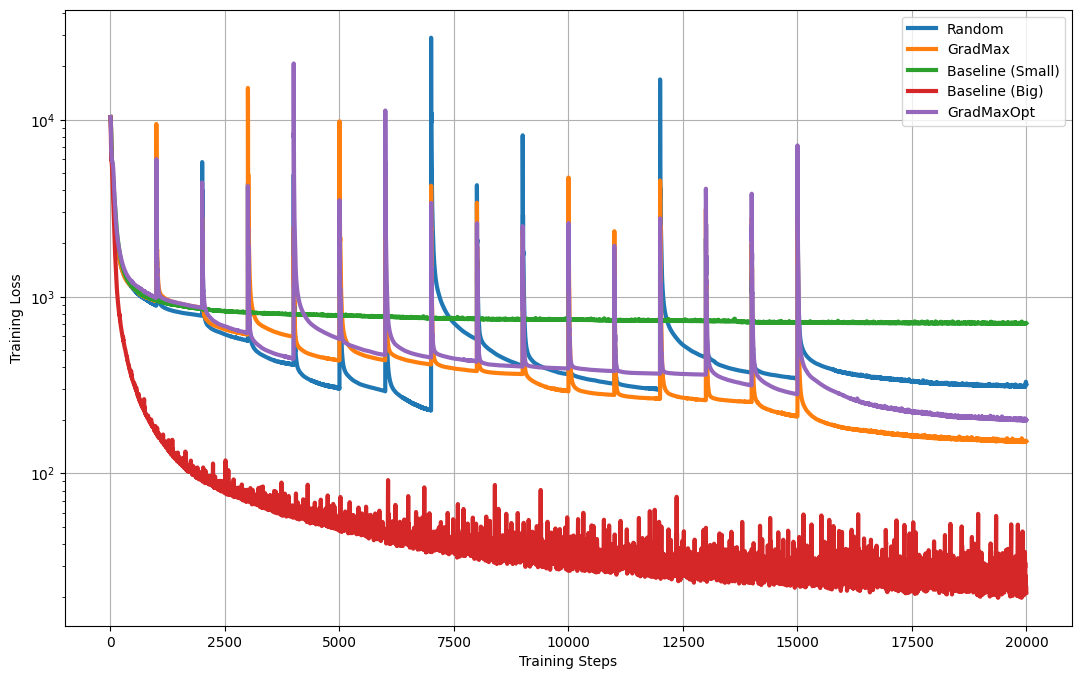

In [42]:
plot_data(stats=exp_4_AutoWhere_stats, 
          methods=exp_4_methods,
          data_key='loss_curves', f_name='mlp_loss',
          ylabel='Training Loss', label_dict=label_tranform_dict,
          xlabel='Training Steps',figsize=(13,8), #plot_as_log=False,
          )

### Exp_4_RoundRobin

Her we use `RoundRobin` updater

In [ ]:
PARAMS.update({
    'updater_constructor': updaters.RoundRobin
})

In [ ]:
exp_4_RoundRobin_stats, exp_4_RoundRobin_all_data = run_MY_experiments(values=exp_4_methods, key='growth_type', **PARAMS)

ic| get_units(teacher_model): [100, 50, 50, 50, 10]


16500
growth_type: random ********************************************************************************
{'actv_fn': 'relu1',
 'data': None,
 'growth_interval': 1000,
 'growth_type': 'random',
 'layers_list_tuple_ids': [(0, 1), (1, 2), (2, 3)],
 'limits_n_units': [50, 50, 50],
 'lr': 0.01,
 'n_growth_steps': 15,
 'n_neurons': (25, 25, 25, 10),
 'num_to_add': 5,
 'optim_type': 'adam_false',
 'scale': 1.0,
 'start_iter': None,
 'total_steps': 16500,
 'updater_constructor': <class '__main__.RoundRobin'>,
 'use_bias': False}
Training with growth type:  random
Total_steps to perform = 17500
#0 Repetition--------------------------------------------------
student units = [100, 25, 25, 25, 10]
student units = [100, 30, 25, 25, 10]
student units = [100, 30, 30, 25, 10]
student units = [100, 30, 30, 30, 10]
student units = [100, 35, 30, 30, 10]
student units = [100, 35, 35, 30, 10]
student units = [100, 35, 35, 35, 10]
student units = [100, 40, 35, 35, 10]
student units = [100, 40, 40, 35, 10]

#### Plots

In [ ]:
label_tranform_dict = {
    'random': 'Random',
    'gradmax': 'GradMax',
    'gradmax_opt': 'GradMaxOpt',
    'baseline_small': 'Baseline (Small)',
    'baseline_big': 'Baseline (Big)'
}

##### Trainig loss

Here we compare the training loss between three methods used to add neurons to the network:
- **Random**: New weights are initialized randomly
- **GradMax**: New weights are initialized by solving (11) with SVD
- **GradMaxOpt**: New weights are initialized by solving (11) using an iterative method (no SVD)

In addition to them, are also shown the training loss of two non-growth student network:
- **Baseline Small:** Student network fixed at 100:50:10
- **Baseline Big:** Student network fixed at 100:25:10

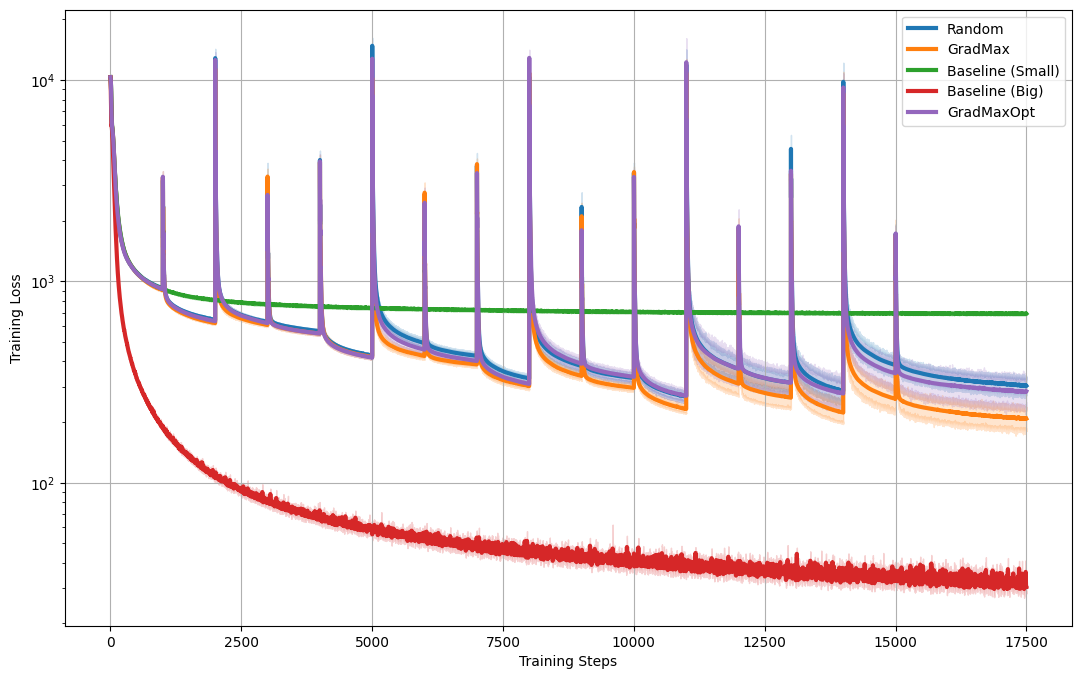

In [ ]:
plot_data(stats=exp_4_RoundRobin_stats, 
          methods=exp_4_methods,
          data_key='loss_curves', f_name='mlp_loss',
          ylabel='Training Loss', label_dict=label_tranform_dict,
          xlabel='Training Steps',figsize=(13,8)
          )

### Loss difference (RoundRobin - AutoWhere)

Here we compute the difference between the training loss when `AutoWhere` and `RoundRobin` updaters are used

In [ ]:
exp_4_stats = dict()
for method in exp_4_AutoWhere_stats:
  exp_4_stats[method] = dict()
  #
  autowhere = np.array(exp_4_AutoWhere_stats[method]['loss_curves'])
  roundrobin = np.array(exp_4_RoundRobin_stats[method]['loss_curves'])
  #
  differences = roundrobin - autowhere
  exp_4_stats[method]['differences_loss_curves'] = differences
  ic(differences.shape)

ic| differences.shape: (10, 17500)
ic| differences.shape: (10, 17500)
ic| differences.shape: (10, 17500)
ic| differences.shape: (10, 17500)
ic| differences.shape: (10, 17500)


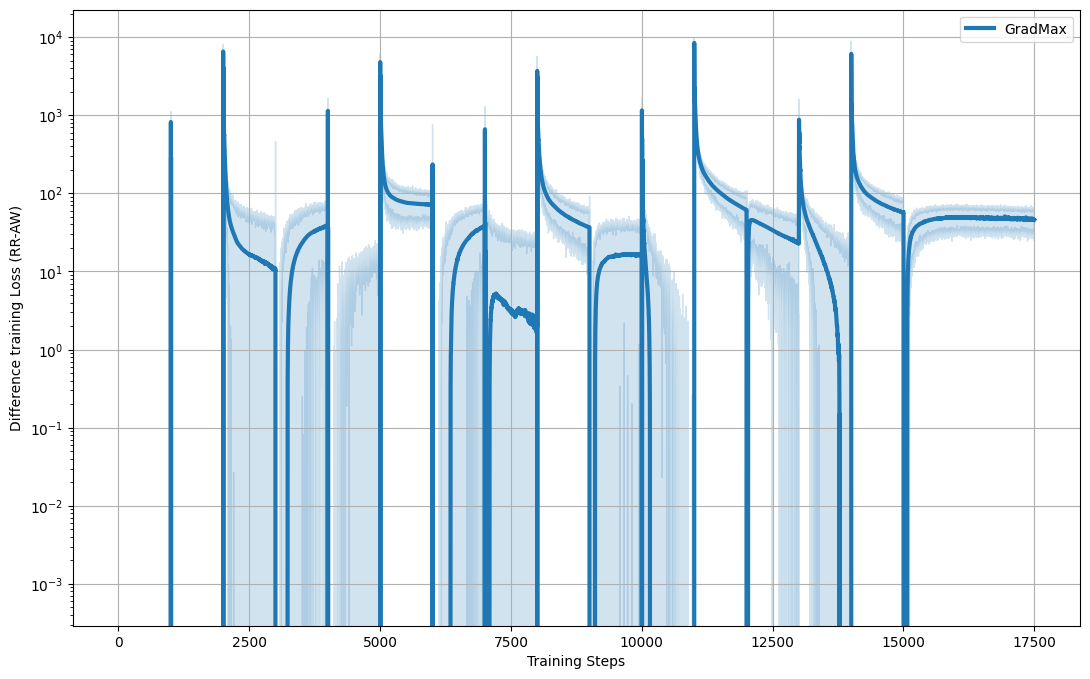

In [ ]:
plot_data(stats=exp_4_stats, 
          methods=['gradmax'],#exp_4_methods,
          data_key='differences_loss_curves', f_name='mlp_loss',
          ylabel='Difference training Loss (RR-AW)', label_dict=label_tranform_dict,
          xlabel='Training Steps',figsize=(13,8)#, plot_as_log=False
          )

Also in this case, `AutoWhere` allows to reach a lower loss at the end of the training ($RR-AW > 0$)

# Image classification - CIFAR-10
In this setting we grow a Wide-Resnet-28-1 network during the training on CIFAR-10 dataset

## Library

### cifar/wide_resnet.py

In [ ]:
# coding=utf-8
# Copyright 2022 GradMax Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Wide Residual Network."""

import enum
import functools
from typing import Any, Dict

#import growneuron.layers as glayers
d = {
      'SUPPORTED_LAYERS': SUPPORTED_LAYERS, 
      'get_activation_fn': get_activation_fn,
      'GrowLayer': GrowLayer,
      'grow_new_layer': grow_new_layer,
      'grow_new_ln_layer': grow_new_ln_layer,
      'grow_new_bn_layer': grow_new_bn_layer,
      'grow_new_dw_layer': grow_new_dw_layer,
      'norm_l2': norm_l2,
      'normalize_l2': normalize_l2,
    }
glayers = SimpleNamespace(**d)


import tensorflow as tf

BatchNormalization = functools.partial(
    tf.keras.layers.BatchNormalization,
    epsilon=1e-5,  # using epsilon and momentum defaults from Torch
    momentum=0.9)

LayerNormalization = functools.partial(
    tf.keras.layers.LayerNormalization,
    epsilon=1e-5)  # using epsilon and momentum defaults from Torch


@enum.unique
class NormalizationType(enum.Enum):
  """Direction along the z-axis."""
  layernorm = 'layernorm'
  batchnorm = ' batchnorm'
  none = 'none'


def Conv2D(filters, seed=None, **kwargs):
  """Conv2D layer that is deterministically initialized."""
  default_kwargs = {
      'kernel_size': 3,
      'padding': 'same',
      'use_bias': False,
      # Note that we need to use the class constructor for the initializer to
      # get deterministic initialization.
      'kernel_initializer': tf.keras.initializers.HeNormal(seed=seed),
  }
  # Override defaults with the passed kwargs.
  default_kwargs.update(kwargs)
  return tf.keras.layers.Conv2D(filters, **default_kwargs)


def basic_block(
    filters,
    block_width,
    normalization_type,
    strides,
    l2,
    seed):
  """Basic residual block of two 3x3 convs.

  Args:
    filters: Number of filters for Conv2D.
    block_width: Multiplies the first filter.
    normalization_type: NormalizationType
    strides: Stride dimensions for Conv2D.
    l2: L2 regularization coefficient.
    seed: random seed used for initialization.

  Returns:
    block_layers: list of sequential layers for the main branch.
    skip_layer: tf.keras.Conv2D or None.
  """
  seeds = tf.random.experimental.stateless_split([seed, seed + 1], 3)[:, 0]

  block_layers = [
      BatchNormalization(beta_regularizer=tf.keras.regularizers.l2(l2),
                         gamma_regularizer=tf.keras.regularizers.l2(l2)),
      tf.keras.layers.Activation('relu'),
      glayers.GrowLayer(
          Conv2D(int(filters*block_width), strides=strides, seed=seeds[0],
                 kernel_regularizer=tf.keras.regularizers.l2(l2)))
  ]
  # Maybe add normalization in between the layers.
  if normalization_type == NormalizationType.batchnorm:
    block_layers.append(glayers.GrowLayer(
        BatchNormalization(beta_regularizer=tf.keras.regularizers.l2(l2),
                           gamma_regularizer=tf.keras.regularizers.l2(l2))))
  elif normalization_type == NormalizationType.layernorm:
    block_layers.append(glayers.GrowLayer(
        LayerNormalization(beta_regularizer=tf.keras.regularizers.l2(l2),
                           gamma_regularizer=tf.keras.regularizers.l2(l2))))
  elif normalization_type == NormalizationType.none:
    pass
  else:
    raise ValueError

  block_layers += [
      # This is to ensure gradient is 1 at 0 for relu.
      tf.keras.layers.Activation(glayers.get_activation_fn('relu1')),
      glayers.GrowLayer(
          Conv2D(filters, strides=1, seed=seeds[1],
                 kernel_regularizer=tf.keras.regularizers.l2(l2)))
  ]

  if strides > 1:
    skip_layer = Conv2D(filters, kernel_size=1, strides=strides, seed=seeds[2],
                        kernel_regularizer=tf.keras.regularizers.l2(l2))
  else:
    skip_layer = None
  return (block_layers, skip_layer)


class WideResnet(tf.keras.Model):
  """Builds Wide ResNet.

  Following Zagoruyko and Komodakis (2016), it accepts a width multiplier on the
  number of filters. Using three groups of residual blocks, the network maps
  spatial features of size 32x32 -> 16x16 -> 8x8.

  Attributes:
    depth: Total number of convolutional layers. "n" in WRN-n-k. It differs from
      He et al. (2015)'s notation which uses the maximum depth of the network
      counting non-conv layers like dense.
    width_multiplier: Integer to multiply the number of typical filters by. "k"
      in WRN-n-k.
    block_width_multiplier: Multiplies the filters in the first conv for each
      block.
    normalization_type: NormalizationType, of the normalization used inside
      blocks.
    num_classes: Number of output classes.
    l2: L2 regularization coefficient.
    seed: random seed used for initialization.

  """

  def __init__(
      self,
      depth,
      width_multiplier,
      block_width_multiplier,
      normalization_type,
      num_classes,
      l2,
      seed = 42
      ):
    super().__init__(name='wide_resnet-{}-{}'.format(depth, width_multiplier))
    l2_reg = tf.keras.regularizers.l2

    seeds = tf.random.experimental.stateless_split([seed, seed + 1], 5)[:, 0]
    if (depth - 4) % 6 != 0:
      raise ValueError('depth should be 6n+4 (e.g., 16, 22, 28, 40).')
    num_blocks = (depth - 4) // 6

    self.conv_stem = Conv2D(16,
                            strides=1,
                            seed=seeds[0],
                            kernel_regularizer=l2_reg(l2))
    self.group_seq = []
    for i, (filters, strides, seed) in enumerate(
        zip([16, 32, 64], [1, 2, 2], seeds[1:4])):
      block_seq = []
      group_seeds = tf.random.experimental.stateless_split(
          [seed, seed + 1], num_blocks)[:, 0]
      for j, group_seed in enumerate(group_seeds):
        block_strides = strides if j == 0 else 1
        block_seq.append(
            basic_block(filters=filters*width_multiplier,
                        block_width=block_width_multiplier,
                        normalization_type=normalization_type,
                        strides=block_strides, l2=l2, seed=group_seed)
            )
      self.group_seq.append(block_seq)

    self.final_layers = [
        BatchNormalization(beta_regularizer=l2_reg(l2),
                           gamma_regularizer=l2_reg(l2)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.AveragePooling2D(pool_size=8),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            num_classes,
            kernel_initializer=tf.keras.initializers.HeNormal(seed=seeds[4]),
            kernel_regularizer=l2_reg(l2),
            bias_regularizer=l2_reg(l2))
    ]

  def call(self, inputs):
    x = self.conv_stem(inputs)
    for block_seq in self.group_seq:
      for block_layers, skip_layer in block_seq:
        y = x
        # Main branch.
        for layer in block_layers:
          y = layer(y)
        # Skip branch
        if skip_layer:
          x = skip_layer(x)
        x = x + y
    for layer in self.final_layers:
      x = layer(x)
    return x


def create_model(
    depth = 22,
    width_multiplier = 1,
    block_width_multiplier = 1.,
    normalization_type = 'batchnorm',
    num_classes = 10,
    l2_coef = 0.0,
    **unused_kwargs):
  """Creates model."""
  normalization_type = NormalizationType[normalization_type]
  model = WideResnet(depth=depth,
                     width_multiplier=width_multiplier,
                     block_width_multiplier=block_width_multiplier,
                     num_classes=num_classes,
                     normalization_type=normalization_type,
                     l2=l2_coef)
  return model

### cifar/vgg.py

In [ ]:
# coding=utf-8
# Copyright 2022 GradMax Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""VGG Network."""

import functools
from typing import Any, Dict

#from growneuron.cifar import wide_resnet
d = {
      'BatchNormalization': BatchNormalization, 
      'LayerNormalization': LayerNormalization,
      'NormalizationType': NormalizationType,
      'Conv2D': Conv2D,
      'basic_block': basic_block,
      'WideResnet': WideResnet,
      'create_model': create_model,
    }
wide_resnet = SimpleNamespace(**d)

#import growneuron.layers as glayers
d = {
      'SUPPORTED_LAYERS': SUPPORTED_LAYERS, 
      'get_activation_fn': get_activation_fn,
      'GrowLayer': GrowLayer,
      'grow_new_layer': grow_new_layer,
      'grow_new_ln_layer': grow_new_ln_layer,
      'grow_new_bn_layer': grow_new_bn_layer,
      'grow_new_dw_layer': grow_new_dw_layer,
      'norm_l2': norm_l2,
      'normalize_l2': normalize_l2,
    }
glayers = SimpleNamespace(**d)

import tensorflow as tf

NormalizationType = wide_resnet.NormalizationType

BatchNormalization = functools.partial(
    tf.keras.layers.BatchNormalization,
    epsilon=1e-5,  # using epsilon and momentum defaults from Torch
    momentum=0.9)

LayerNormalization = functools.partial(
    tf.keras.layers.LayerNormalization,
    epsilon=1e-5)  # using epsilon and momentum defaults from Torch


def Conv2D(filters, seed=None, **kwargs):
  """Conv2D layer that is deterministically initialized."""
  default_kwargs = {
      "kernel_size": 3,
      "padding": "same",
      "use_bias": False,
      # Note that we need to use the class constructor for the initializer to
      # get deterministic initialization.
      "kernel_initializer": tf.keras.initializers.HeNormal(seed=seed),
  }
  # Override defaults with the passed kwargs.
  default_kwargs.update(kwargs)
  return tf.keras.layers.Conv2D(filters, **default_kwargs)


class VGG(tf.keras.Model):
  """Builds a VGG CNN without the FC layers at the end.

  We don't add the FC layers to stay in sync with the implementation in the
  "Firefly Neural Architecture Descent" paper.

  Attributes:
    depth: Use 11 for VGG11, 16 for VGG16, etc.,
    width_multiplier: The number of filters in the first layer
                      ("1" corresponds to 64 filters).
    num_classes: Number of output classes.
    normalization_type: NormalizationType, of the normalization used inside
      blocks.
    l2: L2 regularization coefficient.
    seed: random seed used for initialization.
  """

  def __init__(self,
               depth,
               width_multiplier,
               num_classes,
               normalization_type,
               l2,
               seed = 42):
    super().__init__(name=F"VGG-{depth}-{width_multiplier}")
    l2_reg = tf.keras.regularizers.l2

    rng_seed = [seed, seed + 1]
    assert depth == 11, "Only supporting VGG11 right now"

    # VGG consists of blocks of convs separated by downsampling.
    # Within each block, each conv has of base_width * multiplier filters.
    # This dict maps VGG-xx to a list of blocks.
    architecture = {
        11: [[1], [2], [4, 4], [8, 8], [8, 8]],
        14: [[1, 1], [2, 2], [4, 4], [8, 8], [8, 8]],
        16: [[1, 1], [2, 2], [4, 4, 4], [8, 8, 8], [8, 8, 8]],
        19: [[1, 1], [2, 2], [4, 4, 4, 4], [8, 8, 8, 8], [8, 8, 8, 8]]
    }

    blocklist = architecture[depth]
    base_width = int(64 * width_multiplier)

    downsample = False
    self.layer_list = []
    for block in blocklist:
      for multiplier in block:
        rng_seed, seed = tf.random.experimental.stateless_split(rng_seed)
        self.layer_list.append(glayers.GrowLayer(Conv2D(
            base_width*multiplier, strides=1 if not downsample else 2,
            seed=seed[0],
            kernel_regularizer=tf.keras.regularizers.l2(l2))))
        downsample = False
        self.layer_list.append(tf.keras.layers.Activation(
            glayers.get_activation_fn("relu1")),)
        if normalization_type == NormalizationType.batchnorm:
          self.layer_list.append(glayers.GrowLayer(
              BatchNormalization(
                  beta_regularizer=tf.keras.regularizers.l2(l2),
                  gamma_regularizer=tf.keras.regularizers.l2(l2))))
        elif normalization_type == NormalizationType.layernorm:
          self.layer_list.append(glayers.GrowLayer(
              LayerNormalization(
                  beta_regularizer=tf.keras.regularizers.l2(l2),
                  gamma_regularizer=tf.keras.regularizers.l2(l2))))
        elif normalization_type == NormalizationType.none:
          pass
        else:
          raise ValueError
      downsample = True
    self.layer_list.append(
        glayers.GrowLayer(
            Conv2D(num_classes, strides=2, kernel_regularizer=l2_reg(l2))))
    self.layer_list.append(tf.keras.layers.Flatten())

  def call(self, x):
    for layer in self.layer_list:
      x = layer(x)
    return x

  def get_grow_layer_tuples(self):
    """Gets all groups of layers that need to grow together."""

    grow_layers = [
        i for i, l in enumerate(self.layer_list)
        if (isinstance(l, glayers.GrowLayer) and
            isinstance(l.layer, tf.keras.layers.Conv2D))
    ]

    grow_layer_tuples = []
    for i, j in zip(grow_layers[:-1], grow_layers[1:]):
      # Grow tuples should be in order.
      grow_layer_tuples.append(self.layer_list[i:(j+1)])
    return grow_layer_tuples


def create_model(
    depth = 1,
    width_multiplier = 1,
    num_classes = 10,
    l2_coef = 0.0,
    normalization_type = "batchnorm",
    **unused_kwargs):
  """Creates model."""
  normalization_type = NormalizationType[normalization_type]
  model = VGG(
      depth=depth,
      width_multiplier=width_multiplier,
      num_classes=num_classes,
      normalization_type=normalization_type,
      l2=l2_coef)
  return model

## cifar/data.py

In [ ]:
# coding=utf-8
# Copyright 2022 GradMax Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Data pipeline.

Forked from simclr/tf2 codebase.
"""
from typing import Optional
from absl import logging

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds


def build_input_fn(
    builder,
    global_batch_size,
    topology,
    is_training,
    cache_dataset = True):
  """Build input function.

  Args:
    builder: TFDS builder for specified dataset.
    global_batch_size: Global batch size.
    topology: An instance of `tf.tpu.experimental.Topology` or None.
    is_training: Whether to build in training mode.
    cache_dataset: bool, whether to cache the dataset.

  Returns:
    A function that accepts a dict of params and returns a tuple of images and
    features, to be used as the input_fn in TPUEstimator.
  """

  def _input_fn(input_context):
    """Inner input function."""
    batch_size = input_context.get_per_replica_batch_size(global_batch_size)
    logging.info('Global batch size: %d', global_batch_size)
    logging.info('Per-replica batch size: %d', batch_size)

    def map_fn(image, label):
      """Produces multiple transformations of the same batch."""
      if is_training:
        image_shape = tf.shape(image)
        # Expand the image by 2 pixels, then crop back down to 32x32.
        image = tf.image.resize_with_crop_or_pad(
            image, image_shape[0] + 4, image_shape[1] + 4)
        image = tf.image.random_crop(image, (image_shape[0], image_shape[0], 3))
        image = tf.image.random_flip_left_right(image)
      image = tf.image.convert_image_dtype(image, tf.float32)
      return image, label

    dataset = builder.as_dataset(
        split='train' if is_training else 'test',
        shuffle_files=is_training,
        as_supervised=True)
    logging.info('num_input_pipelines: %d', input_context.num_input_pipelines)
    # The dataset is always sharded by number of hosts.
    # num_input_pipelines is the number of hosts rather than number of cores.
    if input_context.num_input_pipelines > 1:
      dataset = dataset.shard(input_context.num_input_pipelines,
                              input_context.input_pipeline_id)
    if cache_dataset:
      dataset = dataset.cache()
    if is_training:
      dataset = dataset.shuffle(50000)
      dataset = dataset.repeat(-1)
    dataset = dataset.map(
        map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=is_training)
    prefetch_buffer_size = 2 * topology.num_tpus_per_task if topology else 2
    dataset = dataset.prefetch(prefetch_buffer_size)
    return dataset

  return _input_fn



## cifar/main.py

In [ ]:
# coding=utf-8
# Copyright 2022 GradMax Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

r"""Wide ResNet 28-10 on CIFAR-10/100 trained with maximum likelihood.

Hyperparameters differ slightly from the original paper's code
(https://github.com/szagoruyko/wide-residual-networks) as TensorFlow uses, for
example, l2 instead of weight decay, and a different parameterization for SGD's
momentum.

"""

import itertools
import os
import time

from absl import app
from absl import flags
from absl import logging

#from growneuron import growers
#from growneuron import updaters

#from growneuron.cifar import data
d = {
      'build_input_fn': build_input_fn, 
    }
data = SimpleNamespace(**d)

#from growneuron.cifar import vgg
d = {
      'VGG': VGG, 
      'create_model': create_model,
    }
vgg = SimpleNamespace(**d)

#from growneuron.cifar import wide_resnet

#import growneuron.layers as glayers

from ml_collections import config_flags
import tensorflow as tf
import tensorflow_datasets as tfds
import uncertainty_baselines.schedules as ub_schedules
from tensorboard.plugins.hparams import api as hp
import shutil

In [ ]:
logging.set_verbosity(logging.INFO)

In [ ]:
def get_optimizer(optimizer_config, train_epochs, batch_size, steps_per_epoch):
  """Given the config and training arguments returns an optimizer."""
  # Linearly scale learning rate and the decay epochs by vanilla settings.
  base_lr = optimizer_config.base_learning_rate * batch_size / 128
  lr_decay_epochs = [int(fraction * train_epochs)
                     for fraction in optimizer_config.lr_decay_epochs]
  if optimizer_config.decay_type == 'step':
    lr_schedule = ub_schedules.WarmUpPiecewiseConstantSchedule(
        steps_per_epoch,
        base_lr,
        decay_ratio=optimizer_config.lr_decay_ratio,
        decay_epochs=lr_decay_epochs,
        warmup_epochs=optimizer_config.lr_warmup_epochs)
  elif optimizer_config.decay_type == 'cosine':
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        base_lr, train_epochs * steps_per_epoch, alpha=0.0)
  else:
    lr_schedule = base_lr / 100.
    logging.info('No decay used')
  optimizer = tf.keras.optimizers.SGD(lr_schedule,
                                      momentum=optimizer_config.momentum,
                                      nesterov=optimizer_config.nesterov)
  return optimizer

### Configuration

In [ ]:
import ml_collections

config = ml_collections.ConfigDict()

config.optimizer = ml_collections.ConfigDict()
# Base learning rate when total batch size is 128. It is scaled by the ratio
# of the total batch size to 128.
config.optimizer.base_learning_rate = 0.1
# One of 'step', 'cosine'
config.optimizer.decay_type = 'cosine'
config.optimizer.nesterov = True
# Amount to decay learning rate.
config.optimizer.lr_decay_ratio = 0.2
# Epochs to decay learning rate by.
config.optimizer.lr_decay_epochs = [0.3, 0.6, 0.8]
# Number of epochs for a linear warmup to the initial learning rate. Use 0 to'
# do no warmup.
config.optimizer.lr_warmup_epochs = 1
# Optimizer momentum.
config.optimizer.momentum = 0.9
# Following is empty for the baselines and used by the growing algorithms.
config.updater = ml_collections.ConfigDict()
config.updater.carry_optimizer = False
config.is_outgoing_zero = False
config.scale_epochs = False

config.model = ml_collections.ConfigDict()
# L2 regularization coefficient.
config.model.l2_coef = 2e-4
config.model.depth = 28
config.model.width_multiplier = 1
config.model.normalization_type = 'none'
config.model.block_width_multiplier = 0.25

# Number of epochs between saving checkpoints. Use -1 for no checkpoints.
config.checkpoint_interval = 25
# One of  ['cifar10', 'cifar100']
config.dataset = 'cifar10'
# Whether to cache the dataset.
config.cache_dataset = True
# WBatch size per TPU core/GPU. The number of new datapoints gathered per
# batch is this number divided by ensemble_size (we tile the batch by that #
# of times).
config.per_core_batch_size = 128
config.num_cores = 1
config.seed = 8
config.train_epochs = 200
config.log_freq = 200

#

config.model.block_width_multiplier = 1.

In [ ]:
config.updater_type = 'round_robin'
config.grow_type = 'add_random'
config.grow_batch_size = 128
config.grow_epsilon = 0.
config.is_outgoing_zero = False
config.grow_scale_method = 'mean_norm'
config.model.normalization_type = 'none'
config.updater.carry_optimizer = True

# We are aiming 144*200=28800 steps growth period
config.updater.update_frequency = 150
config.updater.start_iteration = 10000
config.scale_epochs = True
# 1 cyle is 12 growth steps.
config.updater.n_growth_steps = 144  # 12 * 12 cycle
# Use one of the following
# config.updater.n_grow = 2
config.updater.n_grow_fraction = 0.25
config.updater.scale = 0.5

In [ ]:
config.data_dir = '/root/tensorflow_datasets/cifar10/3.0.2.'
config.download_data = True
config.output_dir = '/tmp/cifar'
config.collect_profile = False

N_REPEATS = 3

### Training function (main)

In [ ]:
def main(argv):

  history = {
      'epoch': list(),
      'model/count_params': list(),
      'train/loss': list(),
      'train/accuracy': list(),
      'train/negative_log_likelihood': list(),
      'val/accuracy': list(),
      'val/negative_log_likelihood': list(),
  }

  #fmt = '[%(filename)s:%(lineno)s] %(message)s'
  fmt = '%(message)s'
  formatter = logging.PythonFormatter(fmt)
  logging.get_absl_handler().setFormatter(formatter)
  logging.get_absl_handler().python_handler.stream = sys.stdout

  del argv  # unused arg
  #config = FLAGS.config
  FLAGS = config
  tf.io.gfile.makedirs(FLAGS.output_dir)
  logging.info('Saving checkpoints at %s', FLAGS.output_dir)
  tf.random.set_seed(config.seed)

  strategy = tf.distribute.MirroredStrategy()

  ds_builder = tfds.builder(config.dataset)
  if FLAGS.download_data:
    ds_builder.download_and_prepare()
  ds_info = ds_builder.info
  batch_size = config.per_core_batch_size * config.num_cores

  # Scale arguments that depend on 128 batch size total training iterations.
  multiplier = 128. / batch_size
  if hasattr(config.updater, 'update_frequency'):
    config.updater.update_frequency = int(
        config.updater.update_frequency * multiplier)
    config.updater.start_iteration = int(
        config.updater.start_iteration * multiplier)

  train_dataset_size = ds_info.splits['train'].num_examples
  steps_per_epoch = train_dataset_size // batch_size
  logging.info('Steps per epoch %s', steps_per_epoch)
  logging.info('Size of the dataset %s', train_dataset_size)
  steps_per_eval = ds_info.splits['test'].num_examples // batch_size
  num_classes = ds_info.features['label'].num_classes

  train_dataset = strategy.distribute_datasets_from_function(
      data.build_input_fn(ds_builder, batch_size, topology=None,
                          is_training=True,
                          cache_dataset=config.cache_dataset))
  # Grow batches might be different in size.
  grow_batch_size = getattr(config, 'grow_batch_size', batch_size)
  grow_dataset = strategy.distribute_datasets_from_function(
      data.build_input_fn(ds_builder, grow_batch_size, topology=None,
                          is_training=True,
                          cache_dataset=config.cache_dataset))
  test_dataset = strategy.distribute_datasets_from_function(
      data.build_input_fn(ds_builder, batch_size, topology=None,
                          is_training=False,
                          cache_dataset=config.cache_dataset))
  # Scale the trianing epochs to match roughly to big-baseline cost.
  arch_name = config.get('architecture', 'wide-resnet')
  # Maybe create a grower.
  grow_type = getattr(config, 'grow_type', None)
  if grow_type == 'add_random':
    grower = growers.AddRandom()
  elif grow_type == 'add_firefly':
    grower = growers.AddFirefly()
  elif grow_type == 'add_gradmax_opt':
    grower = growers.AddGradmaxOptim()
  elif grow_type == 'add_gradmax':
    grower = growers.AddGradmax()
  else:
    logging.info('No growing')
    grower = None
  
  logging.info(f'grow_type = {grow_type}')
  
  if grower:
    grower.epsilon = config.grow_epsilon
    grower.scale_method = config.grow_scale_method
    grower.is_outgoing_zero = config.is_outgoing_zero

  if config.scale_epochs:
    if arch_name == 'wide-resnet':
      width_scale = config.model.block_width_multiplier
    elif arch_name == 'vgg':
      width_scale = config.model.width_multiplier
    else:
      raise ValueError(f'Unknown architecture: {arch_name}')
    old_epochs = config.train_epochs
    # Adjust the total epochs to match big-baseline training FLOPs.
    if grower:
      config.train_epochs = updaters.adjust_epochs(
          config.train_epochs,
          width_scale,
          config.updater.update_frequency,
          config.updater.start_iteration,
          config.updater.n_growth_steps,
          steps_per_epoch
          )
    else:
      # baseline
      config.train_epochs = config.train_epochs / width_scale
    logging.info('Extended training from %s to %s', old_epochs,
                 config.train_epochs)
  summary_writer = tf.summary.create_file_writer(
      os.path.join(FLAGS.output_dir, 'summaries'))

  with summary_writer.as_default():
    flat_param_dict = {}
    def flat_fn(dic):
      for k, v in dic.items():
        if isinstance(v, dict):
          flat_fn({f'{k}.{k2}': v2 for k2, v2 in v.items()})
        else:
          flat_param_dict[k] = str(v) if isinstance(v, list) else v
    flat_fn(config.to_dict())
    hp.hparams(flat_param_dict)

  grow_layer_tuples = []
  with strategy.scope():
    if arch_name == 'wide-resnet':
      logging.info('Building ResNet model')
      model = wide_resnet.create_model(
          num_classes=num_classes,
          seed=config.seed,
          **config.model)
      for block_seq in model.group_seq:
        for block_layers, _ in block_seq:
          # We need to get all layers between the two grow layers.
          glayer_indices = [i for i, l in enumerate(block_layers)
                            if isinstance(l, glayers.GrowLayer)]
          start_index, end_index = glayer_indices[0], glayer_indices[-1]
          grow_layer_tuples.append(block_layers[start_index:(end_index+1)])
    elif arch_name == 'vgg':
      logging.info('Building VGG model')
      model = vgg.create_model(
          num_classes=num_classes,
          seed=config.seed,
          **config.model)
      grow_layer_tuples = model.get_grow_layer_tuples()
    else:
      raise ValueError(f'Unknown architecture: {arch_name}')
    logging.info('grow_layer_tuples: %s', grow_layer_tuples)
    grow_metrics = {layers[0]: tf.keras.metrics.Sum()
                    for layers in grow_layer_tuples}
    # Initialize the parameters.
    def compile_model_fn():
      model(tf.keras.Input((32, 32, 3)))
    compile_model_fn()
    logging.info('Model input shape: %s', model.input_shape)
    logging.info('Model output shape: %s', model.output_shape)
    logging.info('Model number of weights: %s', model.count_params())
    optimizer = get_optimizer(config.optimizer, config.train_epochs, batch_size,
                              steps_per_epoch)
    train_metrics = {
        'train/negative_log_likelihood':
            tf.keras.metrics.Mean(),
        'train/accuracy':
            tf.keras.metrics.SparseCategoricalAccuracy(),
        'train/loss':
            tf.keras.metrics.Mean(),
    }

    eval_metrics = {
        'test/negative_log_likelihood':
            tf.keras.metrics.Mean(),
        'test/accuracy':
            tf.keras.metrics.SparseCategoricalAccuracy(),
    }
    model.summary()

    checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
    latest_checkpoint = tf.train.latest_checkpoint(FLAGS.output_dir)
    initial_epoch = 0
    if latest_checkpoint:
      # TODO This probably wouldn't work if the networks is grown;
      # so we need to switch to saved models maybe.
      # checkpoint.restore must be within a strategy.scope() so that optimizer
      # slot variables are mirrored.
      checkpoint.restore(latest_checkpoint)
      logging.info('Loaded checkpoint %s', latest_checkpoint)
      initial_epoch = optimizer.iterations.numpy() // steps_per_epoch

    def loss_fn(inputs):
      images, labels = inputs
      logits = model(images, training=True)
      one_hot_labels = tf.one_hot(tf.cast(labels, tf.int32), num_classes)
      loss = tf.reduce_mean(
          tf.keras.losses.categorical_crossentropy(
              one_hot_labels,
              logits,
              from_logits=True))
      scaled_loss = loss / strategy.num_replicas_in_sync
      # Don't add the regularization as unnecessary for zero variables.
      return scaled_loss

    updater_type = getattr(config, 'updater_type', None)
    if updater_type == 'round_robin':
      updater = updaters.RoundRobin(grower, grow_layer_tuples, loss_fn,
                                    compile_model_fn, **config.updater)
    elif updater_type == 'all_at_once':
      updater = updaters.AllAtOnce(grower, grow_layer_tuples, loss_fn,
                                   compile_model_fn, **config.updater)
    elif updater_type == 'auto_where':
      updater = updaters.AutoWhere(grower, grow_layer_tuples, loss_fn,
                                   compile_model_fn, **config.updater)
    else:
      updater = updaters.DummyUpdater(grow_layer_tuples)
    
    logging.info(f"updater = {updater}")

  def get_update_fn(model):
    """Returns Per-Replica update function."""
    # We need to remap this as variable names change when the network is grown.
    variable_mapped_grow_metrics = {
        l.weights[0].name: metric for l, metric in grow_metrics.items()
    }

    @tf.function
    def _update_fn(inputs):
      images, labels = inputs
      with tf.GradientTape() as tape:
        logits = model(images, training=True)
        one_hot_labels = tf.one_hot(tf.cast(labels, tf.int32), num_classes)
        nll_loss = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(
                one_hot_labels,
                logits,
                from_logits=True))
        l2_loss = sum(model.losses)
        loss = nll_loss + l2_loss
        # Scale the loss given the TPUStrategy will reduce sum all gradients.
        scaled_loss = loss / strategy.num_replicas_in_sync
      grads = tape.gradient(scaled_loss, model.trainable_variables)
      # Logging some gradient norms
      for grad, var in zip(grads, model.trainable_variables):
        if var.name in variable_mapped_grow_metrics:
          sq_grad = tf.math.pow(grad, 2)
          variable_mapped_grow_metrics[var.name].update_state(sq_grad)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      train_metrics['train/loss'].update_state(loss)
      train_metrics['train/negative_log_likelihood'].update_state(nll_loss)
      train_metrics['train/accuracy'].update_state(labels, logits)

    return _update_fn

  def train_step(iterator, grow_iterator):
    """Training StepFn."""
    # This allows retracing. We need retrace as model is changing.
    update_fn = get_update_fn(model)
    for _ in tf.range(tf.cast(steps_per_epoch, tf.int32)):
      # Maybe grow.
      is_update = updater.is_update_iteration(optimizer.iterations)
      if is_update:
        logging.info('Growing on iteration: %s', optimizer.iterations.numpy())
        with strategy.scope():
          updater.update_network(batch_data=next(grow_iterator),
                                 optimizer=optimizer)
          compile_model_fn()
        # Regenerate the function so that the model is retracted after growing.
        update_fn = get_update_fn(model)
        logging.info('Model number of weights: %s', model.count_params())
        with summary_writer.as_default():
          logging.info('Widths after growth')
          for name, n_neuron in updater.get_grow_layer_stats():
            logging.info('%s: %d', name, n_neuron)
            tf.summary.scalar(f'n_neurons/{name}', n_neuron,
                              step=optimizer.iterations)
      # Gradient Step.
      strategy.run(update_fn, args=(next(iterator),))
      # Logging
      if is_update or optimizer.iterations % config.get('log_freq', 100) == 1:
        logging.info('Train Loss: %.4f, Accuracy: %.2f%%',
                     train_metrics['train/loss'].result(),
                     train_metrics['train/accuracy'].result() * 100)
        total_results = {name: metric.result() for name, metric in
                         train_metrics.items()}
        total_results['lr'] = optimizer.learning_rate(optimizer.iterations)
        total_results['params/total'] = model.count_params()
        for layer, metric in grow_metrics.items():
          total_results[f'grad/{layer.name}'] = metric.result()
        with summary_writer.as_default():
          for name, result in total_results.items():
            tf.summary.scalar(name, result, step=optimizer.iterations)
        for metric in itertools.chain(train_metrics.values(),
                                      grow_metrics.values()):
          metric.reset_states()

  def test_step(iterator, dataset_split, num_steps):
    """Evaluation StepFn."""
    @tf.function
    def step_fn(inputs):
      """Per-Replica StepFn."""
      images, labels = inputs
      logits = model(images, training=False)
      probs = tf.nn.softmax(logits)
      negative_log_likelihood = tf.reduce_mean(
          tf.keras.losses.sparse_categorical_crossentropy(labels, probs))

      eval_metrics[f'{dataset_split}/negative_log_likelihood'].update_state(
          negative_log_likelihood)
      eval_metrics[f'{dataset_split}/accuracy'].update_state(labels, probs)

    for _ in tf.range(tf.cast(num_steps, tf.int32)):
      strategy.run(step_fn, args=(next(iterator),))

  train_iterator = iter(train_dataset)
  grow_iterator = iter(grow_dataset)

  start_time = time.time()
  tb_callback = None
  if FLAGS.collect_profile:
    tb_callback = tf.keras.callbacks.TensorBoard(
        profile_batch=(100, 2000),
        log_dir=os.path.join(FLAGS.output_dir, 'logs'))
    tb_callback.set_model(model)

  for epoch in range(initial_epoch, config.train_epochs):
    logging.info('Starting to run epoch: %s', epoch)
    if tb_callback:
      tb_callback.on_epoch_begin(epoch)
    train_start_time = time.time()
    train_step(train_iterator, grow_iterator)
    train_ms_per_example = (time.time() - train_start_time) * 1e6 / batch_size

    current_step = (epoch + 1) * steps_per_epoch
    max_steps = steps_per_epoch * config.train_epochs
    time_elapsed = time.time() - start_time
    steps_per_sec = float(current_step) / time_elapsed
    eta_seconds = (max_steps - current_step) / steps_per_sec
    message = ('{:.1%} completion: epoch {:d}/{:d}. {:.1f} steps/s. '
               'ETA: {:.0f} min. Time elapsed: {:.0f} min'.format(
                   current_step / max_steps,
                   epoch + 1,
                   config.train_epochs,
                   steps_per_sec,
                   eta_seconds / 60,
                   time_elapsed / 60))
    logging.info(message)
    if tb_callback:
      tb_callback.on_epoch_end(epoch)

    test_iterator = iter(test_dataset)
    logging.info('Starting to run eval at epoch: %s', epoch)
    test_start_time = time.time()
    test_step(test_iterator, 'test', steps_per_eval)
    test_ms_per_example = (time.time() - test_start_time) * 1e6 / batch_size
    logging.info('Done with eval on')

    logging.info('Test NLL: %.4f, Accuracy: %.2f%%',
                 eval_metrics['test/negative_log_likelihood'].result(),
                 eval_metrics['test/accuracy'].result() * 100)
    total_results = {name: metric.result() for name, metric
                     in eval_metrics.items()}
    total_results['train/ms_per_example'] = train_ms_per_example
    total_results['test/ms_per_example'] = test_ms_per_example
    with summary_writer.as_default():
      for name, result in total_results.items():
        tf.summary.scalar(name, result, step=epoch + 1)

    history['epoch'].append(epoch)
    history['model/count_params'].append(model.count_params())
    ##
    train_loss = train_metrics['train/loss'].result().numpy()
    history['train/loss'].append(train_loss)
    #
    train_nll = train_metrics['train/negative_log_likelihood'].result().numpy()
    history['train/negative_log_likelihood'].append(train_nll)
    #
    train_acc = train_metrics['train/accuracy'].result().numpy()
    history['train/accuracy'].append(train_acc)
    ##
    val_nll = eval_metrics['test/negative_log_likelihood'].result().numpy()
    history['val/negative_log_likelihood'].append(val_nll)
    #
    val_acc = eval_metrics['test/accuracy'].result().numpy()
    history['val/accuracy'].append(val_acc)

    for metric in eval_metrics.values():
      metric.reset_states()

    if (config.checkpoint_interval > 0 and
        (epoch + 1) % config.checkpoint_interval == 0):
      checkpoint_name = checkpoint.save(
          os.path.join(FLAGS.output_dir, 'checkpoint'))
      logging.info('Saved checkpoint to %s', checkpoint_name)

  final_checkpoint_name = checkpoint.save(
      os.path.join(FLAGS.output_dir, 'checkpoint'))
  logging.info('Saved last checkpoint to %s', final_checkpoint_name)
  return history

#if __name__ == '__main__':
#  app.run(main)

### Mount on drive to save intermedial results

> **NOTE:** Each test required about 6hrs, therefore we cannot perform all of them in the same Google Colab session

In [ ]:
from google.colab import drive

MOUNT_POINT = '/content/gdrive' 
drive.mount(MOUNT_POINT,  force_remount=True)
MOUNT_POINT += "/My Drive"

Mounted at /content/gdrive


In [ ]:
import os 

DIR_ROOT = os.path.join(MOUNT_POINT, "5.2/NN")

### Tests

In [ ]:
multiple_runs_history_random = dict()
multiple_runs_history_gradmax_rr = dict()
multiple_runs_history_gradmax_aw = dict()

#### Random + RoundRobin

In [ ]:
config.updater_type = 'round_robin'
config.grow_type = 'add_random'

for i in range(N_REPEATS):
  print(colored(f"Start #{i} repeation", 'green'))
  #
  if os.path.isdir(config.output_dir):
    shutil.rmtree(config.output_dir)
  history = main(sys.argv)
  #
  for key in history:
    if not key in multiple_runs_history_random.keys():
      multiple_runs_history_random[key] = list()
    multiple_runs_history_random[key].append(history[key])

INFO:absl:Saving checkpoints at /tmp/cifar


Start #0 repeation


INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmpmwrjevsptfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /root/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.7f8653ab2e504e2ab97ce79cbc4d301d...


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

INFO:absl:Done writing cifar10-train.tfrecord. Number of examples: 50000 (shards: [50000])


Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing cifar10-test.tfrecord. Number of examples: 10000 (shards: [10000])
INFO:absl:Steps per epoch 390
INFO:absl:Size of the dataset 50000
INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:grow_type = add_random
INFO:absl:Extended training from 200 to 200
INFO:absl:Building ResNet model
INFO:absl:grow_layer_tuples: [[<__main__.GrowLayer object at 0x7fac5e0f7310>, <keras.layers.core.activation.Activation object at 0x7fac5e039790>, <__main__.GrowLayer object at 0x7fac4699f350>], [<__main__.GrowLayer object at 0x7fac469a6250>, <keras.layers.core.activation.Activation object at 0x7fac5e048e90>, <__main__.GrowLayer object at 0x7fac469a6b90>], [<__main__.GrowLayer object at 0x7fac5e048fd0>, <keras.layers.core.activation.Activation object at 0x7facdbf

Model: "wide_resnet-28-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  432       
                                                                 
 batch_normalization (BatchN  multiple                 64        
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 glayer_conv2d_1 (GrowLayer)  multiple                 0 (unused)
                                                                 
 activation_1 (Activation)   multiple                  0         
                                                                 
 glayer_conv2d_2 (GrowLayer)  multiple                 0 (unused)
                                                  

INFO:absl:updater = <__main__.RoundRobin object at 0x7fac46d664d0>
INFO:absl:Starting to run epoch: 0
INFO:absl:Train Loss: 3.0491, Accuracy: 10.94%
INFO:absl:Train Loss: 2.1056, Accuracy: 40.02%
INFO:absl:0.5% completion: epoch 1/200. 10.9 steps/s. ETA: 119 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 0
INFO:absl:Done with eval on
INFO:absl:Test NLL: 1.2990, Accuracy: 52.94%
INFO:absl:Starting to run epoch: 1
INFO:absl:Train Loss: 1.6569, Accuracy: 55.23%
INFO:absl:Train Loss: 1.4557, Accuracy: 61.93%
INFO:absl:1.0% completion: epoch 2/200. 13.9 steps/s. ETA: 92 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 1
INFO:absl:Done with eval on
INFO:absl:Test NLL: 1.3209, Accuracy: 53.64%
INFO:absl:Starting to run epoch: 2
INFO:absl:Train Loss: 1.3402, Accuracy: 65.08%
INFO:absl:Train Loss: 1.2469, Accuracy: 67.68%
INFO:absl:1.5% completion: epoch 3/200. 15.5 steps/s. ETA: 83 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 2
INFO:absl

Start #1 repeation


INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:grow_type = add_random
INFO:absl:Extended training from 200 to 200
INFO:absl:Building ResNet model
INFO:absl:grow_layer_tuples: [[<__main__.GrowLayer object at 0x7fab3c95d510>, <keras.layers.core.activation.Activation object at 0x7fab3c95d4d0>, <__main__.GrowLayer object at 0x7fab3cd5d410>], [<__main__.GrowLayer object at 0x7fac1e9e58d0>, <keras.layers.core.activation.Activation object at 0x7fab9e4e8fd0>, <__main__.GrowLayer object at 0x7fab3ca5cf10>], [<__main__.GrowLayer object at 0x7fab3c89c0d0>, <keras.layers.core.activation.Activation object at 0x7fab3c8

Model: "wide_resnet-28-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          multiple                  432       
                                                                 
 batch_normalization_13 (Bat  multiple                 64        
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  multiple                  0         
                                                                 
 glayer_conv2d_28 (GrowLayer  multiple                 0 (unused)
 )                                                               
                                                                 
 activation_26 (Activation)  multiple                  0         
                                                                 
 glayer_conv2d_29 (GrowLayer  multiple            

INFO:absl:updater = <__main__.RoundRobin object at 0x7fab3ca23410>
INFO:absl:Starting to run epoch: 0
INFO:absl:Train Loss: 3.0469, Accuracy: 11.72%
INFO:absl:Train Loss: 2.1104, Accuracy: 39.80%
INFO:absl:0.5% completion: epoch 1/200. 16.4 steps/s. ETA: 79 min. Time elapsed: 0 min
INFO:absl:Starting to run eval at epoch: 0
INFO:absl:Done with eval on
INFO:absl:Test NLL: 1.2719, Accuracy: 53.48%
INFO:absl:Starting to run epoch: 1
INFO:absl:Train Loss: 1.6564, Accuracy: 55.27%
INFO:absl:Train Loss: 1.4653, Accuracy: 61.57%
INFO:absl:1.0% completion: epoch 2/200. 17.7 steps/s. ETA: 73 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 1
INFO:absl:Done with eval on
INFO:absl:Test NLL: 1.2858, Accuracy: 53.85%
INFO:absl:Starting to run epoch: 2
INFO:absl:Train Loss: 1.3522, Accuracy: 64.32%
INFO:absl:Train Loss: 1.2509, Accuracy: 67.51%
INFO:absl:1.5% completion: epoch 3/200. 18.4 steps/s. ETA: 70 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 2
INFO:absl:

Start #2 repeation


INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:grow_type = add_random
INFO:absl:Extended training from 200 to 200
INFO:absl:Building ResNet model
INFO:absl:grow_layer_tuples: [[<__main__.GrowLayer object at 0x7fab166afa50>, <keras.layers.core.activation.Activation object at 0x7fab16aaeb50>, <__main__.GrowLayer object at 0x7fab168c0050>], [<__main__.GrowLayer object at 0x7fab9eb0a990>, <keras.layers.core.activation.Activation object at 0x7fab16c134d0>, <__main__.GrowLayer object at 0x7fab3c2aeb50>], [<__main__.GrowLayer object at 0x7fac1f20d610>, <keras.layers.core.activation.Activation object at 0x7fab9e7

Model: "wide_resnet-28-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          multiple                  432       
                                                                 
 batch_normalization_26 (Bat  multiple                 64        
 chNormalization)                                                
                                                                 
 activation_50 (Activation)  multiple                  0         
                                                                 
 glayer_conv2d_55 (GrowLayer  multiple                 0 (unused)
 )                                                               
                                                                 
 activation_51 (Activation)  multiple                  0         
                                                                 
 glayer_conv2d_56 (GrowLayer  multiple            

INFO:absl:updater = <__main__.RoundRobin object at 0x7fab167fbfd0>
INFO:absl:Starting to run epoch: 0
INFO:absl:Train Loss: 3.0487, Accuracy: 12.50%
INFO:absl:Train Loss: 2.1054, Accuracy: 39.64%
INFO:absl:0.5% completion: epoch 1/200. 16.0 steps/s. ETA: 81 min. Time elapsed: 0 min
INFO:absl:Starting to run eval at epoch: 0
INFO:absl:Done with eval on
INFO:absl:Test NLL: 1.4493, Accuracy: 49.98%
INFO:absl:Starting to run epoch: 1
INFO:absl:Train Loss: 1.6453, Accuracy: 55.59%
INFO:absl:Train Loss: 1.4646, Accuracy: 61.12%
INFO:absl:1.0% completion: epoch 2/200. 17.4 steps/s. ETA: 74 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 1
INFO:absl:Done with eval on
INFO:absl:Test NLL: 1.1282, Accuracy: 59.33%
INFO:absl:Starting to run epoch: 2
INFO:absl:Train Loss: 1.3559, Accuracy: 64.48%
INFO:absl:Train Loss: 1.2602, Accuracy: 67.16%
INFO:absl:1.5% completion: epoch 3/200. 18.0 steps/s. ETA: 71 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 2
INFO:absl:

In [ ]:
filename = os.path.join(DIR_ROOT, "multiple_runs_history_random.pickle")
save_object(filename, multiple_runs_history_random)

#### GradMax + RoundRobin

In [ ]:
config.updater_type = 'round_robin'
config.grow_type = 'add_gradmax'

for i in range(N_REPEATS):
  print(colored(f"Start #{i} repeation", 'green'))
  #
  if os.path.isdir(config.output_dir):
    shutil.rmtree(config.output_dir)
  history = main(sys.argv)
  #
  for key in history:
    if not key in multiple_runs_history_gradmax_rr.keys():
      multiple_runs_history_gradmax_rr[key] = list()
    multiple_runs_history_gradmax_rr[key].append(history[key])

INFO:absl:Saving checkpoints at /tmp/cifar


Start #0 repeation


INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmpkgko4ss4tfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /root/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.6186d9d17ba84b0997cef78671c29981...


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

INFO:absl:Done writing cifar10-train.tfrecord. Number of examples: 50000 (shards: [50000])


Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing cifar10-test.tfrecord. Number of examples: 10000 (shards: [10000])
INFO:absl:Steps per epoch 390
INFO:absl:Size of the dataset 50000
INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:grow_type = add_gradmax
INFO:absl:Extended training from 200 to 200
INFO:absl:Building ResNet model
INFO:absl:grow_layer_tuples: [[<__main__.GrowLayer object at 0x7fd94591fdd0>, <keras.layers.core.activation.Activation object at 0x7fd9d0295150>, <__main__.GrowLayer object at 0x7fd9d0295610>], [<__main__.GrowLayer object at 0x7fd945a3a610>, <keras.layers.core.activation.Activation object at 0x7fd945813510>, <__main__.GrowLayer object at 0x7fd945a41090>], [<__main__.GrowLayer object at 0x7fd945a41e90>, <keras.layers.core.activation.Activation object at 0x7fd945

Model: "wide_resnet-28-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  432       
                                                                 
 batch_normalization (BatchN  multiple                 64        
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 glayer_conv2d_1 (GrowLayer)  multiple                 0 (unused)
                                                                 
 activation_1 (Activation)   multiple                  0         
                                                                 
 glayer_conv2d_2 (GrowLayer)  multiple                 0 (unused)
                                                  

INFO:absl:updater = <__main__.RoundRobin object at 0x7fd945b159d0>
INFO:absl:Starting to run epoch: 0
INFO:absl:Train Loss: 3.0551, Accuracy: 10.94%
INFO:absl:Train Loss: 2.0977, Accuracy: 40.59%
INFO:absl:0.5% completion: epoch 1/200. 12.8 steps/s. ETA: 101 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 0
INFO:absl:Done with eval on
INFO:absl:Test NLL: 1.2545, Accuracy: 55.67%
INFO:absl:Starting to run epoch: 1
INFO:absl:Train Loss: 1.6428, Accuracy: 55.73%
INFO:absl:Train Loss: 1.4573, Accuracy: 61.82%
INFO:absl:1.0% completion: epoch 2/200. 16.5 steps/s. ETA: 78 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 1
INFO:absl:Done with eval on
INFO:absl:Test NLL: 1.0505, Accuracy: 62.31%
INFO:absl:Starting to run epoch: 2
INFO:absl:Train Loss: 1.3463, Accuracy: 64.64%
INFO:absl:Train Loss: 1.2579, Accuracy: 67.13%
INFO:absl:1.5% completion: epoch 3/200. 18.5 steps/s. ETA: 69 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 2
INFO:absl

Start #1 repeation


INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:grow_type = add_gradmax
INFO:absl:Extended training from 200 to 200
INFO:absl:Building ResNet model
INFO:absl:grow_layer_tuples: [[<__main__.GrowLayer object at 0x7fd8ac381f90>, <keras.layers.core.activation.Activation object at 0x7fd85e031a90>, <__main__.GrowLayer object at 0x7fd85e031d10>], [<__main__.GrowLayer object at 0x7fd8ac077590>, <keras.layers.core.activation.Activation object at 0x7fd91dd613d0>, <__main__.GrowLayer object at 0x7fd85ec9a390>], [<__main__.GrowLayer object at 0x7fd85e72f990>, <keras.layers.core.activation.Activation object at 0x7fd89c

Model: "wide_resnet-28-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_171 (Conv2D)         multiple                  432       
                                                                 
 batch_normalization_13 (Bat  multiple                 64        
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  multiple                  0         
                                                                 
 glayer_conv2d_172 (GrowLaye  multiple                 0 (unused)
 r)                                                              
                                                                 
 activation_26 (Activation)  multiple                  0         
                                                                 
 glayer_conv2d_173 (GrowLaye  multiple            

INFO:absl:updater = <__main__.RoundRobin object at 0x7fd85e63e910>
INFO:absl:Starting to run epoch: 0
INFO:absl:Train Loss: 3.0489, Accuracy: 11.72%
INFO:absl:Train Loss: 2.1155, Accuracy: 39.23%
INFO:absl:0.5% completion: epoch 1/200. 18.9 steps/s. ETA: 68 min. Time elapsed: 0 min
INFO:absl:Starting to run eval at epoch: 0
INFO:absl:Done with eval on
INFO:absl:Test NLL: 1.2411, Accuracy: 54.58%
INFO:absl:Starting to run epoch: 1
INFO:absl:Train Loss: 1.6691, Accuracy: 54.95%
INFO:absl:Train Loss: 1.4804, Accuracy: 60.65%
INFO:absl:1.0% completion: epoch 2/200. 20.8 steps/s. ETA: 62 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 1
INFO:absl:Done with eval on
INFO:absl:Test NLL: 1.0550, Accuracy: 61.81%
INFO:absl:Starting to run epoch: 2
INFO:absl:Train Loss: 1.3626, Accuracy: 63.96%
INFO:absl:Train Loss: 1.2630, Accuracy: 66.97%
INFO:absl:1.5% completion: epoch 3/200. 21.9 steps/s. ETA: 58 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 2
INFO:absl:

Start #2 repeation


INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:grow_type = add_gradmax
INFO:absl:Extended training from 200 to 200
INFO:absl:Building ResNet model
INFO:absl:grow_layer_tuples: [[<__main__.GrowLayer object at 0x7fd7f7f7dad0>, <keras.layers.core.activation.Activation object at 0x7fd85c1858d0>, <__main__.GrowLayer object at 0x7fd85c27c210>], [<__main__.GrowLayer object at 0x7fd85dae6c50>, <keras.layers.core.activation.Activation object at 0x7fd85c659e90>, <__main__.GrowLayer object at 0x7fd89c37e150>], [<__main__.GrowLayer object at 0x7fd7f7e6ded0>, <keras.layers.core.activation.Activation object at 0x7fd85c

Model: "wide_resnet-28-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_342 (Conv2D)         multiple                  432       
                                                                 
 batch_normalization_26 (Bat  multiple                 64        
 chNormalization)                                                
                                                                 
 activation_50 (Activation)  multiple                  0         
                                                                 
 glayer_conv2d_343 (GrowLaye  multiple                 0 (unused)
 r)                                                              
                                                                 
 activation_51 (Activation)  multiple                  0         
                                                                 
 glayer_conv2d_344 (GrowLaye  multiple            

INFO:absl:updater = <__main__.RoundRobin object at 0x7fd7f7b3ec50>
INFO:absl:Starting to run epoch: 0
INFO:absl:Train Loss: 3.0482, Accuracy: 10.94%
INFO:absl:Train Loss: 2.1098, Accuracy: 39.69%
INFO:absl:0.5% completion: epoch 1/200. 18.0 steps/s. ETA: 72 min. Time elapsed: 0 min
INFO:absl:Starting to run eval at epoch: 0
INFO:absl:Done with eval on
INFO:absl:Test NLL: 1.2768, Accuracy: 54.65%
INFO:absl:Starting to run epoch: 1
INFO:absl:Train Loss: 1.6493, Accuracy: 55.59%
INFO:absl:Train Loss: 1.4598, Accuracy: 61.75%
INFO:absl:1.0% completion: epoch 2/200. 20.3 steps/s. ETA: 63 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 1
INFO:absl:Done with eval on
INFO:absl:Test NLL: 2.3290, Accuracy: 36.40%
INFO:absl:Starting to run epoch: 2
INFO:absl:Train Loss: 1.3455, Accuracy: 64.76%
INFO:absl:Train Loss: 1.2498, Accuracy: 67.18%
INFO:absl:1.5% completion: epoch 3/200. 21.5 steps/s. ETA: 60 min. Time elapsed: 1 min
INFO:absl:Starting to run eval at epoch: 2
INFO:absl:

In [ ]:
filename = os.path.join(DIR_ROOT, "multiple_runs_history_gradmax_rr.pickle")
save_object(filename, multiple_runs_history_gradmax_rr)

#### Random + AutoWhere

In [ ]:
config.updater_type = 'auto_where'
config.grow_type = 'add_gradmax'

for i in range(N_REPEATS):
  print(colored(f"Start #{i} repeation", 'green'))
  #
  if os.path.isdir(config.output_dir):
    shutil.rmtree(config.output_dir)
  history = main(sys.argv)
  #
  for key in history:
    if not key in multiple_runs_history_gradmax_aw.keys():
      multiple_runs_history_gradmax_aw[key] = list()
    multiple_runs_history_gradmax_aw[key].append(history[key])

INFO:absl:Saving checkpoints at /tmp/cifar
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Steps per epoch 390
INFO:absl:Size of the dataset 50000
INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1


Start #0 repeation


INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:grow_type = add_gradmax
INFO:absl:Extended training from 200 to 200
INFO:absl:Building ResNet model
INFO:absl:grow_layer_tuples: [[<__main__.GrowLayer object at 0x7f8812e5c450>, <keras.layers.core.activation.Activation object at 0x7f8812e5c810>, <__main__.GrowLayer object at 0x7f8812e5cf90>], [<__main__.GrowLayer object at 0x7f883e0a7050>, <keras.layers.core.activation.Activation object at 0x7f883e0a7410>, <__main__.GrowLayer object at 0x7f883e0a7b10>], [<__main__.GrowLayer object at 0x7f883e0a3b50>, <keras.layers.core.activation.Activation object at 0x7f883e

Model: "wide_resnet-28-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          multiple                  432       
                                                                 
 batch_normalization_26 (Bat  multiple                 64        
 chNormalization)                                                
                                                                 
 activation_50 (Activation)  multiple                  0         
                                                                 
 glayer_conv2d_67 (GrowLayer  multiple                 0 (unused)
 )                                                               
                                                                 
 activation_51 (Activation)  multiple                  0         
                                                                 
 glayer_conv2d_68 (GrowLayer  multiple            

Streaming output truncated to the last 5000 lines.
ic| growth_candidates: [(<__main__.GrowLayer object at 0x7f883e128c50>,
                         <__main__.GrowLayer object at 0x7f883e13e790>)]
INFO:absl:Model number of weights: 621818
INFO:absl:Widths after growth
INFO:absl:conv2d_67: 32
INFO:absl:conv2d_69: 16
INFO:absl:conv2d_71: 92
INFO:absl:conv2d_73: 16
INFO:absl:conv2d_75: 32
INFO:absl:conv2d_78: 232
INFO:absl:conv2d_80: 104
INFO:absl:conv2d_82: 152
INFO:absl:conv2d_84: 64
INFO:absl:conv2d_87: 64
INFO:absl:conv2d_89: 64
INFO:absl:conv2d_91: 64
INFO:absl:Train Loss: 0.6603, Accuracy: 87.39%
INFO:absl:Train Loss: 0.6323, Accuracy: 88.26%
INFO:absl:Growing on iteration: 20850
ic| n_grows: [4, 4, 4, 4, 8, 8, 8, 8, 16, 16, 16, 16]
ic| growth_candidates: [[<__main__.GrowLayer object at 0x7f8812e5c450>,
ic| growth_candidates: [(<__main__.GrowLayer object at 0x7f883e108790>,
                         <__main__.GrowLayer object at 0x7f883e10d2d0>)]
INFO:absl:Model number of weights: 626

Start #1 repeation


INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:grow_type = add_gradmax
INFO:absl:Extended training from 200 to 200
INFO:absl:Building ResNet model
INFO:absl:grow_layer_tuples: [[<__main__.GrowLayer object at 0x7f888744a450>, <keras.layers.core.activation.Activation object at 0x7f888744a150>, <__main__.GrowLayer object at 0x7f888744a190>], [<__main__.GrowLayer object at 0x7f88876e6d50>, <keras.layers.core.activation.Activation object at 0x7f88873d4a10>, <__main__.GrowLayer object at 0x7f888c6eb890>], [<__main__.GrowLayer object at 0x7f8887311a90>, <keras.layers.core.activation.Activation object at 0x7f88a4

Model: "wide_resnet-28-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1965 (Conv2D)        multiple                  432       
                                                                 
 batch_normalization_39 (Bat  multiple                 64        
 chNormalization)                                                
                                                                 
 activation_75 (Activation)  multiple                  0         
                                                                 
 glayer_conv2d_1966 (GrowLay  multiple                 0 (unused)
 er)                                                             
                                                                 
 activation_76 (Activation)  multiple                  0         
                                                                 
 glayer_conv2d_1967 (GrowLay  multiple            

Streaming output truncated to the last 5000 lines.
ic| growth_candidates: [(<__main__.GrowLayer object at 0x7f888c74b3d0>,
                         <__main__.GrowLayer object at 0x7f888704b4d0>)]
INFO:absl:Model number of weights: 656378
INFO:absl:Widths after growth
INFO:absl:conv2d_1966: 68
INFO:absl:conv2d_1968: 16
INFO:absl:conv2d_1970: 16
INFO:absl:conv2d_1972: 16
INFO:absl:conv2d_1974: 32
INFO:absl:conv2d_1977: 128
INFO:absl:conv2d_1979: 280
INFO:absl:conv2d_1981: 160
INFO:absl:conv2d_1983: 64
INFO:absl:conv2d_1986: 64
INFO:absl:conv2d_1988: 64
INFO:absl:conv2d_1990: 64
INFO:absl:Train Loss: 0.6607, Accuracy: 87.23%
INFO:absl:Train Loss: 0.6428, Accuracy: 87.87%
INFO:absl:Growing on iteration: 20850
ic| n_grows: [4, 4, 4, 4, 8, 8, 8, 8, 16, 16, 16, 16]
ic| growth_candidates: [[<__main__.GrowLayer object at 0x7f888744a450>,
ic| growth_candidates: [(<__main__.GrowLayer object at 0x7f888744a450>,
                         <__main__.GrowLayer object at 0x7f888744a190>)]
INFO:absl:Mode

Start #2 repeation


INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:Global batch size: 128
INFO:absl:Per-replica batch size: 128
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:num_input_pipelines: 1
INFO:absl:grow_type = add_gradmax
INFO:absl:Extended training from 200 to 200
INFO:absl:Building ResNet model
INFO:absl:grow_layer_tuples: [[<__main__.GrowLayer object at 0x7f887bdca290>, <keras.layers.core.activation.Activation object at 0x7f88861c0990>, <__main__.GrowLayer object at 0x7f883e05f8d0>], [<__main__.GrowLayer object at 0x7f87dcc8bd90>, <keras.layers.core.activation.Activation object at 0x7f87dcac4510>, <__main__.GrowLayer object at 0x7f87db49d690>], [<__main__.GrowLayer object at 0x7f87db3d0650>, <keras.layers.core.activation.Activation object at 0x7f87dc

Model: "wide_resnet-28-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3864 (Conv2D)        multiple                  432       
                                                                 
 batch_normalization_52 (Bat  multiple                 64        
 chNormalization)                                                
                                                                 
 activation_100 (Activation)  multiple                 0         
                                                                 
 glayer_conv2d_3865 (GrowLay  multiple                 0 (unused)
 er)                                                             
                                                                 
 activation_101 (Activation)  multiple                 0         
                                                                 
 glayer_conv2d_3866 (GrowLay  multiple            

Streaming output truncated to the last 5000 lines.
ic| growth_candidates: [(<__main__.GrowLayer object at 0x7f87dc608990>,
                         <__main__.GrowLayer object at 0x7f887ba64e10>)]
INFO:absl:Model number of weights: 666746
INFO:absl:Widths after growth
INFO:absl:conv2d_3865: 32
INFO:absl:conv2d_3867: 40
INFO:absl:conv2d_3869: 16
INFO:absl:conv2d_3871: 16
INFO:absl:conv2d_3873: 32
INFO:absl:conv2d_3876: 392
INFO:absl:conv2d_3878: 64
INFO:absl:conv2d_3880: 136
INFO:absl:conv2d_3882: 64
INFO:absl:conv2d_3885: 64
INFO:absl:conv2d_3887: 64
INFO:absl:conv2d_3889: 64
INFO:absl:Train Loss: 0.6631, Accuracy: 87.09%
INFO:absl:Train Loss: 0.6324, Accuracy: 88.12%
INFO:absl:Growing on iteration: 20850
ic| n_grows: [4, 4, 4, 4, 8, 8, 8, 8, 16, 16, 16, 16]
ic| growth_candidates: [[<__main__.GrowLayer object at 0x7f887bdca290>,
ic| growth_candidates: [(<__main__.GrowLayer object at 0x7f87dc9969d0>,
                         <__main__.GrowLayer object at 0x7f87db4c2d90>)]
INFO:absl:Model

In [ ]:
filename = os.path.join(DIR_ROOT, "multiple_runs_history_gradmax_aw.pickle")
save_object(filename, multiple_runs_history_gradmax_aw)

### Comparisons 

In [ ]:
multiple_runs_history_random_filename = os.path.join(DIR_ROOT, "multiple_runs_history_random.pickle")
multiple_runs_history_random = load_object(multiple_runs_history_random_filename)

multiple_runs_history_gradmax_rr_filename = os.path.join(DIR_ROOT, "multiple_runs_history_gradmax_rr.pickle")
multiple_runs_history_gradmax_rr = load_object(multiple_runs_history_gradmax_rr_filename)

multiple_runs_history_gradmax_aw_filename = os.path.join(DIR_ROOT, "multiple_runs_history_gradmax_aw.pickle")
multiple_runs_history_gradmax_aw = load_object(multiple_runs_history_gradmax_aw_filename)

In [ ]:
stats_history = {
    'random': multiple_runs_history_random,
    'gradmax_RR': multiple_runs_history_gradmax_rr,
    'gradmax_AW': multiple_runs_history_gradmax_aw,
}

Here we compare the training loss between:
- **Random**: New weights are initialized randomly
- **GradMax_RR**: New weights are initialized by solving (11) with SVD using `RoundRobin` updater.
- **GradMax_AW**: New weights are initialized by solving (11) with SVD using `AutoWhere` updater.


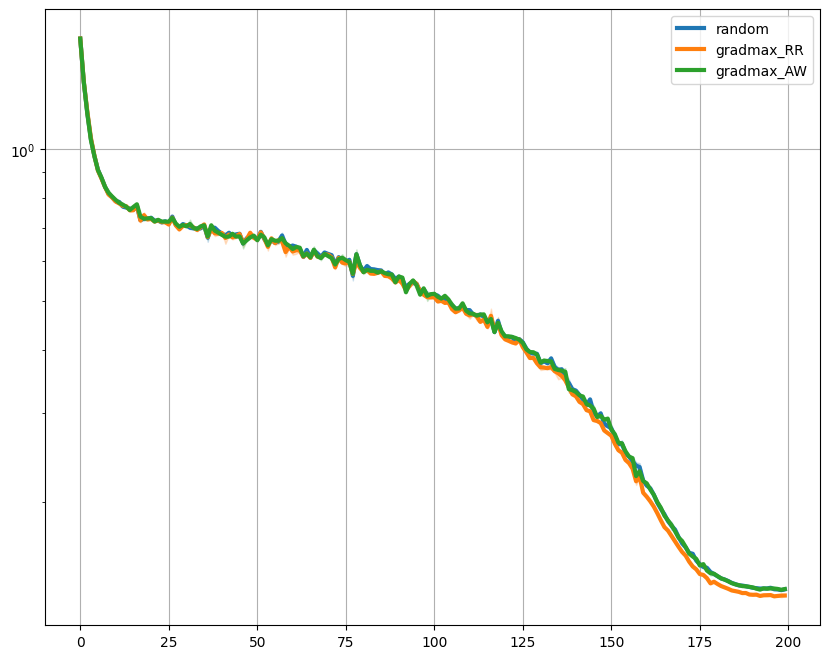

In [ ]:
stats = stats_history
methods = ['random', 'gradmax_RR', 'gradmax_AW']
plot_data(stats, methods, data_key='train/loss')

As we can see, unlike the student-teacher task, here `AutoWhere` performs worse that `RoundRobin`

> **OBS:** In this experiment we did not impose a maxiumum size for the layers but we leave the algorithm to freely choose the next layer to grow

Here instead we compare the accuracy on the validation (test) set

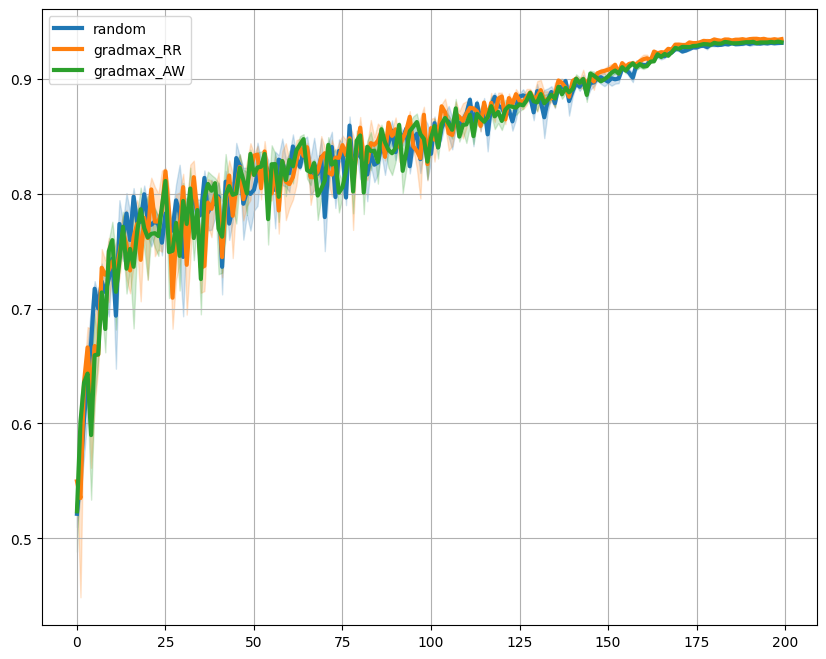

In [ ]:
stats = stats_history
methods = ['random', 'gradmax_RR', 'gradmax_AW']
plot_data(stats, methods, data_key='val/accuracy', plot_as_log=False)

### Loss difference (RoundRobin - AutoWhere)

Here we compute the difference between the training loss when `AutoWhere` and `RoundRobin` updaters are used

In [ ]:
exp_stats = dict()
#
autowhere = np.array(stats_history["gradmax_AW"]['train/loss'])
roundrobin = np.array(stats_history["gradmax_RR"]['train/loss'])
#
differences = roundrobin - autowhere
exp_stats['RR-AW'] = dict()
exp_stats['RR-AW']['differences_train_loss'] = differences

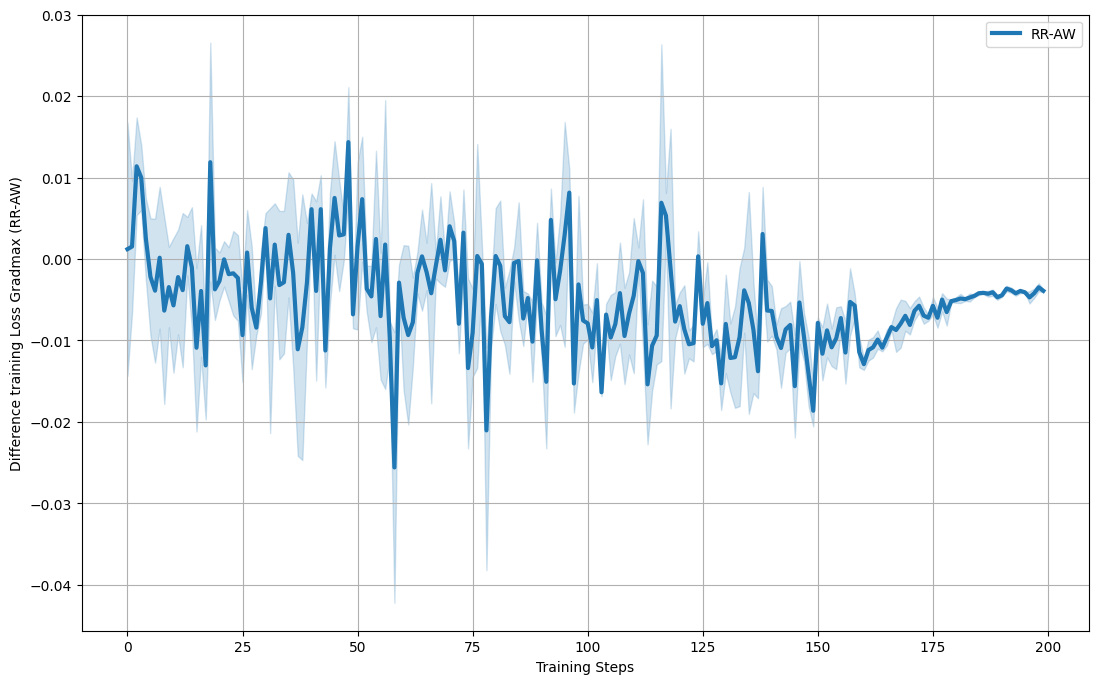

In [ ]:
plot_data(stats=exp_stats, 
          methods=['RR-AW'],#exp_4_methods,
          data_key='differences_train_loss', f_name='mlp_loss',
          ylabel='Difference training Loss Gradmax (RR-AW)', label_dict=None,#label_tranform_dict,
          xlabel='Training Steps',figsize=(13,8), plot_as_log=False
          )

Here we can clearly see that in this case `AutoWhere` performed worse since $RR - AW < 0$ at the end.